# Training machine learning algorithm to detect showers

- **NaN columns are removed from the list of analyzed features**
- ExtraTreesClassifier: min_samples_leaf=10, min_samples_split=50
- weighted sample
- orig xy count nonzero removed

The goal of the method is to classify events into two categories - **shower**, **noise**

Main motivation behind the method was difficulty to formulate selection conditions by hand, although this was an initial plan behind applying feature extraction procedure on flight data. Defining simple manual rules and using them might still not be impossible. This is also motivation to use feature elimination methods to aid in formulating selection rules. Using decision tree-based methods for classification follows this line of thought. These methods include determining a feature importance and decision trees can be visualized to understand how is the decision being made.

This procedure consists of the following parts:
1. [Data selection](#Data-selection)
    - Visible simulated events (simu signal above the background, track recognized in simulated shower signal).
    - Noisy simulated events (triggered well outside of track injection GTU). However, the background noise is from the flight data.
    - Flight noise events (triggered well outside of GTU 40).
    - Flight classified events - classified by the manual classification.
    
    
2. [Preparation of the testing and training datasets](#Preparation-of-the-testing-and-training-datasets)
    - Limitation: only subset of all extracted features is used to decrease computational demands of feature selection. However, the subset should be large enough to contain most of the features that are expected to have some property allowing to distinguish between a shower track and noise. This procedure should be selecting around 1000 event features from the database.
    - All visible simulated events should be included.
    - Datasets should be balanced (same size of each class).
    - Noise datased should be constructed by following priority: classified noise, unclassified flight, unclassified simu.
    
    
3. [Feature selection and classification](#Feature-selection-and-classification)
    - *(This is part that might be changed in the later machine learning procedures)*
    - Variance thresholding to remove features without any variance.
    - Univariate feature selection to select smaller but still large enough subset of features (mainly to limit the computational demands). This particular procedure selects 400 features.
    - Recursive feature elimination with cross-validation - Training and validating *Extremely Randomized Trees model (ExtraTreesClassifier)* on multiple combinations of features aimed to select set of features that provide the best classification accuracy.
    
    
4. [T-SNE visualization of the dataset](#T-SNE-RFECV-features)
    - *Currently not finished (TODO)*
    - Using manifold learning approach to reduce dimensionality of the data (unsupervised) into two dimensions.
    - There should be possibility to observe clusters in the reduced-dimensionality data and cluster should correlate with known classes of the data.
    
    
5. [Evaluation of the recognition efficiency](#Recognition-efficiency-RFECV-model)
    - Accuracy of classification on the whole dataset.
    - Accuracy (specificity) of classification on the labeled dataset of noise events.
    - Dependence of sensitivity to true energy, azimuth, and zenith angles.
    - Dependence of sensitivity to background intensity. *NOT DONE YET (TODO)*.

## Imports
(section not in the report)

In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_dataframes import *
# import supervised_classification as supc    
from utility_funtions import key_vals2val_keys

Welcome to JupyROOT 6.13/02


In [3]:
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.ensemble 
# import sklearn.neural_network
import sklearn.discriminant_analysis
import sklearn.model_selection
import sklearn.metrics
import sklearn.pipeline
from sklearn.externals import joblib

## Data selection

In [4]:
data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_201906122'
os.makedirs(data_snippets_dir, exist_ok=True)
os.makedirs(os.path.join(data_snippets_dir, 'figures'), exist_ok=True)

In [5]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_simu = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_simu_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_simu = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_simu)

In [6]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

### Selected columns

Unlinke machine learning approach, that would be trained directly on pixels and learn to identify important features as a part of a learning (for example convolutional neural network), this approach depends on a set of preselected features. Its possible advantage is that there is no need to discover identified features and after the feature extraction, the training is faster.

One of the sources of possible bias in the analysis might be initial selection of features that are analyzed by feature elimination methods.

For this experiment selected features include:
- number of triggered pixels (`trg_count_nonzero`),
- some properties describing the background frames and background frames projection,
- similarly for all frames of an event
- informations about line orientations in projections of a shower
- informations about precision of estimation the orientation of a shower
- ...

In [7]:
common_included_columns_re_list = [
  ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
  ('^trg(_box_per_gtu|_pmt_per_gtu|_ec_per_gtu)?$', '^(count_nonzero|min|max|sum|mean)$'),
    
  ('^bg(_x_y)?$','^(mean_gz|mean|max|min|count_nonzero|sum|size)$'),
    
  ('^orig(_x_y)?$','^(count_nonzero|max|mean|mean_gz|sum|size)$'),

  '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_max_clu_major_line_(phi|rho)',
  '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_major_line_(phi|rho)',
  '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_line_clusters_((max_(peak|size|sum|area)_clu_(height|width|size))|count|sizes_max|clu_(widths|heights|areas)_max)',

  ('(proc\d|trg|alt\d)_(gtu|x)_[yx]_clusters',('^(count|sizes_max|sizes_min|clu_areas_max|max_(size|peak)_clu_(width|height|size))$')),  
  ('^proc\d_(x|gtu)_[yx]_hough_peak_thr3','major_line_coord_.*'),
    
]

#### List of columns of simu data tables used for analysis

In [8]:
common_columns_for_analysis_dict = query_functions_simu.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(common_columns_for_analysis_dict)

spb_processing_v4_simu_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_simu_flatmap.event_trg_box_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_simu_flatmap.event_trg_pmt_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_simu_flatmap.event_trg_ec_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_simu_flatmap.event_trg_x_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_simu_flatmap.event_trg_gtu_x_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_simu_flatmap.event_trg_gtu_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_a

In [9]:
common_df_columns = query_functions_simu.get_dataframe_columns_from_dict(common_columns_for_analysis_dict)

#### List of columns of flight data tables used for analysis

In [10]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_trg_box_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_pmt_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_ec_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_x_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_x_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- m

### Data selection queries

#### Simu visible events (base)

All positive samples for the training are simulated shower tracks with background from the flight data (see notebook ver4_flatmap_visible_events). Events considered as positive samples have to contain track signal (see ver4_test_selection_visualization__simu_signal notebook) and has to be considered as visible (see ver4_flatmap_simu_visible_events notebook). 

Visibility of the event is decided by a rule that **there should be at least two frames of the event which  contain a signal pixel that is greater or equal to maximum background intensity in the frame**.

Additionally there is rule that the first trigger of a visible event should be in GTU $42\pm10$.

In [11]:
# not in the report

current_columns_for_analysis_dict = common_columns_for_analysis_dict

common_select_clause_str, common_tables_list = \
    query_functions_simu.get_query_clauses__select(current_columns_for_analysis_dict)

simu_where_clauses_str, simu_tables_list = \
    query_functions_simu.get_query_clauses__where_simu(
        gtu_in_packet_distacne=(40, 10), 
        num_frames_signals_ge_bg__ge=2, num_frames_signals_ge_bg__le=999
    )

joined_select_clause_str = common_select_clause_str + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event.{}'.format(attr) for attr in [
        'simu2npy_pathname', 'edetector_numphotons', 'edetector_numcellhits', 'edetector_numfee', 'eptttrigger_fnumtrigg', 
        'etruth_trueenergy', 'etruth_truetheta', 'etruth_truephi', 'egeometry_pos_z',
        'etruth_trueshowermaxpos_x', 'etruth_trueshowermaxpos_y', 'etruth_trueshowermaxpos_z'
    ]]) + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event_additional.{}'.format(attr) for attr in [
        'num_frames_counts_gt_bg', 'num_frames_signals_gt_bg', 'num_frames_signals_ge_bg'
    ]])

joined_tables_list = common_tables_list + simu_tables_list + [
    ('{database_schema_name}.simu_event_relation','{data_table_name}','event_id'),
    ('{database_schema_name}.simu_event_additional','{database_schema_name}.simu_event_relation','relation_id'),
    ('{database_schema_name}.simu_event','{database_schema_name}.simu_event_relation','simu_event_id'),
]

join_clauses_str = \
    query_functions_simu.get_query_clauses__join(joined_tables_list)

source_data_type_num = 3001

simu_events_selection_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num,
    select_additional=joined_select_clause_str, 
    join_additional=join_clauses_str,
    where_additional=simu_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, 
    limit=350000,
    base_select='')

# print(simu_events_selection_query)

In [12]:
simu_df = psql.read_sql(simu_events_selection_query, event_v3_storage_provider_simu.connection)

In [13]:
simu_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,etruth_trueenergy,etruth_truetheta,etruth_truephi,egeometry_pos_z,etruth_trueshowermaxpos_x,etruth_trueshowermaxpos_y,etruth_trueshowermaxpos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg
0,11464,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,17.0,...,1.000000e+13,1.311530,2.02739,27000000.0,-174947.0,4109870.0,11689800.0,3.0,3.0,3.0
1,11465,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,163,1,35,24,17.0,...,1.000000e+13,0.696797,4.65066,27000000.0,977005.0,1573110.0,4239100.0,16.0,16.0,16.0
2,11486,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,22.0,...,1.000000e+13,1.311530,2.02739,27000000.0,-174947.0,4109870.0,11689800.0,2.0,2.0,2.0
3,11487,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,20.0,...,1.000000e+13,1.311530,2.02739,27000000.0,-174947.0,4109870.0,11689800.0,3.0,3.0,3.0
4,11494,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,166,1,38,10,1.0,...,1.000000e+13,0.941292,5.61160,27000000.0,-5503800.0,3748850.0,5879780.0,5.0,5.0,5.0


#### Simu noise events

Simu noise events are events that are caused by a trigger well outside of GTU of shower injection into a packet. 

It is not ideal to use these these events as samples of the dataset because due the way the background of these events is added to the signal. Simply, if there is less packets providing the background than simualated signal tracks then same event might be repeated multiple times in the dataset. 
Besides repetition of a background packet, background of the simualted event is created by repeating sequence of background frames, thus this might cause multiple events in a same packet. How often this situation happens has not been tested. It is not expected to be very typical.

Better method of constructing these events would help validity of this analysis.

In [14]:
# not in the report

current_columns_for_analysis_dict = common_columns_for_analysis_dict

common_select_clause_str, common_tables_list = \
    query_functions_simu.get_query_clauses__select(current_columns_for_analysis_dict)

# simu_noise_where_clauses_str = ' AND abs(gtu_in_packet-42) >= 20 '

# OPTIMIZATION, ROWS WITH NULL SHOULD BE ALSO ANALYZED 
simu_noise_where_clauses_str = '''
    AND abs(gtu_in_packet-42) >= 20 
    AND {database_schema_name}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
'''

joined_select_clause_str = common_select_clause_str + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event.{}'.format(attr) for attr in [
        'simu2npy_pathname', 'edetector_numphotons', 'edetector_numcellhits', 'edetector_numfee', 'eptttrigger_fnumtrigg', 
        'etruth_trueenergy', 'etruth_truetheta', 'etruth_truephi', 'egeometry_pos_z'
    ]]) + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event_additional.{}'.format(attr) for attr in [
        'num_frames_counts_gt_bg', 'num_frames_signals_gt_bg', 'num_frames_signals_ge_bg'
    ]])

joined_tables_list = common_tables_list + simu_tables_list + [
    ('{database_schema_name}.simu_event_relation','{data_table_name}','event_id'),
    ('{database_schema_name}.simu_event_additional','{database_schema_name}.simu_event_relation','relation_id'),
    ('{database_schema_name}.simu_event','{database_schema_name}.simu_event_relation','simu_event_id'),
]

join_clauses_str = \
    query_functions_simu.get_query_clauses__join(joined_tables_list)

source_data_type_num = 3001

noise_simu_events_selection_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num,
    select_additional=joined_select_clause_str, 
    join_additional=join_clauses_str,
    where_additional=simu_noise_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, 
    limit=350000,
    base_select='')

# print(noise_simu_events_selection_query)

In [15]:
noise_simu_df = psql.read_sql(noise_simu_events_selection_query, event_v3_storage_provider_simu.connection)

In [16]:
noise_simu_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,edetector_numcellhits,edetector_numfee,eptttrigger_fnumtrigg,etruth_trueenergy,etruth_truetheta,etruth_truephi,egeometry_pos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg
0,11479,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,137,1,9,10,4.0,...,0,22456,0,1.000000e+13,0.765393,2.473790,27000000.0,NaN,NaN,NaN
1,11500,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,201,1,73,10,4.0,...,0,22456,0,1.000000e+13,0.765393,2.473790,27000000.0,NaN,NaN,NaN
2,11507,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,140,1,12,10,2.0,...,0,19291,0,1.000000e+13,1.192790,0.311703,27000000.0,NaN,NaN,NaN
3,11516,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,233,1,105,10,4.0,...,0,22456,0,1.000000e+13,0.765393,2.473790,27000000.0,NaN,NaN,NaN
4,11533,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,204,1,76,10,2.0,...,0,19291,0,1.000000e+13,1.192790,0.311703,27000000.0,NaN,NaN,NaN


#### Flight improbable events

More preferred set of background noise events consists of events that triggered outside of expected range of GTU. Note that these events were triggered in a configuration with lowered thresholds (number selected bin is halved). However, using such events on its own is not sufficient because the actual flight events are those that were triggered in default configuration.

In [17]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_noise_flight_select_clause_str, unl_noise_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_noise_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_noise_flight_tables_list)

unl_noise_source_data_type_num = 1

unl_noise_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) > 20
    AND {database_schema_name}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
    AND {database_schema_name}.event_orig_x_y.count_nonzero > 256*6
    AND {database_schema_name}.event.timestamp < 1560820000
''' 

unl_noise_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=unl_noise_source_data_type_num,
        select_additional=unl_noise_flight_select_clause_str, 
        join_additional=unl_noise_flight_clauses_str,
        where_additional=unl_noise_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
        limit=20000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
    #     limit=350000,
        base_select='')

# print(unl_noise_flight_events_selection_query)

In [18]:
unl_noise_flight_df = psql.read_sql(unl_noise_flight_events_selection_query, event_v3_storage_provider_flight.connection)
# flight_df = psql.read_sql(flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [19]:
unl_noise_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_size
0,63,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,94,0,94,12,1.0,...,3,9,3,9,3,9,3,5,5,5
1,65,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,131,1,3,12,2.0,...,9,15,9,15,9,15,9,18,18,18
2,94,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,479,3,95,10,2.0,...,4,11,4,11,4,11,4,7,7,7
3,97,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170502-061155...,trn_20170502-061155-001.001_C_inverse_flat_ave...,257,2,1,128,500.0,...,7,13,7,13,7,13,7,10,10,10
4,107,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170503-085415...,trn_20170503-085415-001.001_C_inverse_flat_ave...,119,0,119,13,2.0,...,6,20,6,20,6,2,1,6,2,6


In [177]:
len(unl_noise_flight_df)

12751

#### Flight labeled events

Important part of the dataset is set of events that were triggered by the hardware. These events are expected to be the hardest to recognize. Previous classification experiments without this set of events significantly limited usefulness of the method because it classified 60% of the flight events sample as a track (see ver4_test_selection_visualization__simu_20181018 notebook).
Addition of a relatively small set of these events (around 1500) seems to help significantly (see ver4_machine_learning_flight_classification_tsne_cfg3 notebook).

The manually classified dataset has been created using web classification tool (script web_manual_classification.py). The tool is available at http://eusospb-data.michalvrabel.sk.

In [20]:
EVENT_CLASSES = {
    'dot': 2,
    'top_left_ec': 5,
    'blob': 12,
    'large_blob': 11,
    'short_single_gtu_track': 7,
    'single_gtu_track': 3,
    'noise': 1,
    'cartesian_line': 4,
    'strong_pmt_edge': 9,
    'few_dots': 6,
    'bg_increased_suddenly': 10,
    'persistent_dot': 14,
    'noise_unspecified': 0,
    'unspecified': 8,
    'shower': 13,
    '2pix_line': 15,
    'bright_blob': 16,
    'blob_and_dots': 17,
    'dot_w_blob_behind': 18,
    'storng_light': 19,
    'sparse_blobs': 20,
    'noise_with_week_dot': 21
}

EVENT_CLASS_NUMBER_UNLABELED = -1
EVENT_CLASS_NUMBER_UNLABELED_NOISE = -2
EVENT_CLASS_LABLELED_NOISE_FLIGHT = -3  # in case of reduced classification

classification_table_name = event_v3_storage_provider_flight.database_schema_name + '.event_manual_classification'
classification_table_cls_column_name_simple = 'class_number'
classification_table_note_column_name_simple = 'note'
classification_table_last_modification_column_name_simple = 'last_modification'
classification_table_cls_column_name = classification_table_name + '.' + classification_table_cls_column_name_simple
classification_table_note_column_name = classification_table_name + '.' + classification_table_note_column_name_simple
classification_table_last_modification_column_name = classification_table_name + '.' + classification_table_last_modification_column_name_simple
classification_df_cls_column_name ='manual_classification_' + classification_table_cls_column_name_simple
classification_df_note_column_name ='manual_classification_' + classification_table_note_column_name_simple

In [21]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

lbl_noise_flight_select_clause_str, lbl_noise_flight_tables_list = \
    query_functions_flight.get_query_clauses__select({
        **current_columns_for_analysis_dict,
        classification_table_name: [classification_table_cls_column_name_simple]
    })

lbl_noise_flight_clauses_str = query_functions_flight.get_query_clauses__join(lbl_noise_flight_tables_list)

lbl_noise_source_data_type_num = 1

lbl_noise_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) <= 20
    AND {{database_schema_name}}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
    AND {{database_schema_name}}.event_orig_x_y.count_nonzero > 256*6
    AND {classification_table_cls_column_name} NOT IN ({event_class_shower}, {event_class_unspecified})
    AND {classification_table_last_modification_column_name} < '2019-04-09'
'''.format(
    classification_table_cls_column_name=classification_table_cls_column_name,
    classification_table_last_modification_column_name=classification_table_last_modification_column_name,
    event_class_shower=EVENT_CLASSES['shower'],
    event_class_unspecified=EVENT_CLASSES['unspecified']
)
#TODO
lbl_noise_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=lbl_noise_source_data_type_num,
        select_additional=lbl_noise_flight_select_clause_str, 
        join_additional=lbl_noise_flight_clauses_str,
        where_additional=lbl_noise_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
        limit=10000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
    #     limit=350000,
        base_select='')

# print(lbl_noise_flight_events_selection_query)

In [22]:
lbl_noise_flight_df = psql.read_sql(lbl_noise_flight_events_selection_query, event_v3_storage_provider_flight.connection)
# lbl_noise_flight_df[classification_df_cls_column_name] 

In [23]:
len(lbl_noise_flight_df)

1800

In [24]:
lbl_noise_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_size,manual_classification_class_number
0,95,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,551,4,39,10,3.0,...,6,1,6,1,6,1,5,6,6,15
1,322,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170505-100211...,trn_20170505-100211-001.001_C_inverse_flat_ave...,547,4,35,10,9.0,...,3,3,3,3,3,3,4,4,4,3
2,520,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170505-100211...,trn_20170505-100211-001.001_C_inverse_flat_ave...,1576,12,40,10,15.0,...,8,3,8,3,8,3,8,8,8,12
3,548,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-004.001_C_inverse_flat_ave...,293,2,37,20,241.0,...,4,2,4,2,4,2,5,5,5,11
4,913,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055927...,trn_20170429-055927-001.001_C_inverse_flat_ave...,1959,15,39,20,141.0,...,18,2,18,2,18,2,16,16,16,19


#### Flight unclassified probable events

Small subset of flight unclassified events, that were caused by trigger around GTU 42, are selected to be used for basic check of the data reduction capability.

In [25]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_flight_select_clause_str, unl_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_flight_tables_list)

unl_flight_source_data_type_num = 1

unl_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) < 20
    AND {{database_schema_name}}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
    AND {{database_schema_name}}.event_orig_x_y.count_nonzero > 256*6
    AND NOT EXISTS(
        SELECT {classification_table}.{{data_table_pk}} 
        FROM {classification_table} 
        WHERE {classification_table}.{{data_table_pk}} = {{data_table_name}}.{{data_table_pk}} LIMIT 1
    )
'''.format(
    classification_table=classification_table_name,
)

unl_flight_events_selection_query = query_functions_flight.get_events_selection_query_plain(
    source_data_type_num=unl_flight_source_data_type_num,
    select_additional=unl_flight_select_clause_str, 
    join_additional=unl_flight_clauses_str,
    where_additional=unl_flight_where_clauses_str,
    order_by='{data_table_name}.event_id',  # 'RANDOM()', # it might be skewed
    offset=0, 
    limit=10000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
#     limit=350000,
    base_select='')

# print(unl_flight_events_selection_query)

In [26]:
unl_flight_df = psql.read_sql(unl_flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [27]:
unl_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_size
0,61,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,39,0,39,11,7.0,...,2,6,2,6,2,6,2,5,5,5
1,67,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,166,1,38,11,7.0,...,3,8,3,8,3,8,3,8,8,8
2,73,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,39,0,39,22,7.0,...,7,4,2,4,2,4,2,3,4,4
3,75,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,162,1,34,15,526.0,...,3,3,3,3,3,3,3,4,4,4
4,77,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170430-072445...,trn_20170430-072445-001.001_C_inverse_flat_ave...,38,0,38,33,668.0,...,24,55,24,55,24,55,24,391,391,391


#### Classification column for unlabeled filght
(not in the report)

In [28]:
unl_flight_df[classification_df_cls_column_name] = EVENT_CLASS_NUMBER_UNLABELED
unl_noise_flight_df[classification_df_cls_column_name] = EVENT_CLASS_NUMBER_UNLABELED_NOISE

### Flight datasets in dict
(not in the report)

In [29]:
flight_df_dict = {
    'unl_noise_flight_df': unl_noise_flight_df, 
    'lbl_noise_flight_df': lbl_noise_flight_df, 
    'unl_flight_df': unl_flight_df
}

### Closing connections
(not in the report)

In [30]:
event_v3_storage_provider_simu.connection.close()
event_v3_storage_provider_flight.connection.close()

### Combined simulations dataset

Simu dataframes are combined because they have same columns. 
Then within this dataset events are classified into four groups based on 
- **Query classification information** - Primary classification based on the original data selection query - original intention of the data selection.
- **Simu signal classification information** - Secondary classification is addition of labeled simu signal events. The events are loaded from tables prepared in ver4_test_selection_visualization__simu_signal notebook.

The groups are the following:
- **simu noise** - data selected by query intended to select visible events but simu signal is classified as noisy simu data
- **simu track** - data selected by query intended to select visible events and simu signal is classified as a signal - <br> *these events will be used as positive samples for machine learning algorithms*
- **noise track** - data selected by query intended to select noise events but simu signal is classified as a shower
- **noise noise** - data selected by query intended to select noise events and contains simu signal classified as noisy simu data (could be used as a part of negative samples dataset, although it is not ideal)
- **simu unclassified**, **noise unclassified** - data without any labelling for simu signal data, generaly should consist of short tracks or noisy tracks, in-between easily recognizable tracks and noise.
- **simu noise underflow**, **simu noise overflow**, **simu track underflow**, **simu track overflow** - data selected by query intended to select visible events but no simu signal is present (ideally should be empty)
- **noise noise underflow**, **noise noise overflow**, **noise track underflow**, **noise track overflow**   - data selected by query intended to select noise events and no simu signal is present - <br> *these events will be used as negative samples but with a low priority*

In [31]:
combined_simu_df = pd.concat([simu_df, noise_simu_df])

In [32]:
# flight_columns_list = list(lbl_noise_flight_df.columns.values)
# combined_flight_df = pd.concat([unl_noise_flight_df[flight_columns_list], lbl_noise_flight_df[flight_columns_list], unl_flight_df[flight_columns_list]])

In [33]:
print('len(simu_df) =', len(simu_df))
print('len(noise_simu_df) =', len(noise_simu_df))
print('len(combined_simu_df) =', len(combined_simu_df))

len(simu_df) = 35607
len(noise_simu_df) = 128793
len(combined_simu_df) = 164400


#### $R_{max}$ property of simulated showers

In [34]:
# 'etruth_trueshowermaxpos_x', 'etruth_trueshowermaxpos_y', 'etruth_trueshowermaxpos_z'
combined_simu_df['calc_etruth_trueshower_rmax'] = np.hypot(combined_simu_df['etruth_trueshowermaxpos_x'], combined_simu_df['etruth_trueshowermaxpos_y'])

#### Query classification information
Primary classification based on the original data selection query - original intention of the data selection.

In [35]:
combined_simu_df['cond_selection_query'] = 'undefined'
combined_simu_df.loc[combined_simu_df['event_id'].isin(simu_df['event_id']), 'cond_selection_query'] = 'simu'
combined_simu_df.loc[combined_simu_df['event_id'].isin(noise_simu_df['event_id']), 'cond_selection_query'] = 'noise'

In [36]:
if('simu_df' in locals()): del simu_df
if('noise_simu_df' in locals()): del noise_simu_df
# if('unl_noise_flight_df' in locals()): del unl_noise_flight_df
# if('lbl_noise_flight_df' in locals()): del lbl_noise_flight_df
# if('unl_flight_df' in locals()): del unl_flight_df

#### Simu signal classification information
Secondary classification is addition of labeled simu signal events.
The events are loaded from tables prepared in ver4_test_selection_visualization__simu_signal notebook.

In [37]:
# [['event_id', 'source_file_acquisition', 'global_gtu', 'packet_id', 'gtu_in_packet', 'num_gtu', 'source_file_acquisition_full']]

simu_signal_data_snippets_dir = 'ver4_simu_signal_data_snippets'
simu_signal_visible_tracks_table_path = os.path.join(simu_signal_data_snippets_dir, 'visible_tracks_table.tsv')
simu_signal_noisy_events_table_path = os.path.join(simu_signal_data_snippets_dir, 'noisy_events_table.tsv')

combined_simu_df, unclassified_simu_df, \
track_simu_df, track_underflow_simu_df, track_overflow_simu_df, \
noise_simu_df, noise_underflow_simu_df, noise_overflow_simu_df, \
simu_signal_track_events_df, simu_signal_noisy_events_df = \
    add_classification_columns(
        combined_simu_df, 
        simu_signal_visible_tracks_table_path, simu_signal_noisy_events_table_path,
        ret_simu_signal=True, ret_under_over_track=True, ret_split_noise=True,
        simu_track_class='track', simu_noise_class='noise',
        simu_track_underflow_class='track_underflow', simu_track_overflow_class='track_overflow',
        simu_noise_underflow_class='noise_underflow', simu_noise_overflow_class='noise_overflow',
        simu_events_file_pathname_dir=data_snippets_dir)

##### Combined label - joining query and labeled simu class

In [38]:
combined_simu_df['cond_selection_combined'] = 'undefined'

for selection_query in ['simu','noise']:
    for selection_simu_signal in ['noise','track']:
        for simu_signal_sync in ['', 'underflow', 'overflow']:
            t_selection_simu_signal = selection_simu_signal
            if len(simu_signal_sync) > 0:
                t_selection_simu_signal += '_' + simu_signal_sync
            combined_simu_df.loc[
                (combined_simu_df['cond_selection_query'] == selection_query ) & 
                (combined_simu_df['cond_selection_simple'] == t_selection_simu_signal), 
                'cond_selection_combined'] = selection_query + '_' + t_selection_simu_signal

##### Size of the  subsets

###### Simu signal labels

In [39]:
print('len(simu_signal_track_events_df)', len(simu_signal_track_events_df))
print('len(simu_signal_noisy_events_df)', len(simu_signal_noisy_events_df))
print('-'*50)
print('len(combined_simu_df)           ', len(combined_simu_df))
print('-'*50)
print('len(unclassified_simu_df)       ', len(unclassified_simu_df))
print('len(track_simu_df)              ', len(track_simu_df))
print('len(track_underflow_simu_df)    ', len(track_underflow_simu_df))
print('len(track_overflow_simu_df)     ', len(track_overflow_simu_df))
print('len(noise_simu_df)              ', len(noise_simu_df))
print('len(noise_underflow_simu_df)    ', len(noise_underflow_simu_df))
print('len(noise_overflow_simu_df)     ', len(noise_overflow_simu_df))
print('-'*50)
print('                                   ', 
      len(unclassified_simu_df) + \
      len(track_simu_df) + len(track_underflow_simu_df) + len(track_overflow_simu_df) + \
      len(noise_simu_df) + len(noise_underflow_simu_df) + len(noise_overflow_simu_df)
     )
print('-'*50)
print('len(track_simu_df)/len(combined_simu_df)        = ', len(track_simu_df)/len(combined_simu_df))
print('len(unclassified_simu_df)/len(combined_simu_df) = ', len(unclassified_simu_df)/len(combined_simu_df))
print('len(noise_simu_df)/len(combined_simu_df)        = ', len(noise_simu_df)/len(combined_simu_df))

len(simu_signal_track_events_df) 14866
len(simu_signal_noisy_events_df) 59279
--------------------------------------------------
len(combined_simu_df)            164400
--------------------------------------------------
len(unclassified_simu_df)        9288
len(track_simu_df)               35038
len(track_underflow_simu_df)     5983
len(track_overflow_simu_df)      16956
len(noise_simu_df)               1608
len(noise_underflow_simu_df)     24689
len(noise_overflow_simu_df)      70838
--------------------------------------------------
                                    164400
--------------------------------------------------
len(track_simu_df)/len(combined_simu_df)        =  0.2131265206812652
len(unclassified_simu_df)/len(combined_simu_df) =  0.056496350364963505
len(noise_simu_df)/len(combined_simu_df)        =  0.00978102189781022


###### Selection query and simu signal labels

In [40]:
for selection_query in ['simu','noise']:
    for selection_simu_signal in ['noise','track']:
        for simu_signal_sync in ['', 'underflow', 'overflow']:
            t_selection_simu_signal = selection_simu_signal
            if len(simu_signal_sync) > 0:
                t_selection_simu_signal += '_' + simu_signal_sync
            print('{:<30} {}'.format(
                '{} - {}'.format(selection_query, t_selection_simu_signal),
                np.count_nonzero(
                    (combined_simu_df['cond_selection_query'] == selection_query ) & \
                    (combined_simu_df['cond_selection_simple'] == t_selection_simu_signal))
            ))                

simu - noise                   4
simu - noise_underflow         0
simu - noise_overflow          0
simu - track                   34521
simu - track_underflow         0
simu - track_overflow          0
noise - noise                  1604
noise - noise_underflow        24689
noise - noise_overflow         70838
noise - track                  517
noise - track_underflow        5983
noise - track_overflow         16956


##### Example of track underflow subset

In [41]:
track_underflow_simu_df.sort_values('gtu_in_packet', ascending=False).head()

,alt1_gtu_x_clusters_clu_areas_max,alt1_gtu_x_clusters_count,alt1_gtu_x_clusters_max_peak_clu_height,alt1_gtu_x_clusters_max_peak_clu_size,alt1_gtu_x_clusters_max_peak_clu_width,alt1_gtu_x_clusters_max_size_clu_height,alt1_gtu_x_clusters_max_size_clu_width,alt1_gtu_x_clusters_sizes_max,alt1_gtu_x_clusters_sizes_min,alt1_gtu_x_hough_peak_thr1_line_clusters_clu_areas_max,...,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_size,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr3_line_clusters_sizes_max,trg_x_y_hough_peak_thr3_major_line_phi,trg_x_y_hough_peak_thr3_major_line_rho,calc_etruth_trueshower_rmax,cond_selection_query,simu2npy_signals_pathname,simu2npy_signals_pathname_short,cond_selection_simple
45187,517,1,47,87,11,47,11,87,87,312,...,2.0,4.0,2.0,0.705976,49.61780,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_21000000.00/energy_1.41e+12/thousnd21E3.2...,track_underflow
25116,470,1,47,99,10,47,10,99,99,448,...,32.0,40.0,32.0,1.542360,41.69640,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,track_underflow
21799,432,1,48,129,9,48,9,129,129,96,...,36.0,61.0,36.0,0.777668,48.29370,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,track_underflow
3711,480,1,48,158,10,48,10,158,158,84,...,34.0,47.0,34.0,0.070885,43.67790,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_27000000.00/energy_1.26e+12/thousnd27E2/s...,track_underflow
93171,380,1,38,130,10,38,10,130,130,984,...,5.0,14.0,5.0,5.732600,1.56028,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_18000000.00/energy_5.25e+12/simu.2017-07-...,track_underflow


##### Example of track overflow subset

In [42]:
track_overflow_simu_df.sort_values('gtu_in_packet', ascending=True).head()

,alt1_gtu_x_clusters_clu_areas_max,alt1_gtu_x_clusters_count,alt1_gtu_x_clusters_max_peak_clu_height,alt1_gtu_x_clusters_max_peak_clu_size,alt1_gtu_x_clusters_max_peak_clu_width,alt1_gtu_x_clusters_max_size_clu_height,alt1_gtu_x_clusters_max_size_clu_width,alt1_gtu_x_clusters_sizes_max,alt1_gtu_x_clusters_sizes_min,alt1_gtu_x_hough_peak_thr1_line_clusters_clu_areas_max,...,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_size,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr3_line_clusters_sizes_max,trg_x_y_hough_peak_thr3_major_line_phi,trg_x_y_hough_peak_thr3_major_line_rho,calc_etruth_trueshower_rmax,cond_selection_query,simu2npy_signals_pathname,simu2npy_signals_pathname_short,cond_selection_simple
53058,960,1,48,174,20,48,20,174,174,495,...,16.0,20.0,16.0,0.028378,6.05809,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_30000000.00/energy_2.00e+12/thousnd30E6.2...,track_overflow
58199,470,1,47,61,10,47,10,61,61,351,...,31.0,40.0,31.0,1.540630,41.73390,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,track_overflow
58697,611,1,47,133,13,47,13,133,133,459,...,28.0,31.0,28.0,0.169183,1.69015,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,track_overflow
59486,576,1,48,107,12,48,12,107,107,322,...,3.0,2.0,3.0,0.294290,45.28720,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_21000000.00/energy_3.94e+12/ter212.2017-0...,track_overflow
110238,611,1,47,133,13,47,13,133,133,459,...,28.0,31.0,28.0,0.169183,1.69015,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_18000000.00/energy_8.50e+12/set18.2017-07...,track_overflow


##### Visualization of a few events

- Noise entries are sorted by number of simu signal pixles in x-y projection in descending order (`orig_x_y_count_nonzero`, sorted from the most potentially track-like),
- Track entries are sorted by num frames where maximum signal is greater equal maximum background in acsending order (`num_frames_signals_ge_bg`, from the least visible track events). Non-track-like simu signal might not be necessarly incorrectly labeled entries, just a small portion of a track in signal.
- Track underflow, track overflow should all contain empty simu signal data. Entries are sorted by GTU in packet in ascending or descending order, respectively.

noise (1608 entries)
--------------------------------------------------
#0	(0)
	event_id: 2261798
	packet_id: 1
	gtu_in_packet: 17
	num_gtu: 23
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_30000000.00/energy_6.31e+12/thousnd30E16.2017-07-25-13h05m21s/simu2npy/ev_34_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: noise


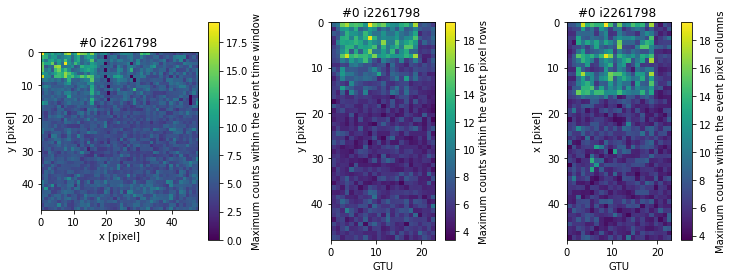

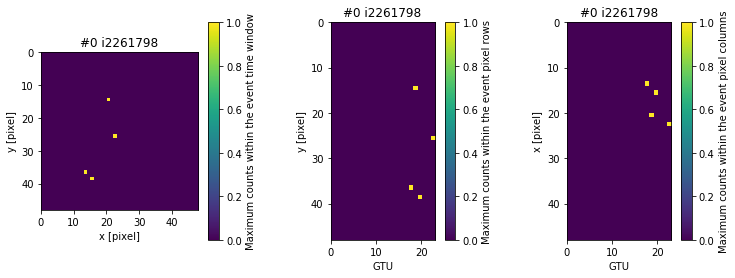

#1	(0)
	event_id: 2020798
	packet_id: 1
	gtu_in_packet: 17
	num_gtu: 23
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_18000000.00/energy_5.62e+12/thousnd18E15.2017-07-28-11h19m08s/simu2npy/ev_77_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: noise


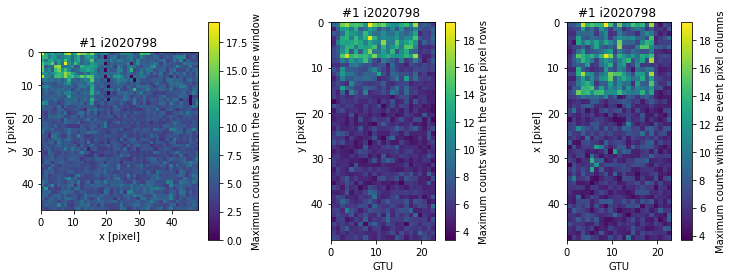

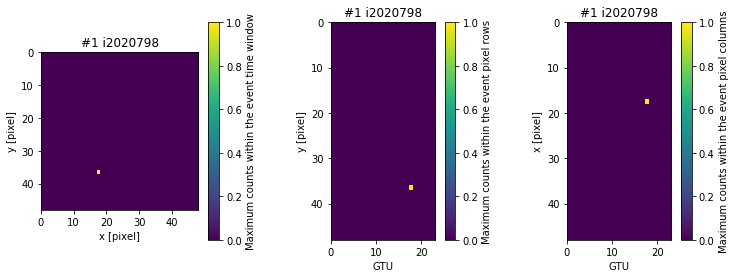

#2	(0)
	event_id: 2452180
	packet_id: 1
	gtu_in_packet: 21
	num_gtu: 20
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_18000000.00/energy_7.15e+12/simu.2017-07-24-06h44m34s/simu2npy/ev_50_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: noise


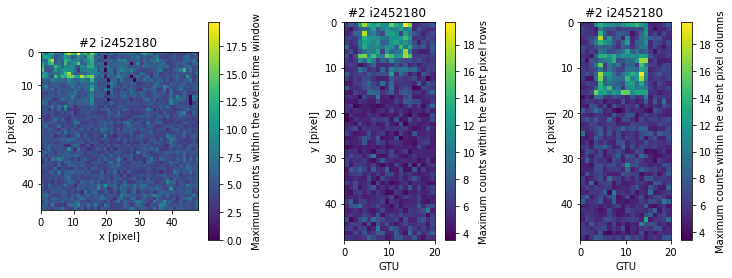

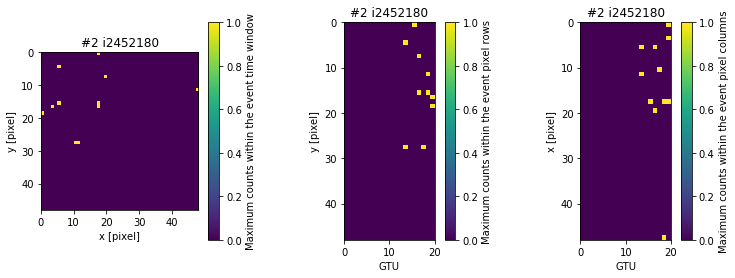

track (35038 entries)
--------------------------------------------------
#0	(0)
	event_id: 2626269
	packet_id: 1
	gtu_in_packet: 67
	num_gtu: 10
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_33000000.00/energy_8.91e+12/thousnd33E19/simu2npy/ev_97_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track


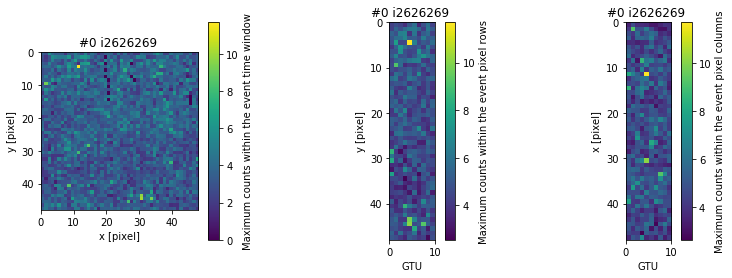

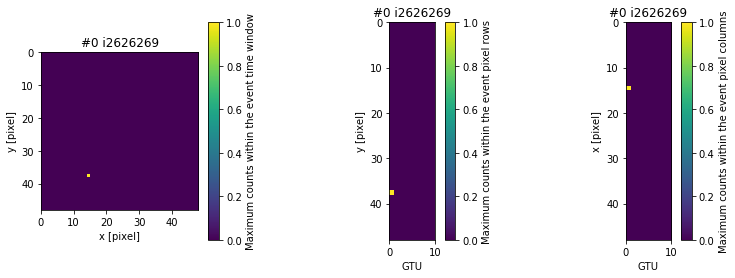

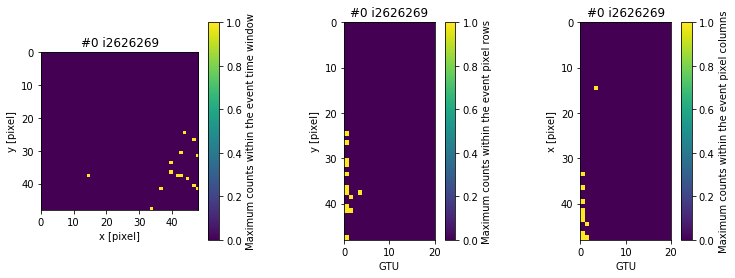

#1	(0)
	event_id: 2118783
	packet_id: 1
	gtu_in_packet: 65
	num_gtu: 12
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_30000000.00/energy_1.58e+12/thousnd30E4/simu2npy/ev_98_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track


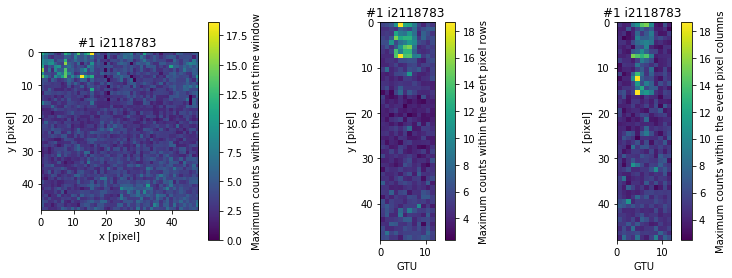

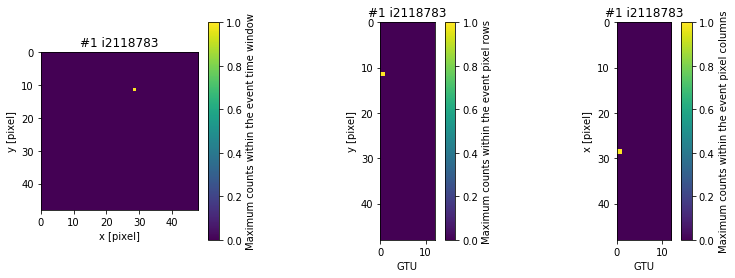

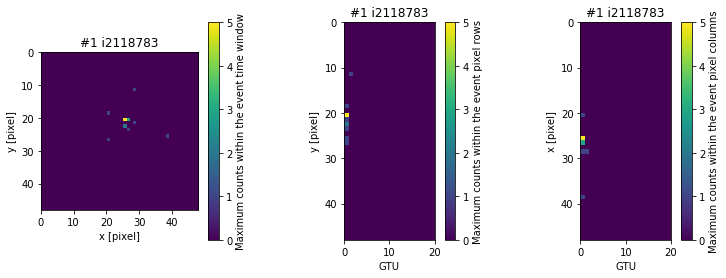

#2	(0)
	event_id: 2119602
	packet_id: 1
	gtu_in_packet: 64
	num_gtu: 16
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_21000000.00/energy_1.58e+12/thousnd21E4.2017-07-26-21h24m15s/simu2npy/ev_20_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track


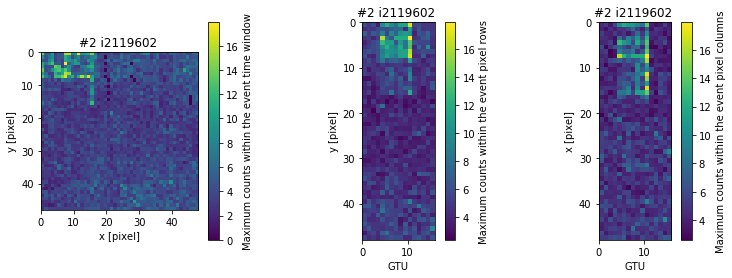

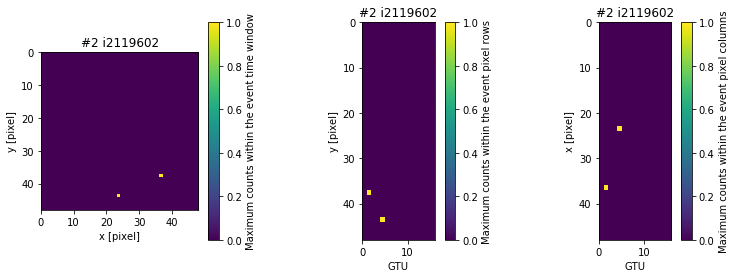

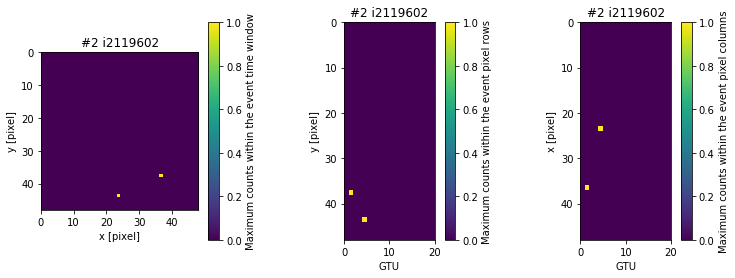

track_underflow (5983 entries)
--------------------------------------------------
#0	(0)
	event_id: 2109098
	packet_id: 1
	gtu_in_packet: 22
	num_gtu: 11
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_21000000.00/energy_1.41e+12/thousnd21E3.2017-07-26-20h13m39s/simu2npy/ev_79_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_underflow


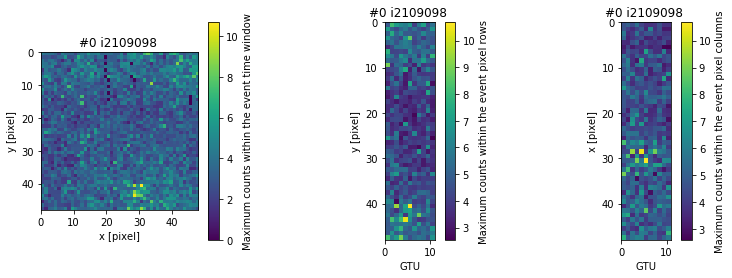

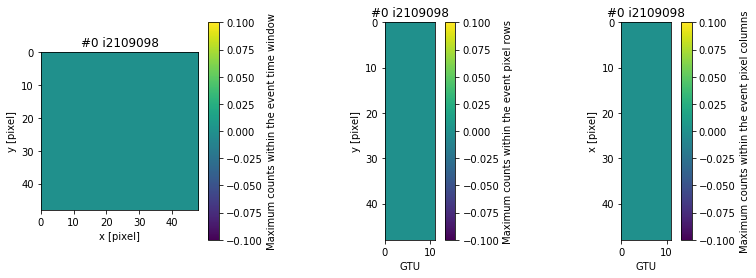

#1	(0)
	event_id: 189885
	packet_id: 1
	gtu_in_packet: 22
	num_gtu: 10
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_24000000.00/energy_5.95e+12/simu.2017-07-20-20h00m16s/simu2npy/ev_16_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_underflow


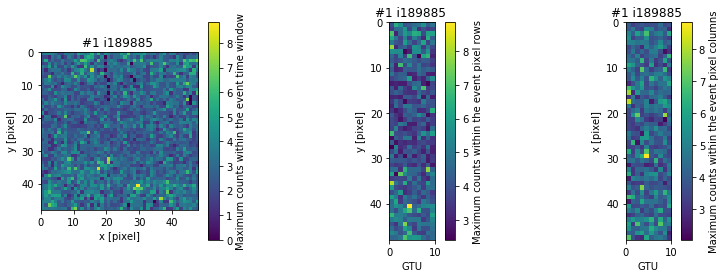

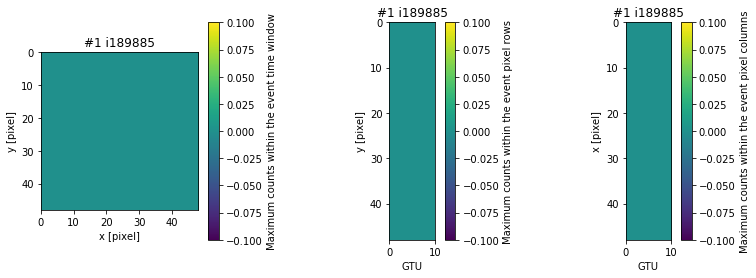

#2	(0)
	event_id: 154316
	packet_id: 1
	gtu_in_packet: 22
	num_gtu: 9
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_24000000.00/energy_5.95e+12/simu.2017-07-21-05h30m38s/simu2npy/ev_59_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_underflow


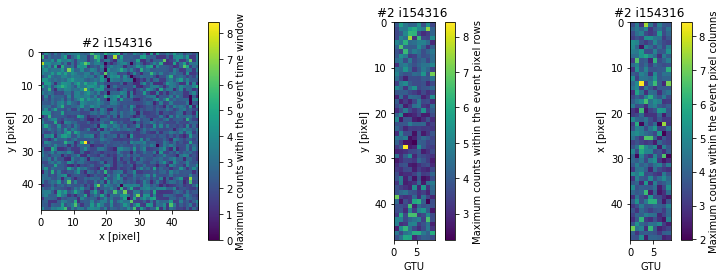

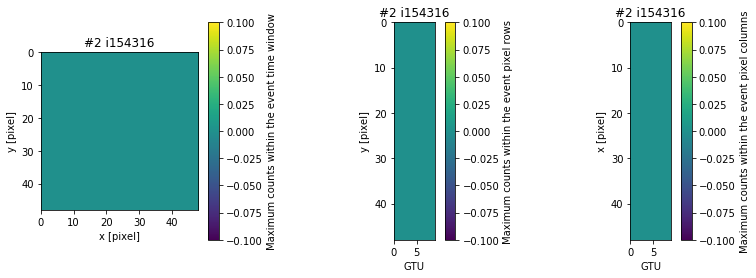

track_overflow (16956 entries)
--------------------------------------------------
#0	(0)
	event_id: 2156392
	packet_id: 1
	gtu_in_packet: 62
	num_gtu: 20
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_30000000.00/energy_2.00e+12/thousnd30E6.2017-07-24-22h56m23s/simu2npy/ev_61_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_overflow


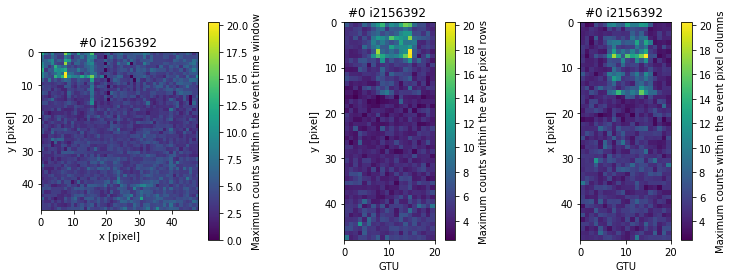

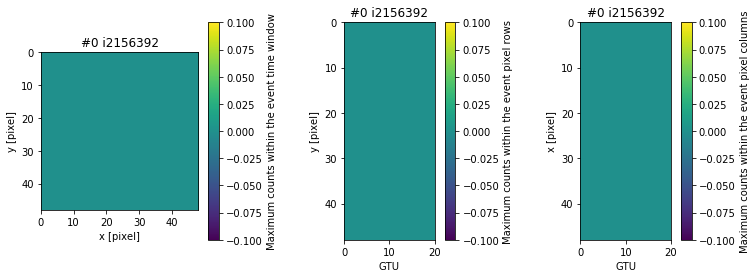

#1	(0)
	event_id: 2189735
	packet_id: 1
	gtu_in_packet: 62
	num_gtu: 10
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-21h02m30s/simu2npy/ev_62_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_overflow


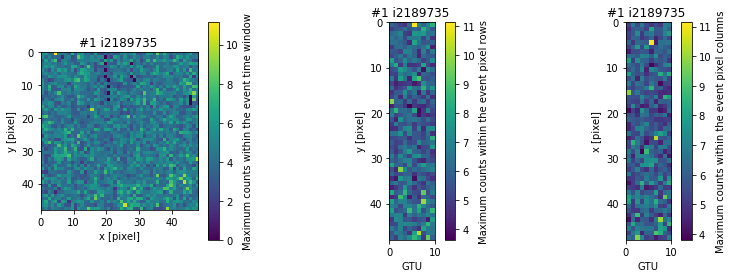

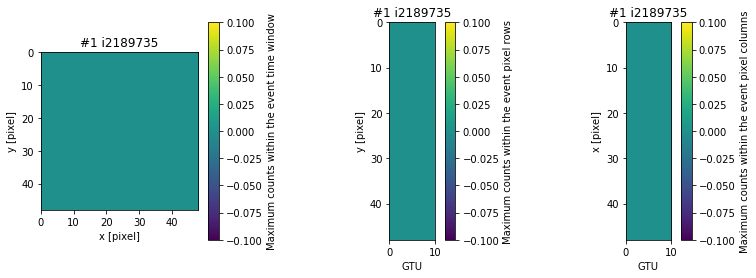

#2	(0)
	event_id: 2192502
	packet_id: 1
	gtu_in_packet: 62
	num_gtu: 14
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-21h10m14s/simu2npy/ev_47_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_overflow


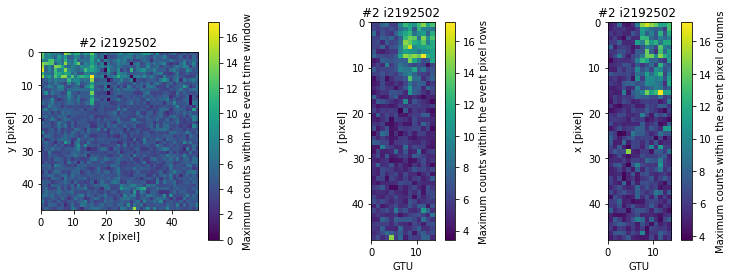

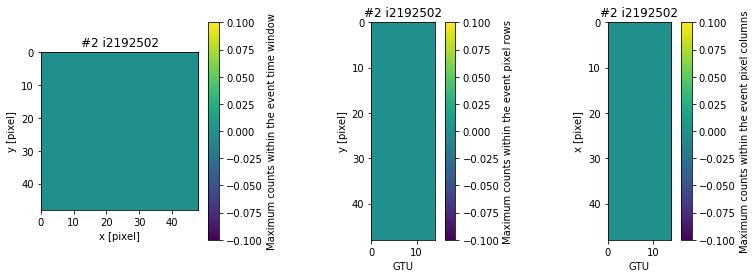

In [43]:
def vis_simu_signal_default(i, r, visualized_projections, fig, axs_flattened): 
    show_simu_event_row(i, r, 
        npy_pathname_column='simu2npy_signals_pathname', 
        single_proj_width=4, single_proj_height=4,
        print_info=False, warn_if_not_exact_simu=False)

def vis_simu_signal_with_original(i, r, visualized_projections, fig, axs_flattened):
    vis_simu_signal_default(i, r, visualized_projections, fig, axs_flattened)
    show_simu_event_row(i, r, 
        npy_pathname_column='simu2npy_signals_pathname', 
        single_proj_width=4, single_proj_height=4,
        print_info=False, warn_if_not_exact_simu=False,
        simu_gtu_override=(30,50))

for label, events_to_vis_df in [
        ('noise', noise_simu_df.sort_values('orig_x_y_count_nonzero', ascending=False)), 
        ('track', track_simu_df.sort_values('num_frames_signals_ge_bg', ascending=True)), 
        ('track_underflow', track_underflow_simu_df.sort_values('gtu_in_packet', ascending=False)), 
        ('track_overflow', track_overflow_simu_df.sort_values('gtu_in_packet', ascending=True))
]:
    print('{} ({} entries)'.format(label, len(events_to_vis_df)))
    print('-' * 50)
    vis_events_df(
        events_to_vis_df, 
        events_per_figure=3, max_figures=1, vis_gtux=True, vis_gtuy=True, 
        close_after_vis=False, show=True, 
        additional_printed_columns=[
            'num_frames_signals_ge_bg', 'simu2npy_signals_pathname_short', 
            'cond_selection_query', 'cond_selection_simple'],
        by_one=True,
        extension_func=vis_simu_signal_with_original if label == 'track' else vis_simu_signal_default,
        single_proj_width=4, single_proj_height=4
    )
    print('=' * 50)

### Adding new features

#### Rank column
The principle of a rank column is to combine values of features based on expected or calculated correlation of a column with likeliness of an event being a shower. The lowest value should correspond to the most probable shower track.

In this case, a short set of hand-picked list is utilized. More preferable way of doing this would be to use columns selected by a machine learning approach that calculates feature importance.

The provided features are normalized to 0-1 range, 
optionally, the values of the features are inverted (1-val) and weighted. 
Finally, the summed value is resulting rank of a record.

In [44]:
rank_columns = ['proc1_x_y_hough_peak_thr2_line_clusters_count', 'proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 
                 'proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width',
                 'trg_count_nonzero', 'num_gtu']

def add_rank_column_default(data_df):
    add_rank_column(data_df, 
                    rank_columns, 
                    ascending=[True, True, True, True, False, False], 
                    column_weights=[2,2,1,1,1,1],
                    print_max_vals=True, add_norm_columns=True, do_copy=False)

#### Difference columns
Expected property of air shower event is that at least in one of the shower projections in time should contain a line with a slope different than 0 or 90 degrees. 
In an ideal case an actual slope of a line is not important, only important information is slope difference to 0 or 90 degrees.

In [45]:
# not in the report
area_columns_prefix_list = ('proc1', 'proc2', 'proc3', 'trg')
area_columns_proj_list = ('x_y', 'gtu_x', 'gtu_y')
area_columns_thr_i_list = list(range(1,4))

area_columns_line_types = ['peak', 'sum', 'size']
area_columns_col_name_prefixes = ['{{prefix}}_{{proj}}_hough_peak_thr{{thr_i}}_line_clusters_max_{}_clu_'.format(t) for t in area_columns_line_types]

diff_columns_proc_range = (1,4)
diff_columns_alt_range = (1,1)
diff_columns_thr_range = (1,4)

diff_columns_prefixes = \
    ['proc{}'.format(i) for i in range(*diff_columns_proc_range)] + \
    ['alt{}'.format(i) for i in range(*diff_columns_alt_range)]

diff_columns_projs = ['gtu_x', 'gtu_y']
diff_columns_diff_types = ['pi_over_2', '0']

diff_columns_gtu_y_gtu_x_diff_format = '{prefix}_gtu_y_gtu_x_hough_peak_thr{thr_i}_major_line_phi_diff'
diff_columns_proj_diff_format = '{prefix}_{proj}_hough_peak_thr{thr_i}_major_line_phi_diff_{diff_type}'

#

common_extension_columns = ['event_id', 'rank']

for col in rank_columns:
    common_extension_columns.append('norm_' + col)

for prefix in area_columns_prefix_list:
    for proj in area_columns_proj_list:
        for thr_i in area_columns_thr_i_list:
            for col_name_prefix in area_columns_col_name_prefixes:
                common_extension_columns.append(col_name_prefix.format(prefix=prefix, proj=proj, thr_i=thr_i) + 'area')
    
for prefix in diff_columns_prefixes:
    for thr_i in range(*diff_columns_thr_range):
        common_extension_columns.append(diff_columns_gtu_y_gtu_x_diff_format.format(prefix=prefix, thr_i=thr_i))
        for proj in diff_columns_projs:
            for diff_type in diff_columns_diff_types:
                common_extension_columns.append(diff_columns_proj_diff_format.format(prefix=prefix, thr_i=thr_i, proj=proj, diff_type=diff_type))


simu_extension_columns = common_extension_columns
flight_extension_columns = common_extension_columns

# print(common_extension_columns)

#### Simu dataframe extension columns
(not in the report)

In [46]:
simu_event_ids_md5 = hashlib.md5(pickle.dumps(combined_simu_df['event_id'].values, protocol=0)).hexdigest()
simu_extension_columns_md5 = hashlib.md5(','.join(simu_extension_columns).encode()).hexdigest()
extension_columns_combined_simu_pathname = os.path.join(data_snippets_dir, 'extension_columns_simu_pathname_{}_{}.pkl.gz'.format(simu_event_ids_md5, simu_extension_columns_md5))
print(extension_columns_combined_simu_pathname)

ver4_machine_learning_w_labeled_flight_201906122/extension_columns_simu_pathname_771a6a452a651f419ec12b94ac5eb28d_51d1629013c22c624c6bcb50d5b214a0.pkl.gz


In [47]:
if not os.path.exists(extension_columns_combined_simu_pathname):
    print('Building calculating columns ...')
    print('num_frames_signals_ge_bg bin column ...')
    
    add_bin_column(combined_simu_df, 'num_frames_signals_ge_bg', 5)

    print('  area columns ...')
    
    for attr_prefix_format in area_columns_col_name_prefixes:    
        add_area_columns(combined_simu_df, prefix_list=area_columns_prefix_list, proj_list=area_columns_proj_list, thr_i_list=area_columns_thr_i_list,
                        attr_prefix_format=attr_prefix_format) 

    print('  diff columns ...')
    
    add_diff_columns(combined_simu_df, proc_range=diff_columns_proc_range, alt_range=diff_columns_alt_range, hough_peak_thr_range=diff_columns_thr_range)

    print('  rank column ...')
    
    add_rank_column_default(combined_simu_df)

    print('Saving pickle ...')
        
    combined_simu_df[simu_extension_columns].to_pickle(extension_columns_combined_simu_pathname, 'gzip')
    
else:
    print('Loading...')
    simu_extension_columns_df = pd.read_pickle(extension_columns_combined_simu_pathname, 'gzip')
    print('Merging ...')
    combined_simu_df = pd.merge(combined_simu_df, simu_extension_columns_df, on=['event_id'])
    del simu_extension_columns_df
    
combined_simu_df.head()

Loading...
Merging ...


,alt1_gtu_x_clusters_clu_areas_max,alt1_gtu_x_clusters_count,alt1_gtu_x_clusters_max_peak_clu_height,alt1_gtu_x_clusters_max_peak_clu_size,alt1_gtu_x_clusters_max_peak_clu_width,alt1_gtu_x_clusters_max_size_clu_height,alt1_gtu_x_clusters_max_size_clu_width,alt1_gtu_x_clusters_sizes_max,alt1_gtu_x_clusters_sizes_min,alt1_gtu_x_hough_peak_thr1_line_clusters_clu_areas_max,...,proc3_gtu_y_gtu_x_hough_peak_thr2_major_line_phi_diff,proc3_gtu_x_hough_peak_thr2_major_line_phi_diff_pi_over_2,proc3_gtu_x_hough_peak_thr2_major_line_phi_diff_0,proc3_gtu_y_hough_peak_thr2_major_line_phi_diff_pi_over_2,proc3_gtu_y_hough_peak_thr2_major_line_phi_diff_0,proc3_gtu_y_gtu_x_hough_peak_thr3_major_line_phi_diff,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_pi_over_2,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_0,proc3_gtu_y_hough_peak_thr3_major_line_phi_diff_pi_over_2,proc3_gtu_y_hough_peak_thr3_major_line_phi_diff_0
0,423,1,47,29,9,47,9,29,29,108,...,0.369017,1.271984,0.298812,1.500591,0.070205,0.386129,1.254872,0.315924,1.500591,0.070205
1,400,2,15,24,22,15,22,24,14,100,...,1.226577,0.029304,1.541493,1.255881,0.314915,1.219437,0.052804,1.517993,1.272241,0.298555
2,528,1,48,51,11,48,11,51,51,81,...,0.184444,1.210844,0.359952,1.395288,0.175508,0.184444,1.210844,0.359952,1.395288,0.175508
3,517,1,47,43,11,47,11,43,43,93,...,0.182697,1.315778,0.255018,1.498476,0.072321,0.272988,1.255128,0.315668,1.528116,0.042680
4,480,1,48,131,10,48,10,131,131,510,...,0.075040,1.338344,0.232453,1.263304,0.307493,0.090020,1.354184,0.216613,1.264164,0.306633


#### Flight dataframe extension columns
(not in the report)

In [48]:
# if('unl_noise_flight_df' in locals()): del unl_noise_flight_df
# if('lbl_noise_flight_df' in locals()): del lbl_noise_flight_df
# if('unl_flight_df' in locals()): del unl_flight_df

extension_columns_flight_pathnames = {}

for subset_label, subset_df in \
        flight_df_dict.items():
    flight_event_ids_md5 = hashlib.md5(pickle.dumps(subset_df['event_id'].values, protocol=0)).hexdigest()
    flight_extension_columns_md5 = hashlib.md5(','.join(flight_extension_columns).encode()).hexdigest()
    extension_columns_flight_pathnames[subset_label] = \
        os.path.join(data_snippets_dir, 
                     'extension_columns_{}_{}_{}.pkl.gz'.format(
                         subset_label,
                         flight_event_ids_md5, flight_extension_columns_md5))
    print(extension_columns_flight_pathnames[subset_label])  
    
# flight_event_ids_md5 = hashlib.md5(pickle.dumps(combined_flight_df['event_id'].values, protocol=0)).hexdigest()
# flight_extension_columns_md5 = hashlib.md5(','.join(flight_extension_columns).encode()).hexdigest()
# extension_columns_flight_pathname = os.path.join(data_snippets_dir, 'extension_columns_flight_pathname_{}_{}.pkl.gz'.format(flight_event_ids_md5, flight_extension_columns_md5))
# print(extension_columns_flight_pathname)

ver4_machine_learning_w_labeled_flight_201906122/extension_columns_unl_noise_flight_df_5c5e8cceb8fcfa9c5e4874b6127400ac_51d1629013c22c624c6bcb50d5b214a0.pkl.gz
ver4_machine_learning_w_labeled_flight_201906122/extension_columns_lbl_noise_flight_df_e2f3f928212d45ae6c6063bf71aeec0f_51d1629013c22c624c6bcb50d5b214a0.pkl.gz
ver4_machine_learning_w_labeled_flight_201906122/extension_columns_unl_flight_df_cfead92c925ed03fe1e1be91a2c0575e_51d1629013c22c624c6bcb50d5b214a0.pkl.gz


In [49]:
for subset_label, extension_columns_flight_pathname in extension_columns_flight_pathnames.items():
    if not os.path.exists(extension_columns_flight_pathname):
        subset_df = flight_df_dict[subset_label]
        
        print('  Building calculating columns ...')

        print('    area columns ...')

        for attr_prefix_format in area_columns_col_name_prefixes:    
            add_area_columns(subset_df, prefix_list=area_columns_prefix_list, proj_list=area_columns_proj_list, thr_i_list=area_columns_thr_i_list,
                            attr_prefix_format=attr_prefix_format) 

        print('    diff columns ...')

        add_diff_columns(subset_df, proc_range=diff_columns_proc_range, alt_range=diff_columns_alt_range, hough_peak_thr_range=diff_columns_thr_range)

        print('    rank column ...')

        add_rank_column_default(subset_df)

        print('  Saving pickle ...')

        subset_df[flight_extension_columns].to_pickle(extension_columns_flight_pathname, 'gzip')

    else:
        print('  Loading ...')
        flight_extension_columns_df = pd.read_pickle(extension_columns_flight_pathname, 'gzip')
        print('  Merging ...')
        flight_df_dict[subset_label] = pd.merge(flight_df_dict[subset_label], flight_extension_columns_df, on=['event_id'])
        del flight_extension_columns_df
    
#     flight_df_dict[subset_label].head()

  Loading ...
  Merging ...
  Loading ...
  Merging ...
  Loading ...
  Merging ...


### Number of NaN entries
Events with NaN values in are currently rejected from showers dataset. 
However, final decision about rejection is made considering only columns using in ML algorithm.
Therefore, these numbers are not exactly indicative of the the final number of rejected events - only simu_track and noise_track should be indicative. (TODO requires check)

#### Number of NaN entries by query and simu signal labels

In [50]:
print('{:<30} {:<10} {}'.format(' ', 'NaN', 'Others'))
for selection_query in ['simu','noise']:
    for selection_simu_signal in ['noise','track']:
        for simu_signal_sync in ['', 'underflow', 'overflow']:
            t_selection_simu_signal = selection_simu_signal
            if len(simu_signal_sync) > 0:
                t_selection_simu_signal += '_' + simu_signal_sync
            subset_df = combined_simu_df[
                (combined_simu_df['cond_selection_query'] == selection_query ) & 
                (combined_simu_df['cond_selection_simple'] == t_selection_simu_signal)
            ]
            nan_row_count = np.count_nonzero(subset_df.isnull().any(axis=1))
            print('{:<30} {:<10} {}'.format(
                '{} - {}'.format(selection_query, t_selection_simu_signal),
                nan_row_count, len(subset_df) - nan_row_count
            ))

                               NaN        Others
simu - noise                   2          2
simu - noise_underflow         0          0
simu - noise_overflow          0          0
simu - track                   2699       31822
simu - track_underflow         0          0
simu - track_overflow          0          0
noise - noise                  1604       0
noise - noise_underflow        24689      0
noise - noise_overflow         70838      0
noise - track                  517        0
noise - track_underflow        5983       0
noise - track_overflow         16956      0


Flight data were already selected excluding entries with NaN values (actually NULL in PostgreSQL table).

In [51]:
for subset_label, subset_df in flight_df_dict.items():
    print('{:50}: {:d}'.format(subset_label, np.count_nonzero(subset_df.isnull().any(axis=1))))

unl_noise_flight_df                               : 0
lbl_noise_flight_df                               : 0
unl_flight_df                                     : 0


#### NaN columns
Columns with a NaN value are either data from Hough transform on projections of triggered pixels - issue is a single pixel in a projection, thus it is impossible to determine orientation of a line. This impacts usable size of the dataset.
Other source of NaN values are additional information calculated for simulated shower - it is number of frames where number of signal pixels satisfies certain condition. The NaN value is present when there are no signal present in an identified event.

In [52]:
nan_columns = {}

for i, r in combined_simu_df[combined_simu_df.isnull().any(axis=1)].iterrows():
    for col, val in r.iteritems():
        if isinstance(val, numbers_Number) and math.isnan(val):
            if col not in nan_columns:
                nan_columns[col] = 0
            nan_columns[col] += 1

for col, val in nan_columns.items():
    print("{:<120} : {:<d}".format(col, val))

# del nan_columns

trg_gtu_y_hough_peak_thr1_line_clusters_clu_areas_max                                                                    : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_clu_heights_max                                                                  : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_clu_widths_max                                                                   : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_count                                                                            : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_height                                                              : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_size                                                                : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_width                                                               : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_height                                             

### Free memory
(not in the report)

In [53]:
if 'unclassified_simu_df' in locals(): del unclassified_simu_df
if 'track_simu_df' in locals(): del track_simu_df
if 'noisy_simu_df' in locals(): del noisy_simu_df
if 'simu_signal_track_events_df' in locals(): del simu_signal_track_events_df
if 'simu_signal_noisy_events_df' in locals(): del simu_signal_noisy_events_df

In [54]:
# unclassified_simu_df, \
# track_simu_df, track_underflow_simu_df, track_overflow_simu_df, \
# noise_simu_df, noise_underflow_simu_df, noise_overflow_simu_df, \
# simu_signal_track_events_df, simu_signal_noisy_events_df

## Preparation of the testing and training datasets

Selected datasets are used in training and testing of a machine learning algorithm. 
Because of different inital number of noise and shower events, sizes of the datasets need to be balanced. This is done by decreasing a size of a smaller dataset.

Another potential solution would be to change class weights in the configuration of a machine learning algorithm.

### Column names
(not in the report)

In [55]:
analyzed_common_df_columns = list(common_df_columns)
for col in [  
        'event_id',
        'source_file_acquisition_full',
        'source_file_trigger_full',
        'source_file_acquisition',
        'source_file_trigger',
        'global_gtu',
        'packet_id',
        'gtu_in_packet',
        'orig_x_y_count_nonzero',
        'bg_x_y_count_nonzero',
        'bg_count_nonzero',
        'orig_count_nonzero',
        'bg_size'

]:
    analyzed_common_df_columns.remove(col)

# IMPORTANT - rows containing NaN are excluded from the analysis
    
# for col in nan_columns.keys():
#     if col in analyzed_common_df_columns:
#         analyzed_common_df_columns.remove(col)
    
simu_class_column = 'cond_selection_combined'
flight_class_column = classification_df_cls_column_name
    
analyzed_common_df_columns_w_event_id = list(analyzed_common_df_columns) + ['event_id']
analyzed_common_df_columns_w_event_id_simu_class = list(analyzed_common_df_columns_w_event_id) + [simu_class_column]
analyzed_common_df_columns_w_event_id_flight_class = list(analyzed_common_df_columns_w_event_id) + [flight_class_column]

### Showers dataset
Showers dataset consists of processed simulated showers that belong to the **"simu track"** class and potentially flight events classified as an air shower.

Another potential source in the future might consist set of laser shots from Utah tests.

In [56]:
def query_simu_track(df):
    return df.query('cond_selection_combined == "simu_track"')

def query_event_class_shower(df):
    return df.query(
        '{classification_df_cls_column_name} == {event_class_shower}'.format(
            classification_df_cls_column_name=classification_df_cls_column_name,
            event_class_shower=EVENT_CLASSES['shower']
        )
    )

In [57]:
EVENT_CLASS_LABELED_SHOWER_FLIGHT = 2
EVENT_CLASS_SIMU_TRACK = 1

In [58]:
shower_subset_class_numbers_dict = {
    'lbl_shower_flight_df': EVENT_CLASS_LABELED_SHOWER_FLIGHT,
    'combined_simu_df_shower_track': EVENT_CLASS_SIMU_TRACK
}
shower_subset_priority_order = ['lbl_shower_flight_df', 'combined_simu_df_shower_track']
shower_subsets_list = [
    
    # intentionally doing query first,
    #  unsuitable name of the dict item
    #  expected to be empty
    query_event_class_shower(flight_df_dict['lbl_noise_flight_df']) \
        [analyzed_common_df_columns_w_event_id_flight_class] \
        .dropna(),
    
    query_simu_track(combined_simu_df) \
        [analyzed_common_df_columns_w_event_id] \
        .dropna()
]

In [59]:
showers_nonan_w_event_id_df = pd.concat(shower_subsets_list)

Total size of the simualated showers dataset:

In [60]:
print('len(showers_nonan_w_event_id_df)', len(showers_nonan_w_event_id_df))

len(showers_nonan_w_event_id_df) 31822


### Non-showers dataset
Noise dataset is presently constructed from three subsets, in the follwing priority
1. **Classified noise** - *Flight labeled events* excluding classes `shower` and `unspecified`.
2. **Unclassified flight** - Dataset of noise of that triggered using configuration with decreased thresholds (bgf=0.5) outside of window of expected cause of the hardware trigger in GTU 40 (Dataset *Flight improbable events* - 20 GTU before or after GTU 42). 
3. **Overflow simu** - In principle same as **unclassified flight** but on simu simulation - frames consist of a repeating sequence. The entries should be slightly more different form the **unclassified flight** than **underflow simu**. That's set events should be generally shorter than than the repeated sequence length, on the other hand, **overflow simu** contains some events of containing repetition of the frames sequence (should be verified).
3. **Unclassified simu** - In principle same as **unclassified flight** but on simu simulation - **overflow** and **noise noise"** classified events.

In [61]:
EVENT_CLASS_NUMBER_SIMU_OVERFLOW = 0
EVENT_CLASS_NUMBER_SIMU_NOISE_NOISE = -4
EVENT_CLASS_NUMBER_SIMU_UNDERFLOW = -5

In [62]:
def query_labeled_flight_noise(df):
    return df.query(
        '{classification_df_cls_column_name} >= {min_class_number:d} ' \
        'and {classification_df_cls_column_name} not in ({event_class_shower}, {event_class_unspecified})'.format(
            classification_df_cls_column_name=classification_df_cls_column_name,
            min_class_number=min(EVENT_CLASSES.values()),
            event_class_shower=EVENT_CLASSES['shower'],
            event_class_unspecified=EVENT_CLASSES['unspecified']
    ))

def query_unlabeled_flight_noise(df):
    return df.query('{classification_df_cls_column_name} == {EVENT_CLASS_NUMBER_UNLABELED_NOISE:d}'.format(
        classification_df_cls_column_name=classification_df_cls_column_name, 
        EVENT_CLASS_NUMBER_UNLABELED_NOISE=EVENT_CLASS_NUMBER_UNLABELED_NOISE,
    ))
    
def query_simu_noise_noise(df):
    return df.query('cond_selection_combined == "noise_noise"')

def query_simu_overflow(df):
    return df[df['cond_selection_simple'].isin(['noise_overflow', 'track_overflow'])]

def query_simu_underflow(df):
    return df[df['cond_selection_simple'].isin(['noise_underflow', 'track_underflow'])]

def concatenate_balanced(df_list):
    min_len = min([len(t_df) for t_df in df_list])
    df_shortened = [(t_df.iloc[np.random.randint(0, len(t_df), min_len)] if len(t_df) > min_len else t_df) \
                    for t_df in df_list]
    return pd.concat(df_shortened)

def get_labeled_flight_noise():
    return query_labeled_flight_noise(flight_df_dict['lbl_noise_flight_df']) \
        [analyzed_common_df_columns_w_event_id_flight_class] \
        .dropna()

def get_unlabeled_flight_noise():
    return query_unlabeled_flight_noise(flight_df_dict['unl_noise_flight_df']) \
        [analyzed_common_df_columns_w_event_id_flight_class] \
        .dropna()

def get_simu_noise_noise():
    return query_simu_noise_noise(combined_simu_df) \
        [analyzed_common_df_columns_w_event_id_simu_class] \
        .dropna()

def get_simu_overflow():
    return query_simu_overflow(combined_simu_df) \
        [analyzed_common_df_columns_w_event_id_simu_class] \
        .dropna()

def get_simu_underflow():
    return query_simu_underflow(combined_simu_df) \
        [analyzed_common_df_columns_w_event_id_simu_class] \
        .dropna()

Size of the dataset in progressively extended by non-shower data until it as large as shower data dataset. 
If required number of events is lower than size of a subset, events are randomly sampled from the subset.

In [63]:
noise_subset_df_funcs_dict = {
    'lbl_noise_flight_df': get_labeled_flight_noise, 
    'unl_noise_flight_df': get_unlabeled_flight_noise,
    'combined_simu_df_overflow': get_simu_overflow,
    'combined_simu_df_noise_noise': get_simu_noise_noise,
    'combined_simu_df_underflow': get_simu_underflow,
}

noise_subset_class_numbers_dict = {
    'lbl_noise_flight_df': EVENT_CLASS_LABLELED_NOISE_FLIGHT, 
    'unl_noise_flight_df': EVENT_CLASS_NUMBER_UNLABELED_NOISE, 
    'combined_simu_df_overflow': EVENT_CLASS_NUMBER_SIMU_OVERFLOW,
    'combined_simu_df_noise_noise': EVENT_CLASS_NUMBER_SIMU_NOISE_NOISE,
    'combined_simu_df_underflow': EVENT_CLASS_NUMBER_SIMU_UNDERFLOW
}

noise_subset_priority_order = [
    'lbl_noise_flight_df', 'unl_noise_flight_df', 
    #'combined_simu_df_overflow', 'combined_simu_df_noise_noise', 'combined_simu_df_underflow'
]

np.random.seed(123)

# -----------------------------------------------------------

non_shower_subsets_list = []
non_shower_subsets_tot_len = 0
for noise_subset_label in noise_subset_priority_order:
    get_non_shower_events_func = noise_subset_df_funcs_dict[noise_subset_label]
    non_shower_subset_df = get_non_shower_events_func()
    new_len = len(non_shower_subset_df) + non_shower_subsets_tot_len
    
    print('Current subset size: {:<7} ; Added {:<30} subset size: {:<7} ; ' \
          'Potentional new dataset size: {:<7} ; Required size: {:<7}'.format(
        non_shower_subsets_tot_len, noise_subset_label, len(non_shower_subset_df),
        new_len, len(showers_nonan_w_event_id_df)
    ))
    
    if new_len > len(showers_nonan_w_event_id_df):
        non_shower_subset_df = \
            non_shower_subset_df.iloc[
                np.random.randint(0, len(non_shower_subset_df), 
                                  len(showers_nonan_w_event_id_df) - non_shower_subsets_tot_len)
        ]
        
    non_shower_subsets_list.append(non_shower_subset_df)
    non_shower_subsets_tot_len += len(non_shower_subset_df)
    
    if new_len >= len(showers_nonan_w_event_id_df):
        break

Current subset size: 0       ; Added lbl_noise_flight_df            subset size: 1800    ; Potentional new dataset size: 1800    ; Required size: 31822  
Current subset size: 1800    ; Added unl_noise_flight_df            subset size: 12751   ; Potentional new dataset size: 14551   ; Required size: 31822  


In [64]:
non_showers_nonan_w_event_id_df = pd.concat(non_shower_subsets_list)

Total number of noise subset required:

In [65]:
len(non_shower_subsets_list)

2

Concatenated noise subsets total size:

In [66]:
print(len(non_showers_nonan_w_event_id_df))

14551


### Export of the datasets into tsv

Datasets are saved to be usable externally with different algorithms but reproducing these results.

In [67]:
overwrite_tsv_dump_files = False

In [68]:
tsv_dump_dir = os.path.join(data_snippets_dir, 'events')
os.makedirs(tsv_dump_dir, exist_ok=True)

# labeled_flight_shower_tsv = os.path.join(tsv_dump_dir, 'labeled_flight_shower.tsv.gz')
simu_track_tsv = os.path.join(tsv_dump_dir, 'simu_track.tsv.gz')
labeled_flight_noise_tsv = os.path.join(tsv_dump_dir, 'labeled_flight_noise.tsv.gz')
unlabeled_flight_noise_tsv = os.path.join(tsv_dump_dir, 'unlabeled_flight_noise.tsv.gz')

simu_overflow_tsv = os.path.join(tsv_dump_dir, 'simu_overflow.tsv.gz')
simu_noise_noise_tsv = os.path.join(tsv_dump_dir, 'simu_noise_noise.tsv.gz')
simu_underflow_tsv = os.path.join(tsv_dump_dir, 'simu_underflow.tsv.gz')

# print(labeled_flight_shower_tsv)
print(simu_track_tsv)
print(labeled_flight_noise_tsv)
print(unlabeled_flight_noise_tsv)

print(simu_overflow_tsv)
print(simu_noise_noise_tsv)
print(simu_underflow_tsv)

# query_event_class_shower(flight_df_dict['lbl_noise_flight_df']).to_csv(labeled_flight_shower_tsv, sep='\t', compression='gzip')
if overwrite_tsv_dump_files or not os.path.exists(simu_track_tsv):
    query_simu_track(combined_simu_df).to_csv(simu_track_tsv, sep='\t', compression='gzip')
if overwrite_tsv_dump_files or not os.path.exists(labeled_flight_noise_tsv):    
    query_labeled_flight_noise(flight_df_dict['lbl_noise_flight_df']).to_csv(labeled_flight_noise_tsv, sep='\t', compression='gzip')
if overwrite_tsv_dump_files or not os.path.exists(unlabeled_flight_noise_tsv):    
    query_unlabeled_flight_noise(flight_df_dict['unl_noise_flight_df']).to_csv(unlabeled_flight_noise_tsv, sep='\t', compression='gzip')

if overwrite_tsv_dump_files or not os.path.exists(simu_underflow_tsv):    
    query_simu_underflow(combined_simu_df).to_csv(simu_underflow_tsv, sep='\t', compression='gzip')
if overwrite_tsv_dump_files or not os.path.exists(simu_overflow_tsv):    
    query_simu_overflow(combined_simu_df).to_csv(simu_overflow_tsv, sep='\t', compression='gzip')
if overwrite_tsv_dump_files or not os.path.exists(simu_noise_noise_tsv):    
    query_simu_noise_noise(combined_simu_df).to_csv(simu_noise_noise_tsv, sep='\t', compression='gzip')

ver4_machine_learning_w_labeled_flight_201906122/events/simu_track.tsv.gz
ver4_machine_learning_w_labeled_flight_201906122/events/labeled_flight_noise.tsv.gz
ver4_machine_learning_w_labeled_flight_201906122/events/unlabeled_flight_noise.tsv.gz
ver4_machine_learning_w_labeled_flight_201906122/events/simu_overflow.tsv.gz
ver4_machine_learning_w_labeled_flight_201906122/events/simu_noise_noise.tsv.gz
ver4_machine_learning_w_labeled_flight_201906122/events/simu_underflow.tsv.gz


#### Additional checks
(not in the report)

In [69]:
print(np.count_nonzero(combined_simu_df['num_frames_signals_ge_bg'] == combined_simu_df['num_frames_signals_gt_bg']))
print(np.count_nonzero(combined_simu_df['num_frames_signals_ge_bg'] != combined_simu_df['num_frames_signals_gt_bg']))

41071
123329


In [70]:
combined_simu_df[combined_simu_df['num_frames_signals_ge_bg'].isnull()][['event_id', 'cond_selection_combined', 'num_frames_counts_gt_bg']].head()

,event_id,cond_selection_combined,num_frames_counts_gt_bg
35607,11479,noise_noise_underflow,NaN
35608,11500,noise_noise_overflow,NaN
35609,11507,noise_noise_underflow,NaN
35610,11516,noise_noise_overflow,NaN
35611,11533,noise_noise_overflow,NaN


### Concatenated arrays (np.ndarray)
(not in the report)

Transformation of multiple `pandas.DataFrame` objects into concatenated `numpy.ndarray`. 
Following arrays are created:
- `learning_data__X` - training data for an algorithm - data
- `learning_data__y` - training data for an algorithm - labels
- `learning_data__event_id` - event id of the data in the dataset - important after `test_train_split()`, used to associate predictions with the original events
- `learning_data__source_class` - source class of the data in the dataset - important after `test_train_split()`, used to associate predictions with the original events, especially to be able to expres accuracy of predictions for a specific source class of data - e.g. label flight noise events

In [71]:
learning_data__X = np.concatenate([
    showers_nonan_w_event_id_df[analyzed_common_df_columns].values, 
    non_showers_nonan_w_event_id_df[analyzed_common_df_columns].values
])
learning_data__y = np.concatenate([
    np.ones(len(showers_nonan_w_event_id_df)), 
    np.zeros(len(non_showers_nonan_w_event_id_df))
])
learning_data__event_id = np.concatenate([
    showers_nonan_w_event_id_df['event_id'].values, 
    non_showers_nonan_w_event_id_df['event_id'].values
])
learning_data__source_class = np.concatenate([
#     np.ones(len(showers_nonan_w_event_id_df)),
    *[np.ones(len(shower_subset_df)) * shower_subset_class_numbers_dict[shower_subset_label] \
      for shower_subset_df, shower_subset_label in zip(shower_subsets_list, shower_subset_priority_order)],
    *[np.ones(len(non_shower_subset_df)) * noise_subset_class_numbers_dict[noise_subset_label] \
      for non_shower_subset_df, noise_subset_label in zip(non_shower_subsets_list, noise_subset_priority_order)]
])

In [72]:
learning_data__manual_classification_class = np.concatenate([
#     np.ones(len(showers_nonan_w_event_id_df)),
    *[np.ones(len(shower_subset_df)) * EVENT_CLASSES['shower'] \
      for shower_subset_df, shower_subset_label in zip(shower_subsets_list, shower_subset_priority_order)],
    *[(
        pd.merge(non_shower_subset_df[['event_id']], 
         flight_df_dict['lbl_noise_flight_df'][['event_id', classification_df_cls_column_name]], 
         on='event_id', how='left')[classification_df_cls_column_name]
        if 'lbl_noise_flight_df' == noise_subset_label else
        np.ones(len(non_shower_subset_df)) * EVENT_CLASSES['noise_unspecified']
      ) for non_shower_subset_df, noise_subset_label in zip(non_shower_subsets_list, noise_subset_priority_order)]
])

In [73]:
np.unique(learning_data__manual_classification_class)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21.])

In [74]:
len(learning_data__manual_classification_class), np.count_nonzero(learning_data__manual_classification_class > 1)

(46373, 33536)

In [75]:
print( 2- ( np.count_nonzero(learning_data__y == 0) / np.count_nonzero(learning_data__y != 0)) )

1.5427377286154234


In [76]:
def calc_learning_data_weights(learning_data__y, learning_data__source_class, print_info=True):
    
    learning_data__weights = np.ones_like(learning_data__y)
    
    uniq_noise_source_classes = np.unique(learning_data__source_class[learning_data__y != 1])

    num_shower_events = np.count_nonzero(learning_data__y == 1)
    num_noise_events = len(learning_data__y) - num_shower_events

    k = num_shower_events / (len(uniq_noise_source_classes) * num_noise_events)

    for noise_source_class in uniq_noise_source_classes:
        noise_source_class_mask = learning_data__source_class == noise_source_class
        
        num_noise_source_class = np.count_nonzero(noise_source_class_mask)

        w =  k * num_noise_events / num_noise_source_class 

        learning_data__weights[noise_source_class_mask] = w
        
        if print_info:
            print('{}: w={:.4f}, k={:.4f}, num_source_class={:<8.1f}, norm_num_source_class={:<8.1f}, 1/frac_noise={:.4f}, frac_noise={:.4f}, '.format(
                noise_source_class, w, k, 
                num_noise_source_class, 
                w*num_noise_source_class , 
                num_noise_events / num_noise_source_class, 
                num_noise_source_class / num_noise_events
            ))
    
    if print_info:
        s = np.sum(learning_data__weights[learning_data__y == 0])
        print('sum weights = {:.4f} , per class = {:.4f}'.format(s, s/len(uniq_noise_source_classes)))
    
    return learning_data__weights
        
learning_data__weights = calc_learning_data_weights(learning_data__y, learning_data__source_class)

-3.0: w=8.8394, k=1.0935, num_source_class=1800.0  , norm_num_source_class=15911.0 , 1/frac_noise=8.0839, frac_noise=0.1237, 
-2.0: w=1.2478, k=1.0935, num_source_class=12751.0 , norm_num_source_class=15911.0 , 1/frac_noise=1.1412, frac_noise=0.8763, 
sum weights = 31822.0000 , per class = 15911.0000


### Labeled concatenated dataset (pd.DataFrame)
(not in the report)

In [77]:
labeled_data_nonan_w_event_id_w_cls_df = pd.concat([showers_nonan_w_event_id_df, non_showers_nonan_w_event_id_df])
labeled_data_nonan_w_event_id_w_cls_df['bin_class'] = learning_data__y
labeled_data_nonan_w_event_id_w_cls_df['class'] = learning_data__source_class

# noise_subset_class_numbers

In [78]:
labeled_data_nonan_w_event_id_w_cls_df['class'].unique()

array([ 1., -3., -2.])

In [79]:
labeled_data_nonan_w_event_id_w_cls_df.head()

,alt1_gtu_x_clusters_clu_areas_max,alt1_gtu_x_clusters_count,alt1_gtu_x_clusters_max_peak_clu_height,alt1_gtu_x_clusters_max_peak_clu_size,alt1_gtu_x_clusters_max_peak_clu_width,alt1_gtu_x_clusters_max_size_clu_height,alt1_gtu_x_clusters_max_size_clu_width,alt1_gtu_x_clusters_sizes_max,alt1_gtu_x_clusters_sizes_min,alt1_gtu_x_hough_peak_thr1_line_clusters_clu_areas_max,...,trg_x_y_hough_peak_thr3_line_clusters_max_size_clu_height,trg_x_y_hough_peak_thr3_line_clusters_max_size_clu_width,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_height,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_size,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr3_line_clusters_sizes_max,trg_x_y_hough_peak_thr3_major_line_phi,trg_x_y_hough_peak_thr3_major_line_rho,bin_class,class
0,423,1,47,29,9,47,9,29,29,108,...,25.0,21.0,25.0,19.0,21.0,19.0,2.743600,12.07390,1.0,1.0
1,400,2,15,24,22,15,22,24,14,100,...,4.0,4.0,4.0,8.0,4.0,8.0,0.017751,13.58780,1.0,1.0
2,528,1,48,51,11,48,11,51,51,81,...,16.0,12.0,16.0,14.0,12.0,14.0,2.808440,9.90164,1.0,1.0
3,517,1,47,43,11,47,11,43,43,93,...,11.0,8.0,11.0,9.0,8.0,9.0,2.731220,12.74620,1.0,1.0
4,480,1,48,131,10,48,10,131,131,510,...,100.0,82.0,100.0,49.0,82.0,49.0,5.894000,28.08540,1.0,1.0


### Train-test split
The data are split into training and testing subsets in **60:40** ratio. The data are shuffled before splitting, thus there should not be a significat difference in ratios of source clases of the data within the testing and training sets.

In [80]:
learning_data__X_train, learning_data__X_test, \
learning_data__y_train, learning_data__y_test, \
learning_data__event_id_train, learning_data__event_id_test, \
learning_data__source_class_train, learning_data__source_class_test, \
learning_data__manual_classification_class_train, learning_data__manual_classification_class_test  = \
    sklearn.model_selection.train_test_split(
        learning_data__X, 
        learning_data__y, 
        learning_data__event_id,
        learning_data__source_class,
        learning_data__manual_classification_class,
        test_size=.4, 
        random_state=123, 
        shuffle=True)

In [81]:
learning_data__weights_train = calc_learning_data_weights(learning_data__y_train, learning_data__source_class_train, print_info=True)

-3.0: w=9.0430, k=1.1046, num_source_class=1059.0  , norm_num_source_class=9576.5  , 1/frac_noise=8.1870, frac_noise=0.1221, 
-2.0: w=1.2582, k=1.1046, num_source_class=7611.0  , norm_num_source_class=9576.5  , 1/frac_noise=1.1391, frac_noise=0.8779, 
sum weights = 19153.0000 , per class = 9576.5000


In [82]:
learning_data__weights_test = calc_learning_data_weights(learning_data__y_test, learning_data__source_class_test, print_info=True)

-3.0: w=8.5486, k=1.0771, num_source_class=741.0   , norm_num_source_class=6334.5  , 1/frac_noise=7.9366, frac_noise=0.1260, 
-2.0: w=1.2324, k=1.0771, num_source_class=5140.0  , norm_num_source_class=6334.5  , 1/frac_noise=1.1442, frac_noise=0.8740, 
sum weights = 12669.0000 , per class = 6334.5000


#### Number of entries in training and testing datasets

In [83]:
print('learning_data__X       ', len(learning_data__X_train), len(learning_data__X_test))
print('learning_data__y       ', len(learning_data__y_train), len(learning_data__y_test))
print('learning_data__event_id', len(learning_data__event_id_train), len(learning_data__event_id_test))

learning_data__X        27823 18550
learning_data__y        27823 18550
learning_data__event_id 27823 18550


#### Number of entries in training and testing datasets by a class (shower, non-shower)

In [84]:
print('Num. non-shower entries in train', np.count_nonzero(learning_data__y_train == 0))
print('Num. shower entries in train    ', np.count_nonzero(learning_data__y_train == 1))
print('Num. non-shower entries in test ', np.count_nonzero(learning_data__y_test == 0))
print('Num. shower entries in test     ', np.count_nonzero(learning_data__y_test == 1))

Num. non-shower entries in train 8670
Num. shower entries in train     19153
Num. non-shower entries in test  5881
Num. shower entries in test      12669


In [85]:
learning_data__simu_shower_track_mask_arr_all = \
    learning_data__source_class == shower_subset_class_numbers_dict['combined_simu_df_shower_track']
learning_data__simu_shower_track_mask_arr_test = \
    learning_data__source_class_test == shower_subset_class_numbers_dict['combined_simu_df_shower_track']

learning_data__lbl_noise_flight_mask_arr_all = \
    learning_data__source_class == noise_subset_class_numbers_dict['lbl_noise_flight_df']
learning_data__lbl_noise_flight_mask_arr_train = \
    learning_data__source_class_train == noise_subset_class_numbers_dict['lbl_noise_flight_df']
learning_data__lbl_noise_flight_mask_arr_test = \
    learning_data__source_class_test == noise_subset_class_numbers_dict['lbl_noise_flight_df']

#### Number of entries in training and testing datasets considering only labeled noise

In [86]:
print('lbl_noise_flight_df in train', np.count_nonzero(learning_data__lbl_noise_flight_mask_arr_train))
print('lbl_noise_flight_df in test ', np.count_nonzero(learning_data__lbl_noise_flight_mask_arr_test))

lbl_noise_flight_df in train 1059
lbl_noise_flight_df in test  741


### Scaling
Values of the features are scaled using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) provided by scikit-learn library.
The scaler in the applied configuration (default) centers values by subtracting a mean value and then scales data to unit standard deviation.

In this case a new value of a feature is calculated by the equation: $z=(x - u) / s$, where $x$ is an original value, $u$ is a mean value of particular feature values (column of a table), and $s$ is standard deviation of the feature values (column of a table). 

The training set is used to determine the mean and the standard variation.

Scaling might not be necessary for all machine learning approaches.

In [87]:
standard_scaler_on_train = sklearn.preprocessing.StandardScaler()

learning_data__scaled_X_train = standard_scaler_on_train.fit_transform(learning_data__X_train)
learning_data__scaled_X_test = standard_scaler_on_train.transform(learning_data__X_test)

minmax_scaler_on_train = sklearn.preprocessing.MinMaxScaler()

learning_data__minmax_scaled_X_train = minmax_scaler_on_train.fit_transform(learning_data__X_train)
learning_data__minmax_scaled_X_test = minmax_scaler_on_train.transform(learning_data__X_test)

## Feature selection and classification

(This is part that might be changed in the later machine learning procedures)
1. Variance thresholding to remove features without any variance.
2. Univariate feature selection to select smaller but still large enough subset of features (mainly to limit the computational demands). This particular procedure selects 400 features.
3. Recursive feature elimination with cross-validation - Training and validating Extremely Randomized Trees model (ExtraTreesClassifier) on multiple combinations of features aimed to select set of features that provide the best classification accuracy.

### Features at the start of the feature selection

Number of features before the feature selection:

In [88]:
len(analyzed_common_df_columns)

1020

In [89]:
analyzed_common_df_columns

['num_gtu',
 'trg_box_per_gtu_max',
 'trg_box_per_gtu_min',
 'trg_box_per_gtu_sum',
 'trg_box_per_gtu_mean',
 'trg_pmt_per_gtu_max',
 'trg_pmt_per_gtu_min',
 'trg_pmt_per_gtu_sum',
 'trg_pmt_per_gtu_mean',
 'trg_ec_per_gtu_max',
 'trg_ec_per_gtu_min',
 'trg_ec_per_gtu_sum',
 'trg_ec_per_gtu_mean',
 'trg_x_y_clusters_count',
 'trg_x_y_clusters_sizes_min',
 'trg_x_y_clusters_sizes_max',
 'trg_x_y_clusters_clu_areas_max',
 'trg_x_y_clusters_max_size_clu_width',
 'trg_x_y_clusters_max_size_clu_height',
 'trg_x_y_clusters_max_peak_clu_width',
 'trg_x_y_clusters_max_peak_clu_height',
 'trg_x_y_clusters_max_peak_clu_size',
 'trg_gtu_x_clusters_count',
 'trg_gtu_x_clusters_sizes_min',
 'trg_gtu_x_clusters_sizes_max',
 'trg_gtu_x_clusters_clu_areas_max',
 'trg_gtu_x_clusters_max_size_clu_width',
 'trg_gtu_x_clusters_max_size_clu_height',
 'trg_gtu_x_clusters_max_peak_clu_width',
 'trg_gtu_x_clusters_max_peak_clu_height',
 'trg_gtu_x_clusters_max_peak_clu_size',
 'trg_gtu_y_clusters_count',
 'tr

### Variance thresholding
Goal of the variance thresholding applied in this work to remove features without any variance, low variance features are preserved.

#### Application of the variance thresholding

In [90]:
var_th_selector_on_scaled_train = sklearn.feature_selection.VarianceThreshold(.0)

learning_data__var_th_scaled_X_train = var_th_selector_on_scaled_train.fit_transform(learning_data__scaled_X_train)
learning_data__var_th_scaled_X_test = var_th_selector_on_scaled_train.transform(learning_data__scaled_X_test)

In [91]:
learning_data__var_th_X_train = var_th_selector_on_scaled_train.fit_transform(learning_data__X_train)
learning_data__var_th_X_test = var_th_selector_on_scaled_train.transform(learning_data__X_test)

In [92]:
learning_data__var_th_scaled_columns = [n for n, b in \
                                        zip(analyzed_common_df_columns, var_th_selector_on_scaled_train.get_support()) \
                                        if b]

#### Result of the variance thresholding

In [93]:
print('exclued features\t{}'.format(len(analyzed_common_df_columns)-np.count_nonzero(var_th_selector_on_scaled_train.get_support())))

for n, m in zip(analyzed_common_df_columns, var_th_selector_on_scaled_train.get_support()):
    if not m:
        col_values_scaled = learning_data__scaled_X_train[:, analyzed_common_df_columns.index(n)]
        col_values = learning_data__X_train[:, analyzed_common_df_columns.index(n)]

        if len(col_values) > 0:
            print("{:70} var={:5.3f} first value={}".format(
                  n, np.var(col_values_scaled),
                  col_values[0]))

print('-'*100)

print('included features\t{}'.format(np.count_nonzero(var_th_selector_on_scaled_train.get_support())))

for n, m in zip(analyzed_common_df_columns, var_th_selector_on_scaled_train.get_support()):
    if m:
        print("{:70} var={:5.3f}".format(n, np.var(learning_data__scaled_X_train[:, analyzed_common_df_columns.index(n)])))
        

exclued features	7
trg_box_per_gtu_min                                                    var=0.000 first value=0.0
trg_pmt_per_gtu_min                                                    var=0.000 first value=0.0
trg_ec_per_gtu_min                                                     var=0.000 first value=0.0
orig_x_y_size                                                          var=0.000 first value=48.0
bg_x_y_size                                                            var=0.000 first value=48.0
trg_min                                                                var=0.000 first value=0.0
bg_min                                                                 var=0.000 first value=0.0
----------------------------------------------------------------------------------------------------
included features	1013
num_gtu                                                                var=1.000
trg_box_per_gtu_max                                                    var=1.000
trg_box_per_gt

proc2_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_size             var=1.000
proc2_gtu_x_hough_peak_thr2_major_line_phi                             var=1.000
proc2_gtu_x_hough_peak_thr2_major_line_rho                             var=1.000
proc2_gtu_x_hough_peak_thr2_line_clusters_count                        var=1.000
proc2_gtu_x_hough_peak_thr2_line_clusters_sizes_max                    var=1.000
proc2_gtu_x_hough_peak_thr2_line_clusters_clu_widths_max               var=1.000
proc2_gtu_x_hough_peak_thr2_line_clusters_clu_heights_max              var=1.000
proc2_gtu_x_hough_peak_thr2_line_clusters_clu_areas_max                var=1.000
proc2_gtu_x_hough_peak_thr2_line_clusters_max_area_clu_width           var=1.000
proc2_gtu_x_hough_peak_thr2_line_clusters_max_area_clu_height          var=1.000
proc2_gtu_x_hough_peak_thr2_line_clusters_max_size_clu_width           var=1.000
proc2_gtu_x_hough_peak_thr2_line_clusters_max_size_clu_height          var=1.000
proc2_gtu_x_hough_peak_thr2_

##### Removed features

- `orig_x_y_size`, `bg_x_y_size` - both size features are actually not useful and are just a “side-effect” of the implementation of the feature extraction procedure. Those matrices are always 48x48 cells thus size of the first dimension is always 48.
- `bg_min` - minimal value of the background pixels is always 0

In [94]:
del minmax_scaler_on_train   # should not be necessary anymore

### Model evaluation functions

In [95]:
from data_analysis_utils_performance import *

In [96]:
score_masked_using_indices_simu_shower_track_mask_arr_all = get_func_score_masked_using_indices_weigted(learning_data__simu_shower_track_mask_arr_all)
score_masked_using_indices_simu_shower_track_mask_arr_test = get_func_score_masked_using_indices_weigted(learning_data__simu_shower_track_mask_arr_test)

score_masked_using_indices_lbl_noise_flight_mask_arr_all = get_func_score_masked_using_indices(learning_data__lbl_noise_flight_mask_arr_all)

# learning_data__lbl_noise_flight_mask_arr_all

### Recursive Feature Elimination with cross-validation (RFECV)

The recursive feature elimination with cross-validation should find the optimal list of features achieving the best classification accuracy. 
Using standard recursive feature elimination method, this method tests all possible feature counts by decreasing number of features from whole feature set to a single feature (this can be limited by a configuration). Then this test is performed several times with different train-test splits of data. Then the final number of features is decided by a maximum summed score of models fitted with same number of features but different train-test splits. Then the final run of the recursive feature elimination algorithm with number of features from the previous step finds the most optimal features.

Model trained in this step will be saved and used for classification of triggered (bgf=1) and flight events. Also sensitivity of this model will be later plotted as a function of various simulated attributes (energy, arrival angles).

In [97]:
import rfecv_weighted

In [98]:
load_rfecv_from_file = True
overwrite_existing_rfecv_model_files = False
recreate_rfecv_pipline_object = False

In [99]:
extra_trees_cls_on_train_rfecv__model_pkl_pathname = \
    os.path.join(data_snippets_dir, 'extra_trees_cls_on_train_rfecv.pkl')
pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname = \
    os.path.join(data_snippets_dir, 'pipeline_from_trained_models__extr_rfecv_vth.pkl')

In [100]:
# not in the report
load_rfecv_from_file and os.path.exists(pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname)

True

#### Training or loading the modelb

In [101]:
len(learning_data__var_th_X_train)

27823

In [102]:
def cross_val_calc_weights(indices, learning_data__y=learning_data__y_train, learning_data__source_class_train=learning_data__source_class_train): 
    return calc_learning_data_weights(learning_data__y_train[indices], learning_data__source_class_train[indices], print_info=False)

# alternatively only learning_data__weights_train could ve used


pipeline_from_trained_models__extr_rfecv_vth_scale  = None

if load_rfecv_from_file and os.path.exists(pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname):
    print('Loading existing model pipeline:', pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname)
    pipeline_from_trained_models__extr_rfecv_vth = \
        joblib.load(pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname)
    
    rfecv_selector_on_extra_trees_cls = pipeline_from_trained_models__extr_rfecv_vth.steps[-1][1]
    extra_trees_cls_on_train_rfecv = rfecv_selector_on_extra_trees_cls.estimator_
    
else:
    X_train = learning_data__var_th_X_train
    y_train = learning_data__y_train

    X_test = learning_data__var_th_X_test
    y_test = learning_data__y_test

    extra_trees_cls_for_rfecv = sklearn.ensemble.ExtraTreesClassifier(**rfe_extra_trees_params)

    rfecv_selector_on_extra_trees_cls = rfecv_weighted.RFECV(
        estimator=extra_trees_cls_for_rfecv, 
        step=1, verbose=1, n_jobs=-1)

    rfecv_selector_on_extra_trees_cls.fit(X_train, y_train, sample_weight_func=cross_val_calc_weights)

Loading existing model pipeline: ver4_machine_learning_w_labeled_flight_201906122/pipeline_from_trained_models__extr_rfecv_vth.pkl


In [103]:
rfecv_selector_on_extra_trees__column_names = \
    [n for n, m in zip(learning_data__var_th_scaled_columns, rfecv_selector_on_extra_trees_cls.get_support()) if m]

In [104]:
print(len(rfecv_selector_on_extra_trees__column_names))

196


#### Saving the model

In [105]:
if overwrite_existing_rfecv_model_files or not os.path.exists(extra_trees_cls_on_train_rfecv__model_pkl_pathname):
    print(extra_trees_cls_on_train_rfecv__model_pkl_pathname)
    joblib.dump(rfecv_selector_on_extra_trees_cls.estimator_, 
                extra_trees_cls_on_train_rfecv__model_pkl_pathname, 
                compress=1)
else:
    print("(Already exists)\t{}".format(extra_trees_cls_on_train_rfecv__model_pkl_pathname))

(Already exists)	ver4_machine_learning_w_labeled_flight_201906122/extra_trees_cls_on_train_rfecv.pkl


In [106]:
rfecv_selector_on_extra_trees_cls.estimator_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=50,
           min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=6,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

##### Whole pipeline

In [107]:
if pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname is None or \
        not os.path.exists(pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname) or \
        recreate_rfecv_pipline_object:
    pipeline_from_trained_models__extr_rfecv_vth = \
        sklearn.pipeline.make_pipeline(
            #standard_scaler_on_train, 
            var_th_selector_on_scaled_train, 
#             k400best_f_classif_selector_on_var_th_sc_train, 
            rfecv_selector_on_extra_trees_cls
        )
    print(pipeline_from_trained_models__extr_rfecv_vth)

In [108]:
if pipeline_from_trained_models__extr_rfecv_vth is not None and \
        (overwrite_existing_rfecv_model_files or \
         not os.path.exists(pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname)):
    print('Saving pipeline', pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname)
    joblib.dump(pipeline_from_trained_models__extr_rfecv_vth, 
                pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname,
                compress=1)
else:
    print("(Already exists)\t{}".format(pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname))

(Already exists)	ver4_machine_learning_w_labeled_flight_201906122/pipeline_from_trained_models__extr_rfecv_vth.pkl


##### Creating a list of selected columns and a scaler for the columns

In [109]:
columns_list_file_pathname = os.path.join(data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names.txt')
if not os.path.exists(columns_list_file_pathname) or recreate_rfecv_pipline_object:
    print('Writing columns list into:', columns_list_file_pathname)
    with open(columns_list_file_pathname, 'w') as columns_list_file:
        for col_name in rfecv_selector_on_extra_trees__column_names:
            if col_name in common_df_columns:
                print(col_name, file=columns_list_file)
else:
    print('(Already exists) ', columns_list_file_pathname)

(Already exists)  ver4_machine_learning_w_labeled_flight_201906122/rfecv_selector_on_extra_trees__column_names.txt


In [110]:
special_columns_list_file_pathname = os.path.join(data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names__special.txt')
if not os.path.exists(special_columns_list_file_pathname) or recreate_rfecv_pipline_object:
    print('Writing special columns list into:', special_columns_list_file_pathname)
    with open(special_columns_list_file_pathname, 'w') as special_columns_list_file:
        for col_name in rfecv_selector_on_extra_trees__column_names:
            if col_name not in common_df_columns:
                print(col_name, file=special_columns_list_file)
else:
    print('(Already exists) ', special_columns_list_file_pathname)

(Already exists)  ver4_machine_learning_w_labeled_flight_201906122/rfecv_selector_on_extra_trees__column_names__special.txt


In [111]:
np.count_nonzero(~np.isin(rfecv_selector_on_extra_trees__column_names, common_df_columns))

0

In [112]:
# creating sorted list of columns
# learning_data__var_th_scaled_columns
importances = rfecv_selector_on_extra_trees_cls.estimator_.feature_importances_  #232
indices = np.argsort(importances)[::-1]

rfecv_selector_on_extra_trees__column_names_indices_importances__sorted = \
    sorted(
        [
            (rfecv_selector_on_extra_trees__column_names[indices[f]], indices[f], importances[indices[f]]) \
            for f in range(
                rfecv_selector_on_extra_trees_cls.transform(learning_data__var_th_X_train).shape[1]
            ) 
        ], 
        key=lambda e: e[2],
        reverse=True
    )

for i, (column_name, column_indice, column_importance) in \
        enumerate(rfecv_selector_on_extra_trees__column_names_indices_importances__sorted):
    print('{:<5d} {:<70}{:.4f}   {:.6f}  {}'.format(
        i+1, column_name,column_importance, 
        rfecv_selector_on_extra_trees_cls.grid_scores_[i],
        '|'*int(np.round((rfecv_selector_on_extra_trees_cls.grid_scores_[i]/np.max(rfecv_selector_on_extra_trees_cls.grid_scores_))*100 -80))
    ))


rfecv_selector_on_extra_trees__column_names__sorted = \
    [e[0] for e in rfecv_selector_on_extra_trees__column_names_indices_importances__sorted]

rfecv_selector_on_extra_trees__column_indices__sorted = \
    [e[1] for e in rfecv_selector_on_extra_trees__column_names_indices_importances__sorted]

1     proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width            0.0298   0.841473  ||||||||
2     proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width             0.0295   0.844553  ||||||||
3     proc2_x_y_hough_peak_thr1_line_clusters_count                         0.0242   0.869224  |||||||||||
4     proc1_x_y_hough_peak_thr1_line_clusters_max_area_clu_width            0.0238   0.891735  |||||||||||||
5     trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_width              0.0225   0.891355  |||||||||||||
6     proc3_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width            0.0224   0.904167  ||||||||||||||
7     alt1_x_y_hough_peak_thr1_line_clusters_clu_widths_max                 0.0220   0.908314  |||||||||||||||
8     trg_x_y_hough_peak_thr1_line_clusters_clu_widths_max                  0.0219   0.908590  |||||||||||||||
9     trg_x_y_hough_peak_thr1_line_clusters_max_size_clu_width              0.0219   0.910322  |||||||||||||||
10    alt1_x_y_hough_pea

In [113]:
rfecv_selector_on_extra_trees_cls.transform(learning_data__var_th_X_train).shape[1]

196

In [114]:
len(rfecv_selector_on_extra_trees_cls.estimator_.feature_importances_)

196

In [115]:
len(rfecv_selector_on_extra_trees_cls.support_)

1013

In [116]:
max(rfecv_selector_on_extra_trees__column_names)

'trg_x_y_hough_peak_thr3_major_line_rho'

In [117]:
max(rfecv_selector_on_extra_trees__column_indices__sorted)

195

In [118]:
len(rfecv_selector_on_extra_trees__column_names)

196

In [119]:
np.sum(rfecv_selector_on_extra_trees_cls.support_)

196

In [120]:
len(learning_data__var_th_scaled_columns)

1013

### T-SNE (RFECV features)
*T-SNE visualization of the learning data (both training and testing)*

T-distributed Stochastic Neighbor Embedding (T-SNE) is a dimensionality reduction method deemed to be suited for visualization of high dimensional datasets. T-SNE is an unsupervised learning method - thus it does not require data labels. The method optimizes for preserving local structures of the high-dimensional space in the low-dimensional representation.
In this case the labels are used only in the visualization stage. After reducing input 103 dimensions of an event to T-SNE 2 dimensions, it should be possible to observe separation between classes of the input data.

The method is based on calculating to probabilities for each point. 
- **Probability $p_{ij}$** measures similarity of a point $\mathbf{x_i}$ to a point $\mathbf{x_j}$ in a high dimensional space (contains $N$ objects, $\mathcal{D} = \{\mathbf{x_1}, \mathbf{x_2}, ... , \mathbf{x_N}\}$). The probability is in practice computed as an average of conditional probabilities of points that involve $\mathbf{x_i}$ and $\mathbf{x_j}$. The conditional probability is, that $\mathbf{x_i}$ would pick $\mathbf{x_j}$ as its neighbor if neighbors were picked in according a Gaussian distribution with a mean at a point $x_i$ and variance determined by a perplexity. The perplexity is in a sense, smooth measure of effective number of neighbors, it is derived from a Shanon entropy of a probability for a particular value of the variance $\sigma$. Thus, the variance varies between the points to accommodate different densities in the high-high-dimensional space. This non-constant variance also requires to normalize the probabilities by dividing a probability for a point by sum of other probabilities that involve $\mathbf{x_i}$. The non-constant variance it is also reason why $p_{j|i}$ and $p_{i|j}$ might not be equal, this is the reason for calculating the $p_{ij}$ as an average of the two.
\begin{equation}
p_{j|i} = \frac{ \exp ( -||\mathbf{x_i} - \mathbf{x_j}||^2 / 2\sigma^2_i ) }{ \sum_{j' \neq i} \exp ( -||\mathbf{x_i} - \mathbf{x_{j'}}||^2 / 2\sigma^2_i ) }
\end{equation}
\begin{equation}
p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}
\end{equation}
*Note that $||\mathbf{x_i} - \mathbf{x_j}||$ could be replaced by a different distance function.*

- **Probability $q_{ij}$** measures similarity of the points $\mathbf{y_i}$ and $\mathbf{y_j}$ in a low-dimensional space (contains $N$ objects, $\varepsilon = \{\mathbf{y_1}, \mathbf{y_2}, ... , \mathbf{y_N}\}$). It is similar to conditional probability $p_{j|i}$ but it uses Student-t distribution with a single degree of freedom (same as Cauchy distribution). Unlike the Gaussian distribution, the Student-t distribution prevents "clumping up" of the points around the origin because it is shorted in the middle and taller on the ends.
\begin{equation}
q_{ij} = \frac{ ( 1 + ||\mathbf{y_i} - \mathbf{y_j}||^2 )^{-1} }{ \sum_{k \neq l} ( 1 + ||\mathbf{y_k} - \mathbf{y_l}||^2 )^{-1} }
\end{equation}

The low-low-dimensional space is constructed by minimizing sum of Kullback-Leiber divergences over all $N$ points in the spaces using a gradient descent procedure.  
\begin{equation}
C = \sum_{i=1}^N KL(P_i || Q_i) = \sum_{i=1}^N \sum_{j=1, j \neq i}^N p_{ij} \log \frac{p_{ij}}{q_{ij}}
\end{equation}
Specific property of this divergence is that it is large if $p_{ij}$ is large and $q_{ij}$ is small but it always small if $p_{ij}$ is small. Therefore, it optimizes to ensure that similar points in the high-dimensional space are similar in the low-dimensional space but dissimilar points in the high-dimensional space might not be as far in the low-dimensional space. This means that the divergence preserves local structures.

The steps of the algorithm are following:
1. T-SNE starts with computing probabilities $p_{ij}$ for each point of the high-dimensional space. 
2. An initial solution of the low-dimensional representation is randomly sampled from a Gaussian distribution with small variance and the mean centered at the origin. 
3. For $T$ number of iterations:
    1. Computation of low-dimensional probabilities $q_{ij}$.
    2. Computation of the gradient of Kullback-Leiber divergence change with respect to the of low-dimensional space points.
    3. Update of the low-dimensional solution according the gradient and optionally momentum term (increases with number of iteration, not used in the current implementation)

The computational requirements of the method are decreased using Barnes-Hut method which, instead of computing probabilities for each point, finds center of mass between a nearby points and computes the probabilities for center of masses. The method is implemented using a quadtree. Selection of points is based on a condition of distance between cells and a target point of the quadtree.

More information about T-SNE method is available at the method's author page - https://lvdmaaten.github.io/tsne/, a talk about the method https://youtu.be/RJVL80Gg3lA. 
Papers describing basic idea of the method: https://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf, https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf

The scikit-learn implementation of the algorithm is documented at a [documentation page for the T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

Some scikit-learn parameters of the method are:
- `perplexity` (by default 30) - already described
- `learning_rate` (by default 200) - determines step size of the low-dimensional representation update, in this case 100
- `n_iter` - numeber of iterations of the gradient descent
- `angle` - minimal distance of cell and a  point required to stop depth-first quadtree search in Barnes-Hut method 

In [121]:
%load_ext wurlitzer

In [122]:
load_existing_tsne_model = True
load_existing_scalers_for_tsne = False
refit_tsne_model = False
dump_tsne_model = True

In [123]:
# import tsnecuda presently does not work
import MulticoreTSNE

In [124]:
multicore_tsne_on_learning_data_60_rfecv_column_names_hexdigest = hashlib.md5((','.join(rfecv_selector_on_extra_trees__column_names__sorted[0:60])).encode()).hexdigest()

# multicore_tsne_on_learning_data_60_rfecv_columns_pathname = \
#     os.path.join(data_snippets_dir, 'multicore_tsne_on_learning_data_60_rfecv_columns_{}.pkl'.format(   # should be renamed
#         multicore_tsne_on_learning_data_60_rfecv_column_names_hexdigest))

learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_pathname = \
    os.path.join(data_snippets_dir, 'learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_{}.npy'.format(   # should be renamed
        multicore_tsne_on_learning_data_60_rfecv_column_names_hexdigest))

multicore_tsne_learning_data_60_rfecv_columns_divergences_pathname = \
    os.path.join(data_snippets_dir, 'multicore_tsne_learning_data_60_rfecv_columns_{}_divergences.npy'.format(   # should be renamed
        multicore_tsne_on_learning_data_60_rfecv_column_names_hexdigest))

multicore_tsne_on_learning_data_60_rfecv_columns_scaler_pathname = \
    os.path.join(data_snippets_dir, 'multicore_tsne_on_learning_data_60_rfecv_columns_{}_scaler.pkl'.format(
        multicore_tsne_on_learning_data_60_rfecv_column_names_hexdigest))

if refit_tsne_model or not os.path.exists(learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_pathname):
    multicore_tsne_on_learning_data_60_rfecv_columns = MulticoreTSNE.MulticoreTSNE(
        n_jobs=6,
        learning_rate=100, verbose=10, n_iter=5000)
    multicore_tsne_on_learning_data_60_rfecv_columns_scaler = sklearn.preprocessing.StandardScaler()
    
    learning_data__X__multicore_tsne_learning_data_60_rfecv_columns = \
        multicore_tsne_on_learning_data_60_rfecv_columns.fit_transform(
            multicore_tsne_on_learning_data_60_rfecv_columns_scaler.fit_transform(
                rfecv_selector_on_extra_trees_cls.transform(
                    var_th_selector_on_scaled_train.transform(learning_data__X)
                ).T[   # 232.T[
                    rfecv_selector_on_extra_trees__column_indices__sorted[0:60]].T              #       232[0:60]].T
            )
        )
    
    multicore_tsne_learning_data_60_rfecv_columns_divergences = multicore_tsne_on_learning_data_60_rfecv_columns.kl_divergence_
    
    if dump_tsne_model: 
#         print(multicore_tsne_on_learning_data_60_rfecv_columns_pathname)
#         joblib.dump(multicore_tsne_on_learning_data_60_rfecv_columns, 
#                     multicore_tsne_on_learning_data_60_rfecv_columns_pathname, compress=1)
        print(learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_pathname)
        np.save(
            learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_pathname,
            learning_data__X__multicore_tsne_learning_data_60_rfecv_columns)
        
        print(multicore_tsne_learning_data_60_rfecv_columns_divergences_pathname)
        np.save(
            multicore_tsne_learning_data_60_rfecv_columns_divergences_pathname,
            multicore_tsne_learning_data_60_rfecv_columns_divergences)
    
        print(multicore_tsne_on_learning_data_60_rfecv_columns_scaler_pathname)
        joblib.dump(multicore_tsne_on_learning_data_60_rfecv_columns_scaler, 
                    multicore_tsne_on_learning_data_60_rfecv_columns_scaler_pathname, compress=1)

else:    
    if load_existing_scalers_for_tsne:
        multicore_tsne_on_learning_data_60_rfecv_columns_scaler = joblib.load(multicore_tsne_on_learning_data_60_rfecv_columns_scaler_pathname)

#     multicore_tsne_on_learning_data_60_rfecv_columns = joblib.load(multicore_tsne_on_learning_data_60_rfecv_columns_pathname)
#     learning_data__X__multicore_tsne_learning_data_60_rfecv_columns = \
#         multicore_tsne_on_learning_data_60_rfecv_columns.embedding_
    
    learning_data__X__multicore_tsne_learning_data_60_rfecv_columns = \
        np.load(learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_pathname)
    
    multicore_tsne_learning_data_60_rfecv_columns_divergences = \
        np.load(multicore_tsne_learning_data_60_rfecv_columns_divergences_pathname)

Performing t-SNE using 6 cores.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 10000 of 46373
 - point 20000 of 46373
 - point 30000 of 46373
 - point 40000 of 46373
Done in 2.00 seconds (sparsity = 0.002952)!
Learning embedding...
Iteration 51: error is 114.639456 (50 iterations in 4.00 seconds)
Iteration 101: error is 114.230324 (50 iterations in 3.00 seconds)
Iteration 151: error is 109.448340 (50 iterations in 3.00 seconds)
Iteration 201: error is 104.816633 (50 iterations in 3.00 seconds)
Iteration 251: error is 5.999360 (50 iterations in 3.00 seconds)
Iteration 301: error is 4.920304 (50 iterations in 4.00 seconds)
Iteration 351: error is 4.540269 (50 iterations in 3.00 seconds)
Iteration 401: error is 4.311564 (50 iterations in 4.00 seconds)
Iteration 451: error is 4.146091 (50 iterations in 3.00 seconds)
Iteration 501: error is 4.016867 (50 iterations in 4.00 seconds)
Iteration 551: error is 3.911629 (50

ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_f1db96643898a228f242b0bef8973595.npy
ver4_machine_learning_w_labeled_flight_201906122/multicore_tsne_learning_data_60_rfecv_columns_f1db96643898a228f242b0bef8973595_divergences.npy
ver4_machine_learning_w_labeled_flight_201906122/multicore_tsne_on_learning_data_60_rfecv_columns_f1db96643898a228f242b0bef8973595_scaler.pkl


Fitting performed in 346.00 seconds.


In [125]:
# RECOVERY FROM THE FAILURE
# multicore_tsne_learning_data_60_rfecv_columns_divergences = multicore_tsne_on_learning_data_60_rfecv_columns.kl_divergence_

# if dump_tsne_model: 
# #         print(multicore_tsne_on_learning_data_60_rfecv_columns_pathname)
# #         joblib.dump(multicore_tsne_on_learning_data_60_rfecv_columns, 
# #                     multicore_tsne_on_learning_data_60_rfecv_columns_pathname, compress=1)
#     print(learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_pathname)
#     np.save(
#         learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_pathname,
#         learning_data__X__multicore_tsne_learning_data_60_rfecv_columns)

#     print(multicore_tsne_learning_data_60_rfecv_columns_divergences_pathname)
#     np.save(
#         multicore_tsne_learning_data_60_rfecv_columns_divergences_pathname,
#         multicore_tsne_learning_data_60_rfecv_columns_divergences)

#     print(multicore_tsne_on_learning_data_60_rfecv_columns_scaler_pathname)
#     joblib.dump(multicore_tsne_on_learning_data_60_rfecv_columns_scaler, 
#                 multicore_tsne_on_learning_data_60_rfecv_columns_scaler_pathname, compress=1)

In [126]:
standard_scaler_all_rfecv_feat_all_data = sklearn.preprocessing.StandardScaler()
learning_data__scaled_rfecv_var_th_X = \
    standard_scaler_all_rfecv_feat_all_data.fit_transform(
        rfecv_selector_on_extra_trees_cls.transform(
            var_th_selector_on_scaled_train.transform(learning_data__X)
        )
    )
# removed:
# .T[rfecv_selector_on_extra_trees__column_indices__sorted[0:60]].T 

In [127]:
learning_data__scaled_rfecv_var_th_X.shape

(46373, 196)

In [128]:
multicore_tsne_on_learning_data_all_rfecv_column_names_hexdigest = hashlib.md5((','.join(rfecv_selector_on_extra_trees__column_names__sorted[0:60])).encode()).hexdigest()

# multicore_tsne_on_learning_data_all_rfecv_columns_pathname = \
#     os.path.join(data_snippets_dir, 'multicore_tsne_on_learning_data_all_rfecv_columns_{}.pkl'.format(   # should be renamed
#         multicore_tsne_on_learning_data_all_rfecv_column_names_hexdigest))

learning_data__X__multicore_tsne_learning_data_all_rfecv_columns_pathname = \
    os.path.join(data_snippets_dir, 'learning_data__X__multicore_tsne_learning_data_all_rfecv_columns_{}.npy'.format(   # should be renamed
        multicore_tsne_on_learning_data_all_rfecv_column_names_hexdigest))

multicore_tsne_learning_data_all_rfecv_columns_divergences_pathname = \
    os.path.join(data_snippets_dir, 'multicore_tsne_learning_data_all_rfecv_columns_{}_divergences.npy'.format(   # should be renamed
        multicore_tsne_on_learning_data_all_rfecv_column_names_hexdigest))

multicore_tsne_on_learning_data_all_rfecv_columns_scaler_pathname = \
    os.path.join(data_snippets_dir, 'multicore_tsne_on_learning_data_all_rfecv_columns_{}_scaler.pkl'.format(
        multicore_tsne_on_learning_data_all_rfecv_column_names_hexdigest))

if refit_tsne_model or not os.path.exists(learning_data__X__multicore_tsne_learning_data_all_rfecv_columns_pathname):
    multicore_tsne_on_learning_data_all_rfecv_columns = MulticoreTSNE.MulticoreTSNE(
        n_jobs=12,
        learning_rate=100, verbose=10, n_iter=20000)
    multicore_tsne_on_learning_data_all_rfecv_columns_scaler = sklearn.preprocessing.StandardScaler()
    
    learning_data__X__multicore_tsne_learning_data_all_rfecv_columns = \
        multicore_tsne_on_learning_data_all_rfecv_columns.fit_transform(
            learning_data__scaled_rfecv_var_th_X
        )
    
    multicore_tsne_learning_data_all_rfecv_columns_divergences = multicore_tsne_on_learning_data_all_rfecv_columns.kl_divergence_
    
    if dump_tsne_model: 
#         print(multicore_tsne_on_learning_data_all_rfecv_columns_pathname)
#         joblib.dump(multicore_tsne_on_learning_data_all_rfecv_columns, 
#                     multicore_tsne_on_learning_data_all_rfecv_columns_pathname, compress=1)
        print(learning_data__X__multicore_tsne_learning_data_all_rfecv_columns_pathname)
        np.save(
            learning_data__X__multicore_tsne_learning_data_all_rfecv_columns_pathname,
            learning_data__X__multicore_tsne_learning_data_all_rfecv_columns)
        
        print(multicore_tsne_learning_data_all_rfecv_columns_divergences_pathname)
        np.save(
            multicore_tsne_learning_data_all_rfecv_columns_divergences_pathname,
            multicore_tsne_learning_data_all_rfecv_columns_divergences)
        
        print(multicore_tsne_on_learning_data_all_rfecv_columns_scaler_pathname)
        joblib.dump(multicore_tsne_on_learning_data_all_rfecv_columns_scaler, 
                    multicore_tsne_on_learning_data_all_rfecv_columns_scaler_pathname, compress=1)

else:    
#     if load_existing_scalers_for_tsne:
#         multicore_tsne_on_learning_data_all_rfecv_columns_scaler = joblib.load(multicore_tsne_on_learning_data_all_rfecv_columns_scaler_pathname)

#     multicore_tsne_on_learning_data_all_rfecv_columns = joblib.load(multicore_tsne_on_learning_data_all_rfecv_columns_pathname)
#     learning_data__X__multicore_tsne_learning_data_all_rfecv_columns = \
#         multicore_tsne_on_learning_data_all_rfecv_columns.embedding_
    
    learning_data__X__multicore_tsne_learning_data_all_rfecv_columns = \
        np.load(learning_data__X__multicore_tsne_learning_data_all_rfecv_columns_pathname)

Performing t-SNE using 12 cores.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 10000 of 46373
 - point 20000 of 46373
 - point 30000 of 46373
 - point 40000 of 46373
Done in 8.00 seconds (sparsity = 0.002942)!
Learning embedding...
Iteration 51: error is 114.498631 (50 iterations in 3.00 seconds)
Iteration 101: error is 113.383717 (50 iterations in 3.00 seconds)
Iteration 151: error is 106.938011 (50 iterations in 3.00 seconds)
Iteration 201: error is 102.681004 (50 iterations in 4.00 seconds)
Iteration 251: error is 5.923684 (50 iterations in 3.00 seconds)
Iteration 301: error is 4.869681 (50 iterations in 3.00 seconds)
Iteration 351: error is 4.476093 (50 iterations in 3.00 seconds)
Iteration 401: error is 4.234219 (50 iterations in 3.00 seconds)
Iteration 451: error is 4.058311 (50 iterations in 3.00 seconds)
Iteration 501: error is 3.920460 (50 iterations in 3.00 seconds)
Iteration 551: error is 3.807393 (5

Iteration 6051: error is 2.642886 (50 iterations in 4.00 seconds)
Iteration 6101: error is 2.641874 (50 iterations in 3.00 seconds)
Iteration 6151: error is 2.640851 (50 iterations in 4.00 seconds)
Iteration 6201: error is 2.639758 (50 iterations in 4.00 seconds)
Iteration 6251: error is 2.638693 (50 iterations in 3.00 seconds)
Iteration 6301: error is 2.637681 (50 iterations in 4.00 seconds)
Iteration 6351: error is 2.636696 (50 iterations in 4.00 seconds)
Iteration 6401: error is 2.635677 (50 iterations in 3.00 seconds)
Iteration 6451: error is 2.634618 (50 iterations in 4.00 seconds)
Iteration 6501: error is 2.633582 (50 iterations in 4.00 seconds)
Iteration 6551: error is 2.632581 (50 iterations in 3.00 seconds)
Iteration 6601: error is 2.631563 (50 iterations in 4.00 seconds)
Iteration 6651: error is 2.630557 (50 iterations in 4.00 seconds)
Iteration 6701: error is 2.629569 (50 iterations in 3.00 seconds)
Iteration 6751: error is 2.628496 (50 iterations in 3.00 seconds)
Iteration 

Iteration 12251: error is 2.545538 (50 iterations in 4.00 seconds)
Iteration 12301: error is 2.545189 (50 iterations in 3.00 seconds)
Iteration 12351: error is 2.544862 (50 iterations in 3.00 seconds)
Iteration 12401: error is 2.544472 (50 iterations in 4.00 seconds)
Iteration 12451: error is 2.544080 (50 iterations in 3.00 seconds)
Iteration 12501: error is 2.543712 (50 iterations in 3.00 seconds)
Iteration 12551: error is 2.543308 (50 iterations in 4.00 seconds)
Iteration 12601: error is 2.542923 (50 iterations in 3.00 seconds)
Iteration 12651: error is 2.542524 (50 iterations in 4.00 seconds)
Iteration 12701: error is 2.542132 (50 iterations in 3.00 seconds)
Iteration 12751: error is 2.541795 (50 iterations in 3.00 seconds)
Iteration 12801: error is 2.541490 (50 iterations in 4.00 seconds)
Iteration 12851: error is 2.541171 (50 iterations in 4.00 seconds)
Iteration 12901: error is 2.540786 (50 iterations in 3.00 seconds)
Iteration 12951: error is 2.540406 (50 iterations in 4.00 seco

Iteration 18401: error is 2.508671 (50 iterations in 4.00 seconds)
Iteration 18451: error is 2.508482 (50 iterations in 3.00 seconds)
Iteration 18501: error is 2.508282 (50 iterations in 3.00 seconds)
Iteration 18551: error is 2.508060 (50 iterations in 4.00 seconds)
Iteration 18601: error is 2.507816 (50 iterations in 3.00 seconds)
Iteration 18651: error is 2.507630 (50 iterations in 3.00 seconds)
Iteration 18701: error is 2.507438 (50 iterations in 4.00 seconds)
Iteration 18751: error is 2.507187 (50 iterations in 3.00 seconds)
Iteration 18801: error is 2.506982 (50 iterations in 3.00 seconds)
Iteration 18851: error is 2.506792 (50 iterations in 4.00 seconds)
Iteration 18901: error is 2.506616 (50 iterations in 3.00 seconds)
Iteration 18951: error is 2.506474 (50 iterations in 3.00 seconds)
Iteration 19001: error is 2.506326 (50 iterations in 4.00 seconds)
Iteration 19051: error is 2.506204 (50 iterations in 3.00 seconds)
Iteration 19101: error is 2.506023 (50 iterations in 4.00 seco

ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv_columns_f1db96643898a228f242b0bef8973595.npy
ver4_machine_learning_w_labeled_flight_201906122/multicore_tsne_learning_data_all_rfecv_columns_f1db96643898a228f242b0bef8973595_divergences.npy
ver4_machine_learning_w_labeled_flight_201906122/multicore_tsne_on_learning_data_all_rfecv_columns_f1db96643898a228f242b0bef8973595_scaler.pkl


Fitting performed in 1360.00 seconds.


#### Visualization of T-SNE
Different colors denote an original source class of the data. Every point is a single event of the dataset.

(Updated version of the results will include a little bit better visualization - colors, labels)

In [129]:
# INCORRECT !!!! n
def check_row_is_extra_trees_1(row):
    return r['extra_trees_cls_on_train_kbest400_128_est_dropna'] == 1

def add_tsne_shower_xy_axes(fig, scatter_plot_ax, df_nonan, annotation_side_frac, annotation_limit=None,
                            highlight_check_func=check_row_is_extra_trees_1, highlight_color='red', 
                            event_id_fontsize=8.5, event_id_color='red'):
    
    ax_lim_width = (scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0])
    annotation_side = annotation_side_frac*ax_lim_width

    shown_images = np.array([[1., 1.]])  # just something big

    for _i, (i, r) in enumerate(df_nonan.iterrows()):

        if _i % 500 == 0:
            print('{}/{}'.format(_i, len(df_nonan)))

        dist = np.sqrt(np.sum(((r['tsne_X_0'], r['tsne_X_1']) - shown_images) ** 2, 1))

        if np.min(dist) < annotation_side:
            continue

        shown_images = np.r_[shown_images, [ [r['tsne_X_0'], r['tsne_X_1']] ]]

        axes_coords = [ 
            scatter_plot_ax.get_position().x0 + (- scatter_plot_ax.get_xlim()[0] + r['tsne_X_0'] - (annotation_side/2) ) * (scatter_plot_ax.get_position().x1 - scatter_plot_ax.get_position().x0)/(scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0]) ,
            scatter_plot_ax.get_position().y0 + (- scatter_plot_ax.get_ylim()[0] + r['tsne_X_1'] - (annotation_side/2) ) * (scatter_plot_ax.get_position().y1 - scatter_plot_ax.get_position().y0)/(scatter_plot_ax.get_ylim()[1]-scatter_plot_ax.get_ylim()[0]) ,

            annotation_side * (scatter_plot_ax.get_position().x1 - scatter_plot_ax.get_position().x0)/(scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0]), 
            annotation_side * (scatter_plot_ax.get_position().y1 - scatter_plot_ax.get_position().y0)/(scatter_plot_ax.get_ylim()[1]-scatter_plot_ax.get_ylim()[0])
        ]

        pax = fig.add_axes(axes_coords)
        if r['extra_trees_cls_on_train_kbest400_128_est_dropna'] == 1:
            pax.spines['bottom'].set_color(highlight_color)
            pax.spines['top'].set_color(highlight_color) 
            pax.spines['right'].set_color(highlight_color)
            pax.spines['left'].set_color(highlight_color)
        else:
            pax.set_axis_off()

        pax.set_xticks([])
        pax.set_yticks([])

        visualize_single_event(
            r['source_file_acquisition_full'], 
            r['packet_id'], r['gtu_in_packet'], r['num_gtu'],
            ax_xy=pax, vis_gtux=False, vis_gtuy=False, draw_colorbar=False, 
            xlabel_xy=None, ylabel_xy=None, zlabel_xy=None,
            inverse_means_arr=inverse_means_map
        )

        fig.text(
            scatter_plot_ax.get_position().x0 + (- scatter_plot_ax.get_xlim()[0] + r['tsne_X_0'] + (annotation_side/2) ) * (scatter_plot_ax.get_position().x1 - scatter_plot_ax.get_position().x0)/(scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0]) ,
            scatter_plot_ax.get_position().y0 + (- scatter_plot_ax.get_ylim()[0] + r['tsne_X_1'] + (annotation_side/2) ) * (scatter_plot_ax.get_position().y1 - scatter_plot_ax.get_position().y0)/(scatter_plot_ax.get_ylim()[1]-scatter_plot_ax.get_ylim()[0]) ,
            str(r['event_id']),
            fontsize=event_id_fontsize, color=event_id_color, ha='right', va='top', alpha=1
        )

#             print(r['source_file_acquisition_full'], r['packet_id'], r['gtu_in_packet'], r['num_gtu'], r['tsne_X_0'], r['tsne_X_1'], axes_coords)
#             print('-'*50)

        if annotation_limit is not None and _i > annotation_limit:
            break
        
    # end for

In [130]:
event_source_class_number_to_name_mapping = \
    {v: k for k, v in {**noise_subset_class_numbers_dict, **shower_subset_class_numbers_dict}.items()}
event_source_class_number_to_label_mapping = {
    EVENT_CLASS_LABLELED_NOISE_FLIGHT: 'Labeled flight noise',
    EVENT_CLASS_NUMBER_UNLABELED_NOISE: 'Unlabeled flight noise',
    EVENT_CLASS_NUMBER_SIMU_OVERFLOW: 'Simu noise overflow',
    EVENT_CLASS_NUMBER_SIMU_UNDERFLOW: 'Simu noise underflow',
    EVENT_CLASS_NUMBER_SIMU_NOISE_NOISE: 'Simu noise-noise',
    EVENT_CLASS_LABELED_SHOWER_FLIGHT: 'Labeled flight shower track',
    EVENT_CLASS_SIMU_TRACK: 'Simu track'
}

In [131]:
def visualize_reduced_dimensions(
    vis_data_X_2dim, vis_data_y_pred, event_source_class_number_to_label_mapping,
    source_class_arr,
    event_class_alpha = 0.3,
    scatter_s=10, color_cycler=True,
    size_inches=(10,10), show_in_notebook=True, show_annotations=False, 
    annotation_side_frac=0.02, annotation_limit=10000, savefig_pathname=None,
    vis_by_class=False,
    event_source_class_number_to_name_mapping = None,
    scatter_limits=None, subset_marker_format='o', separate_legend=False
):
    if not color_cycler:
        cm = plt.cm.gist_rainbow
        # event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
        event_classes_for_cm = np.unique(source_class_arr)
        cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
    elif not callable(color_cycler):
        color_cycler_iter = iter(plt.rcParams['axes.prop_cycle'])
#     vis_data_X_tsne = learning_data__X__tsne_learning_data_60_rfecv_columns
#     vis_data_y_pred = learning_data__var_th_y_rfecv_pred_train

    plt.close('all')
    
    if not vis_by_class:
        f, ax = plt.subplots()
        f.set_size_inches(*size_inches)

    r2dim_scatter_labels = []
    r2dim_scatter_pathcolls = []

    for i, (class_number, class_label) in enumerate(sorted(event_source_class_number_to_label_mapping.items(),key=lambda x: x[1])):
#         if class_name == 'unclassified' and not do_unclassified:
#             continue

        class_number_mask = (source_class_arr == class_number)
    
        if np.count_nonzero(class_number_mask) <= 0:
            continue
            
        print(class_label)
    

        if vis_by_class:
            r2dim_scatter_labels = []
            r2dim_scatter_pathcolls = []
            f, ax = plt.subplots()
            f.set_size_inches(*size_inches)


#         flight_df_nonan_subset = flight_df_nonan[flight_df_nonan['manual_classification_class_number']==class_number]

        print('  ', np.count_nonzero(~class_number_mask))
        
        if not color_cycler:
            class_color = cm(cm_norm(class_number))
        else:
            class_color = next(color_cycler_iter)['color'] if not callable(color_cycler) else color_cycler(class_number)
            print(class_color)
        event_class_alpha = event_class_alpha
        
        
#         if class_name == 'unclassified':
#             class_color = unclassified_class_color
#             event_class_alpha = unclassified_class_alpha
#         else:
#             class_color = cm(cm_norm(class_number))
#             event_class_alpha = 0.7

        if vis_data_y_pred is not None:

            subset_y_pred = vis_data_y_pred[class_number_mask]

            for classification_class_num, classification_class_label, subset_marker in (
                (1, 'shower est.', subset_marker_format.format(i=i)), (0, 'noise est.', 'x')
            ):
                subsubset_2dim_X = vis_data_X_2dim[(vis_data_y_pred == classification_class_num) & (class_number_mask)]
    #             flight_df_nonan_subsubset = flight_df_nonan_subset[flight_df_nonan_subset['extra_trees_cls_on_train_kbest400_128_est_dropna'] == classification_class_num]

                pathcoll = ax.scatter(
                    subsubset_2dim_X[:,0], 
                    subsubset_2dim_X[:,1], 
                    c=[class_color], 
                    s=scatter_s, linewidths=0,
                    alpha=event_class_alpha,
                    marker=subset_marker
                )
        
                pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                       color=class_color, markersize=scatter_s, marker=subset_marker,
                                                       linewidth=0, linestyle='none')

                r2dim_scatter_labels.append('{} ({})'.format(class_label, classification_class_label))
                r2dim_scatter_pathcolls.append(pathcoll_for_legend)

        else:

            subset_2dim_X = vis_data_X_2dim[class_number_mask]
            
            subset_marker = subset_marker_format.format(i=i)
            
            pathcoll = ax.scatter(
                subset_2dim_X[:,0], 
                subset_2dim_X[:,1], 
                c=[class_color], 
                s=scatter_s, linewidths=0,
                alpha=event_class_alpha,
                marker=subset_marker
            )
            pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                   color=class_color, markersize=scatter_s, marker=subset_marker,
                                                   linewidth=0, linestyle='none')
#             )
            
            r2dim_scatter_labels.append(class_label)
            r2dim_scatter_pathcolls.append(pathcoll_for_legend)
            
                
    #     if show_annotations:
    #         add_tsne_shower_xy_axes(f, ax, flight_df_nonan, annotation_side_frac, annotation_limit=annotation_limit)
    
        if vis_by_class:
            ax.legend(r2dim_scatter_pathcolls, r2dim_scatter_labels)
            if savefig_pathname is not None:
                actual_savefig_pathname = savefig_pathname.format(
                    class_number=class_number, class_label=class_label, i=i,
                    class_name=event_source_class_number_to_name_mapping[class_number] if event_source_class_number_to_name_mapping is not None else str(i),
                )
                print('Saving figure: {}'.format(actual_savefig_pathname))
                f.savefig(actual_savefig_pathname, dpi=150)

            if show_in_notebook:    
                plt.show()
            
        print('-'*50)
    
    if not vis_by_class:
        if not separate_legend:
            ax.legend(r2dim_scatter_pathcolls, r2dim_scatter_labels)

        if savefig_pathname is not None:
            print('Saving figure: {}'.format(savefig_pathname))
            f.savefig(savefig_pathname)

        if separate_legend:
            f, ax = plt.subplots()
            f.set_size_inches(15,6)

            ax.legend(r2dim_scatter_pathcolls, r2dim_scatter_labels, 
                      loc='center', fontsize='large', mode='expand', ncol=3)
            ax.set_axis_off()
            
        if show_in_notebook:    
            plt.show()

Labeled flight noise
   44573
#1f77b4
--------------------------------------------------
Simu track
   14551
#ff7f0e
--------------------------------------------------
Unlabeled flight noise
   33622
#2ca02c
--------------------------------------------------
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__all_classes.png


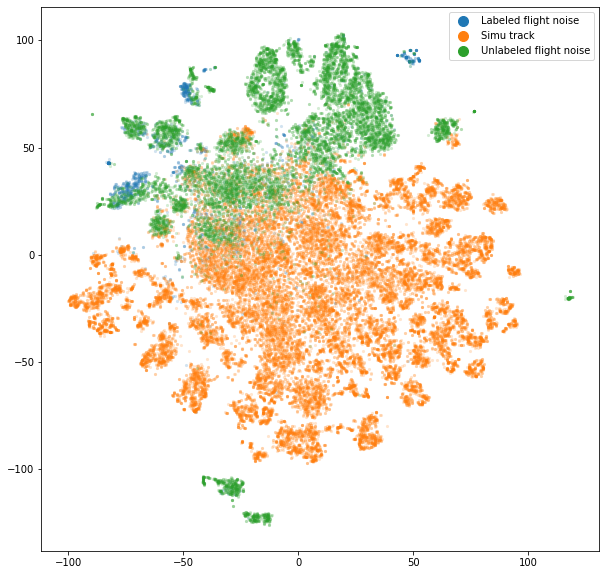

Labeled flight noise
   44573
#1f77b4
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv_-3_Labeled flight noise_0_0.png


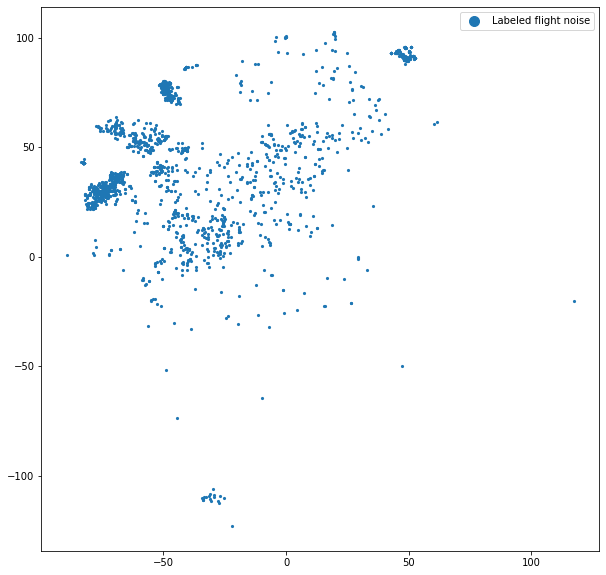

--------------------------------------------------
Simu track
   14551
#ff7f0e
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv_1_Simu track_5_5.png


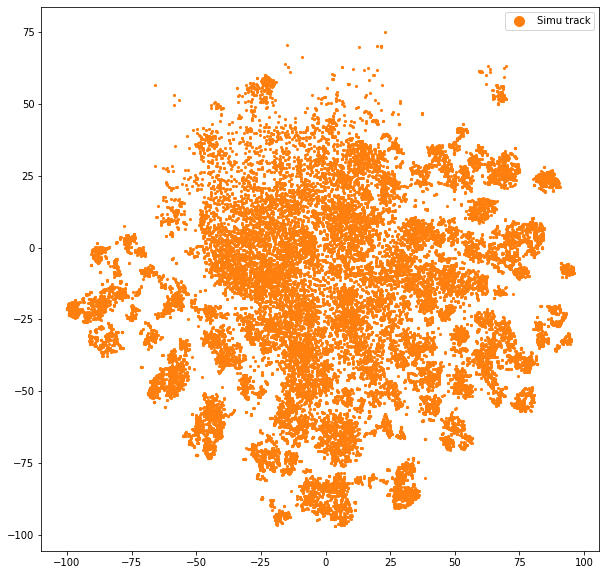

--------------------------------------------------
Unlabeled flight noise
   33622
#2ca02c
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv_-2_Unlabeled flight noise_6_6.png


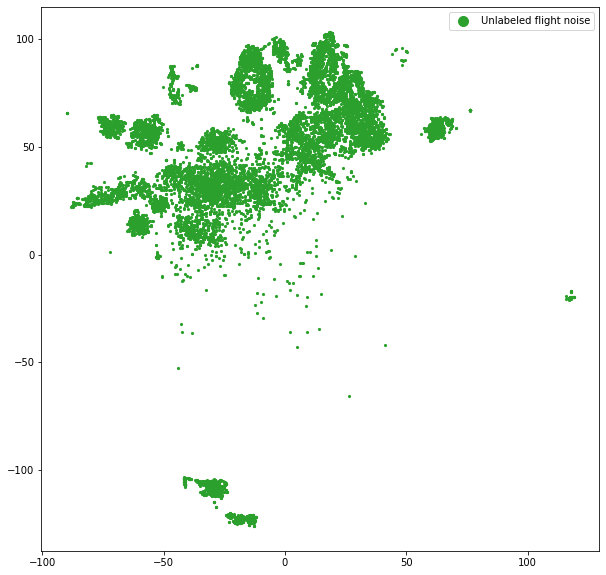

--------------------------------------------------


In [132]:
vis_data_X_tsne = learning_data__X__multicore_tsne_learning_data_all_rfecv_columns
vis_data_y_pred = None
# vis_data_y_pred = rfecv_selector_on_extra_trees_cls.predict(var_th_selector_on_scaled_train.transform(learning_data__X))
#vis_data_y_pred = learning_data__var_th_y_rfecv_pred_train

visualize_reduced_dimensions(
    vis_data_X_tsne, vis_data_y_pred, event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = 0.2,
    scatter_s=10, vis_by_class=False,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data__X__multicore_tsne_learning_data_all_rfecv__all_classes.png')
)

visualize_reduced_dimensions(
    vis_data_X_tsne, vis_data_y_pred, event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = 1,
    scatter_s=10, vis_by_class=True,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data__X__multicore_tsne_learning_data_all_rfecv_{class_number}_{class_label}_{i}_{class_name}.png')
)

2pix_line
   1778
--------------------------------------------------
bg_increased_suddenly
   1607
--------------------------------------------------
blob
   1530
--------------------------------------------------
blob_and_dots
   1785
--------------------------------------------------
bright_blob
   1723
--------------------------------------------------
cartesian_line
   1786
--------------------------------------------------
dot
   1437
--------------------------------------------------
dot_w_blob_behind
   1679
--------------------------------------------------
few_dots
   1717
--------------------------------------------------
large_blob
   1671
--------------------------------------------------
noise
   1735
--------------------------------------------------
noise_unspecified
   1779
--------------------------------------------------
noise_with_week_dot
   1788
--------------------------------------------------
persistent_dot
   1773
----------------------------------------------

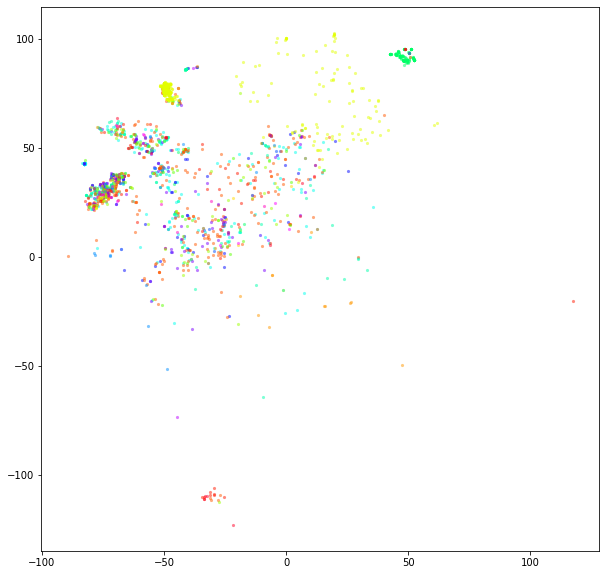

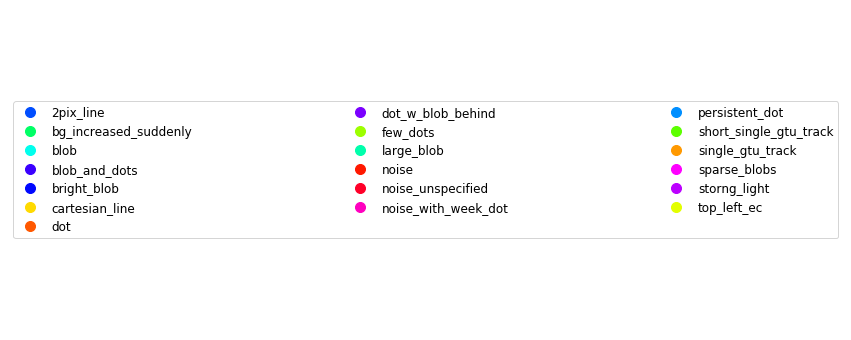

2pix_line
   1778
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_15_2pix_line_0_0.png


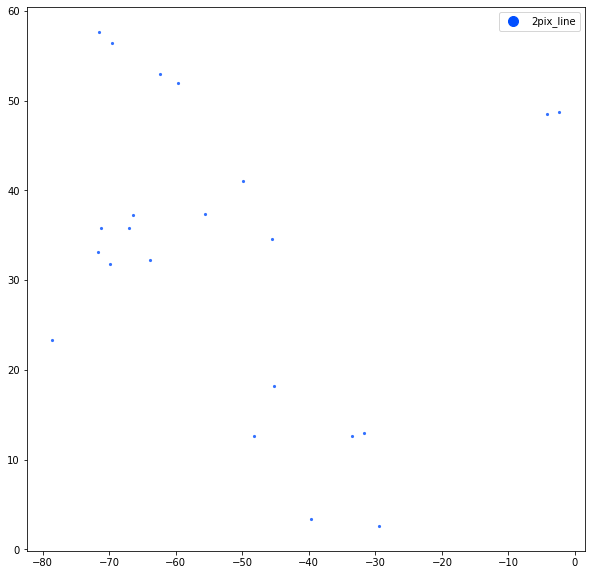

--------------------------------------------------
bg_increased_suddenly
   1607
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_10_bg_increased_suddenly_1_1.png


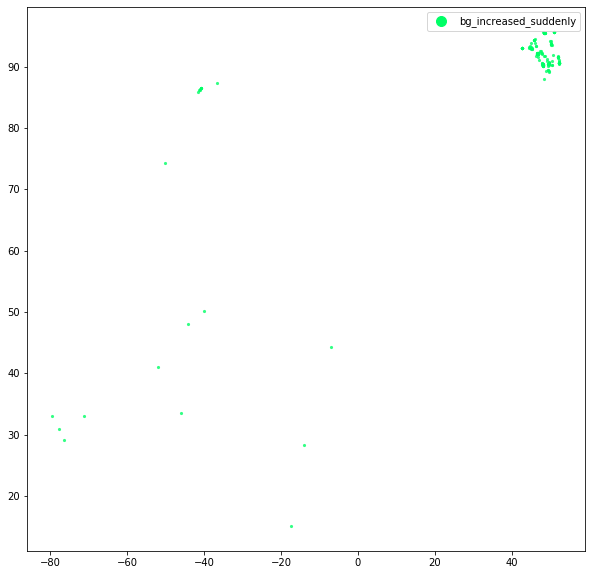

--------------------------------------------------
blob
   1530
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_12_blob_2_2.png


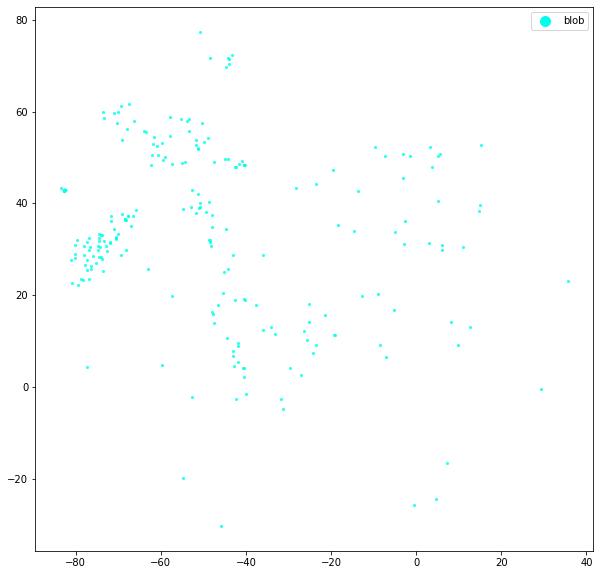

--------------------------------------------------
blob_and_dots
   1785
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_17_blob_and_dots_3_3.png


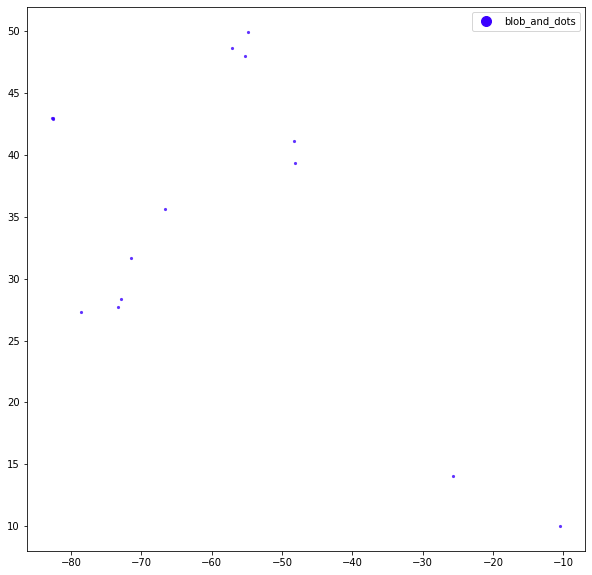

--------------------------------------------------
bright_blob
   1723
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_16_bright_blob_4_4.png


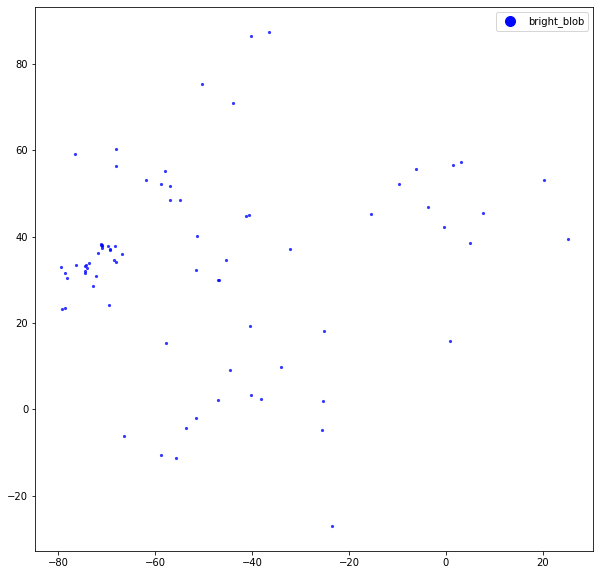

--------------------------------------------------
cartesian_line
   1786
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_4_cartesian_line_5_5.png


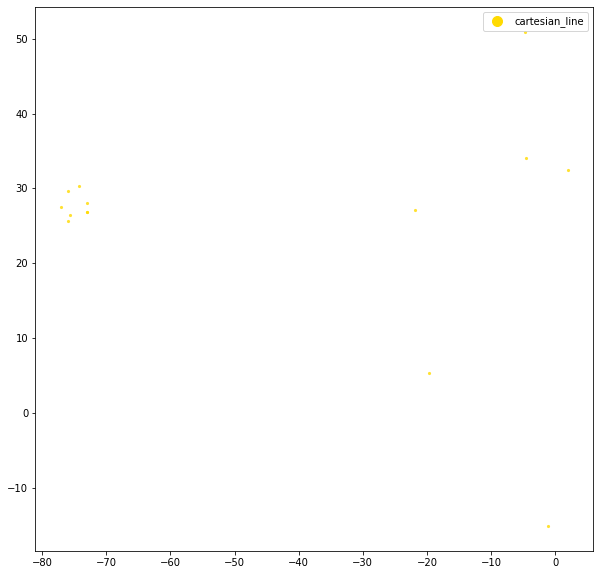

--------------------------------------------------
dot
   1437
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_2_dot_6_6.png


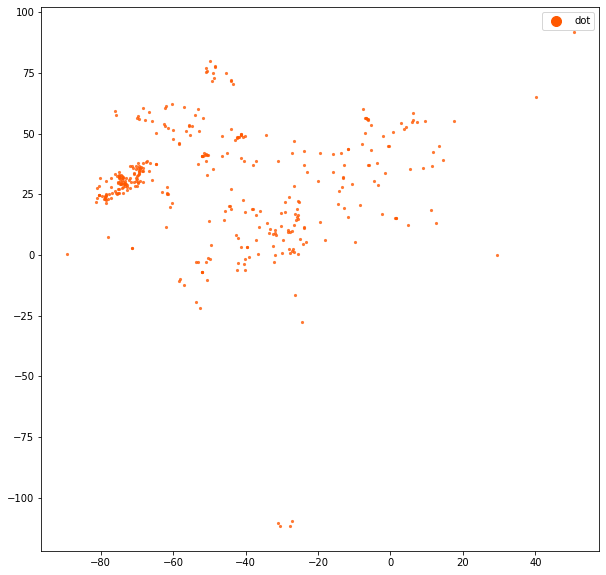

--------------------------------------------------
dot_w_blob_behind
   1679
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_18_dot_w_blob_behind_7_7.png


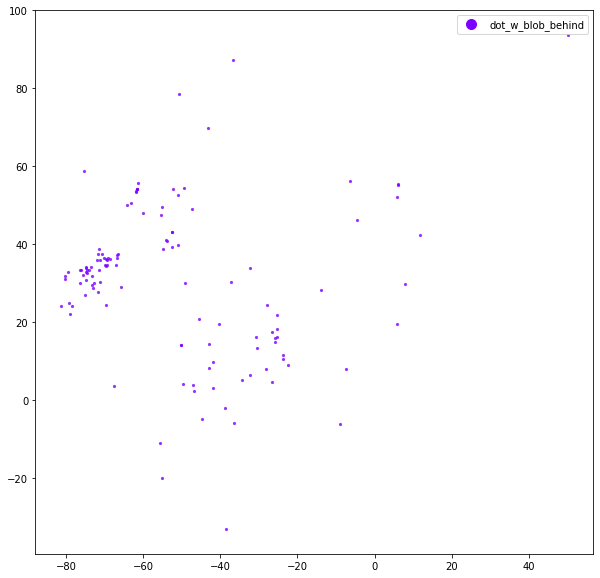

--------------------------------------------------
few_dots
   1717
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_6_few_dots_8_8.png


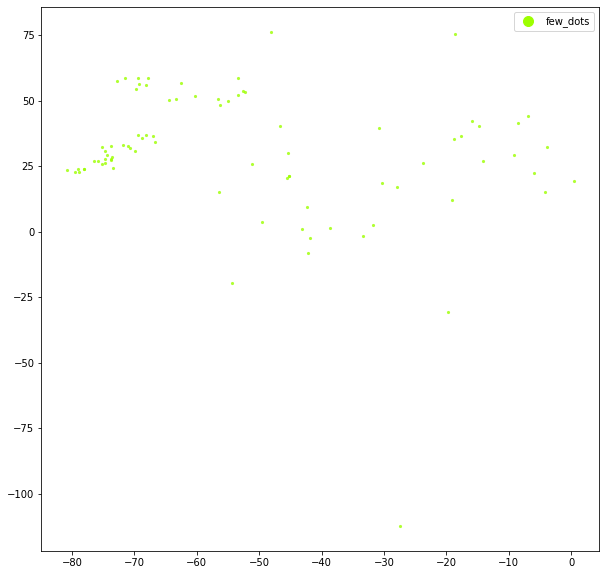

--------------------------------------------------
large_blob
   1671
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_11_large_blob_9_9.png


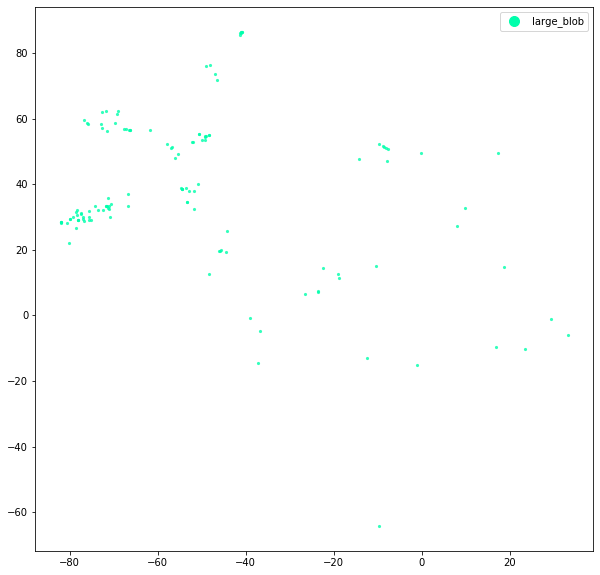

--------------------------------------------------
noise
   1735
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_1_noise_10_10.png


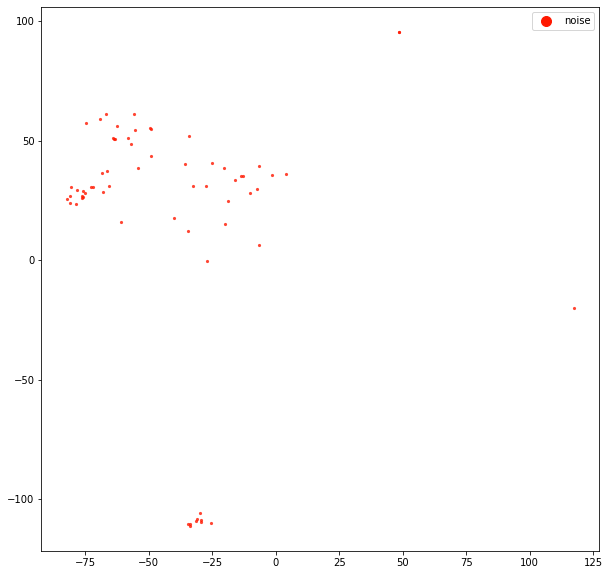

--------------------------------------------------
noise_unspecified
   1779
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_0_noise_unspecified_11_11.png


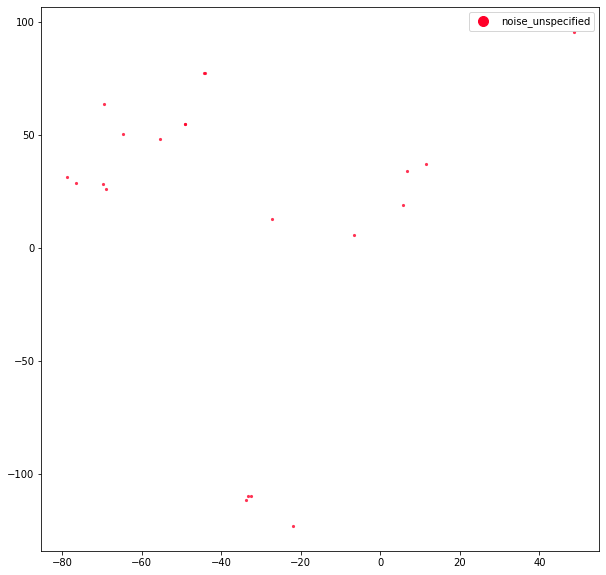

--------------------------------------------------
noise_with_week_dot
   1788
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_21_noise_with_week_dot_12_12.png


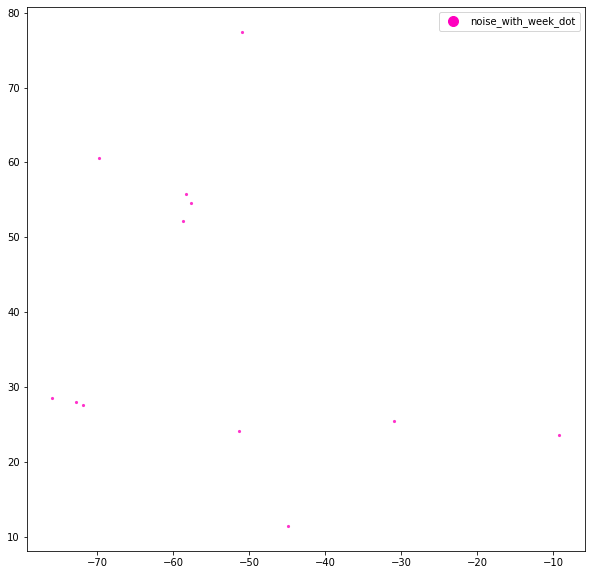

--------------------------------------------------
persistent_dot
   1773
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_14_persistent_dot_13_13.png


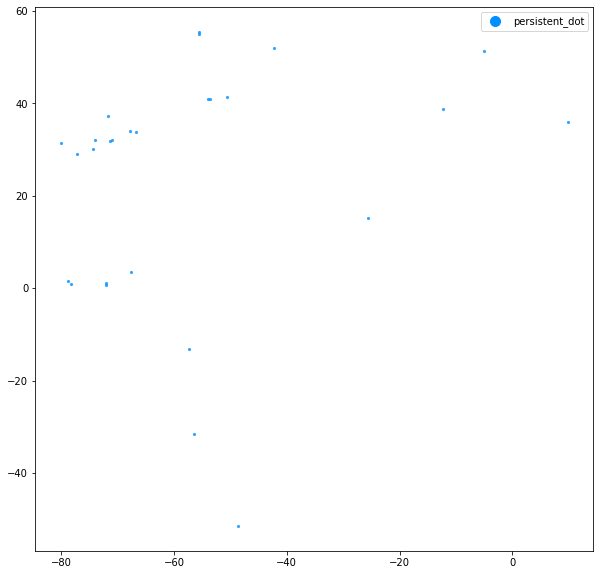

--------------------------------------------------
short_single_gtu_track
   1750
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_7_short_single_gtu_track_14_14.png


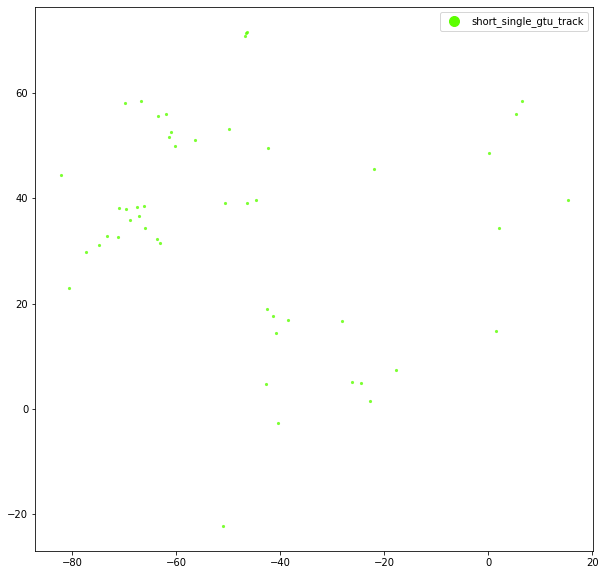

--------------------------------------------------
single_gtu_track
   1771
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_3_single_gtu_track_16_16.png


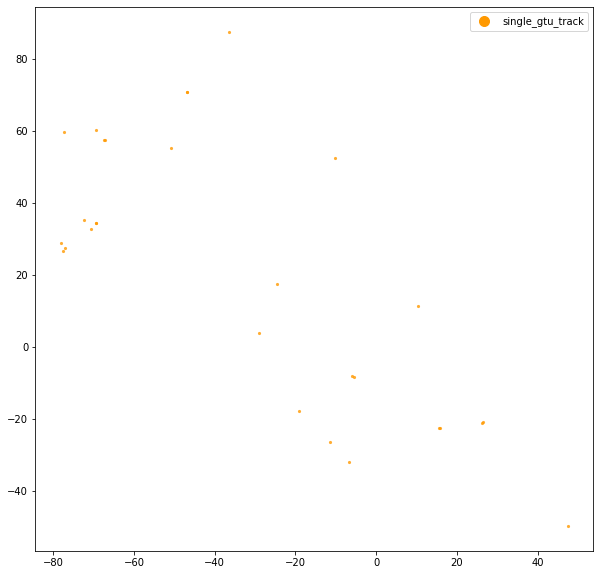

--------------------------------------------------
sparse_blobs
   1788
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_20_sparse_blobs_17_17.png


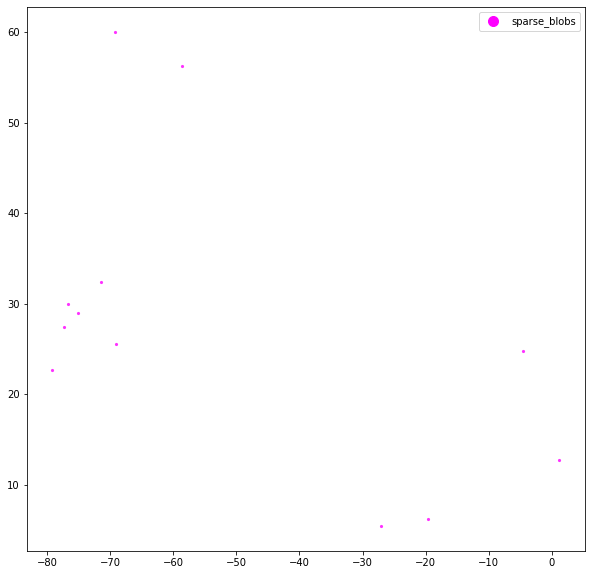

--------------------------------------------------
storng_light
   1798
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_19_storng_light_18_18.png


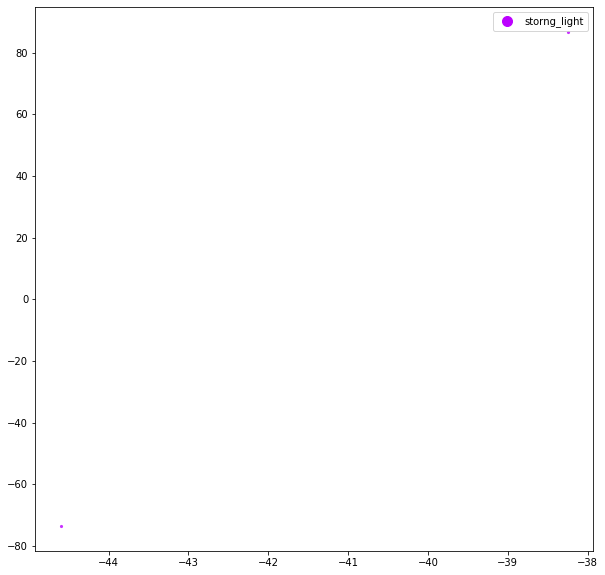

--------------------------------------------------
top_left_ec
   1505
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_5_top_left_ec_20_20.png


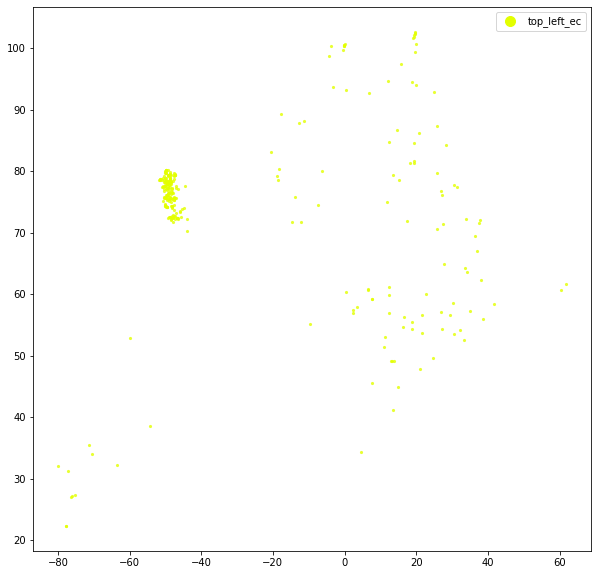

--------------------------------------------------


In [133]:
# learning_data__manual_classification_class
# EVENT_CLASSES
# 'lbl_noise_flight_df': EVENT_CLASS_LABLELED_NOISE_FLIGHT, 

vis_data_X_tsne = learning_data__X__multicore_tsne_learning_data_all_rfecv_columns
vis_data_y_pred = None #rfecv_selector_on_extra_trees_cls.predict(var_th_selector_on_scaled_train.transform(learning_data__X))
#vis_data_y_pred = learning_data__var_th_y_rfecv_pred_train


visualize_reduced_dimensions(
    vis_data_X_tsne[learning_data__source_class == EVENT_CLASS_LABLELED_NOISE_FLIGHT], 
    vis_data_y_pred, 
    {v:k for k,v in EVENT_CLASSES.items()},
    learning_data__manual_classification_class[learning_data__source_class == EVENT_CLASS_LABLELED_NOISE_FLIGHT],
    event_class_alpha = 0.5,
    scatter_s=10, color_cycler=False,
    vis_by_class=False, subset_marker_format='o',
    size_inches=(10,10), separate_legend=True,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise.png')
)

print('='*50)

visualize_reduced_dimensions(
    vis_data_X_tsne[learning_data__source_class == EVENT_CLASS_LABLELED_NOISE_FLIGHT], 
    vis_data_y_pred, 
    {v:k for k,v in EVENT_CLASSES.items()},
    learning_data__manual_classification_class[learning_data__source_class == EVENT_CLASS_LABLELED_NOISE_FLIGHT],
    event_class_alpha = 0.8,
    scatter_s=10, color_cycler=False,
    vis_by_class=True, subset_marker_format='o',
    size_inches=(10,10),
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data__X__multicore_tsne_learning_data_all_rfecv__labeled_noise_{class_number}_{class_label}_{i}_{class_name}.png')
)


10 features
Labeled flight noise
   44573
#1f77b4
--------------------------------------------------
Simu track
   14551
#ff7f0e
--------------------------------------------------
Unlabeled flight noise
   33622
#2ca02c
--------------------------------------------------
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__pca_10_rfecv__all_classes.png


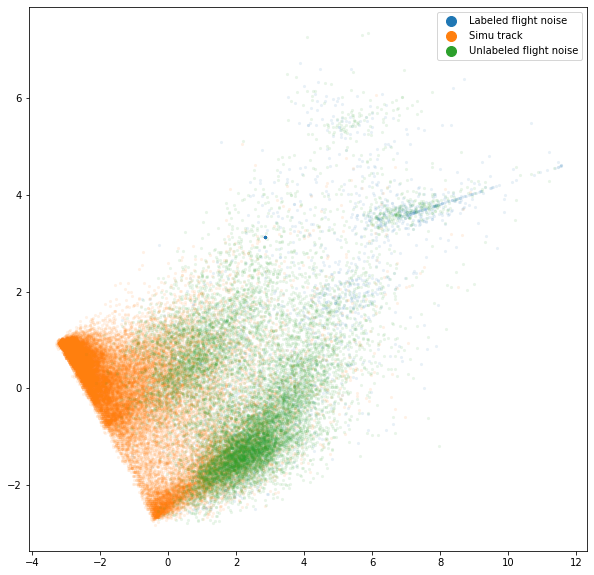

------------------------------------------------------------
30 features
Labeled flight noise
   44573
#1f77b4
--------------------------------------------------
Simu track
   14551
#ff7f0e
--------------------------------------------------
Unlabeled flight noise
   33622
#2ca02c
--------------------------------------------------
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__pca_30_rfecv__all_classes.png


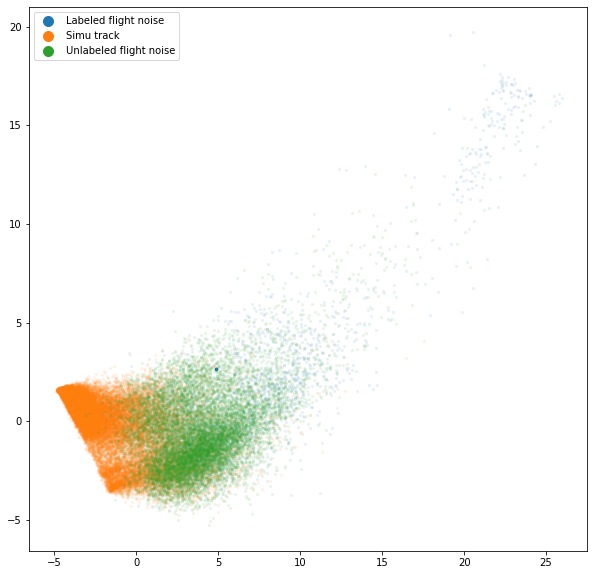

------------------------------------------------------------
50 features
Labeled flight noise
   44573
#1f77b4
--------------------------------------------------
Simu track
   14551
#ff7f0e
--------------------------------------------------
Unlabeled flight noise
   33622
#2ca02c
--------------------------------------------------
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__pca_50_rfecv__all_classes.png


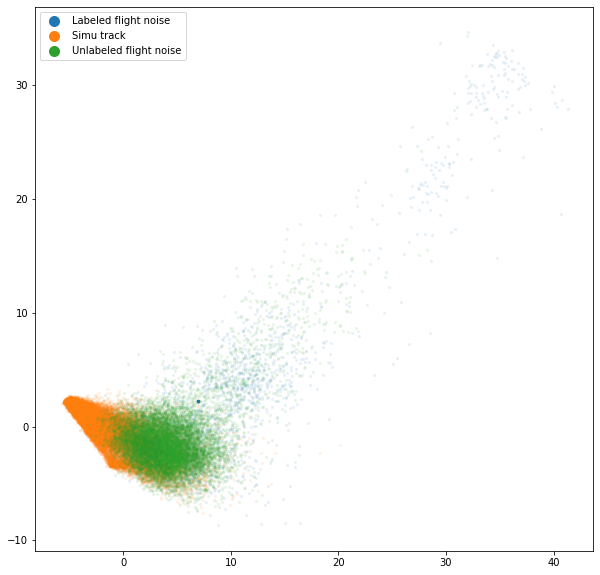

------------------------------------------------------------
70 features
Labeled flight noise
   44573
#1f77b4
--------------------------------------------------
Simu track
   14551
#ff7f0e
--------------------------------------------------
Unlabeled flight noise
   33622
#2ca02c
--------------------------------------------------
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__pca_70_rfecv__all_classes.png


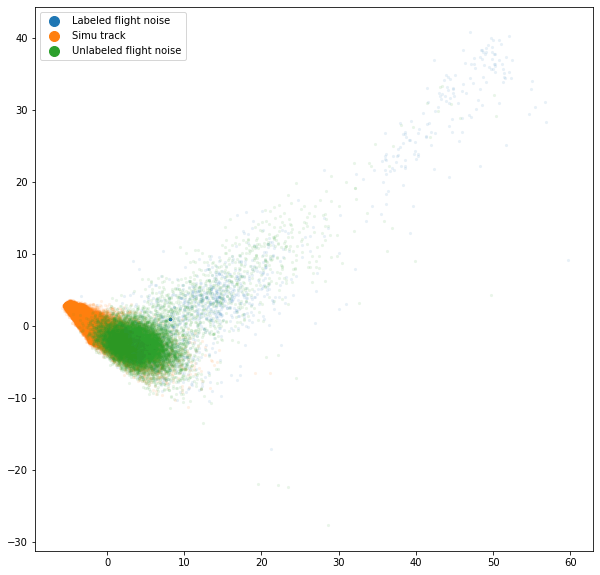

------------------------------------------------------------
90 features
Labeled flight noise
   44573
#1f77b4
--------------------------------------------------
Simu track
   14551
#ff7f0e
--------------------------------------------------
Unlabeled flight noise
   33622
#2ca02c
--------------------------------------------------
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__pca_90_rfecv__all_classes.png


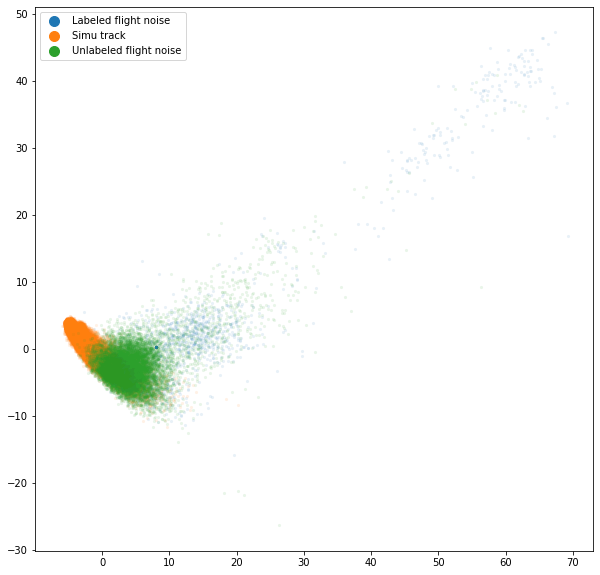

------------------------------------------------------------
110 features
Labeled flight noise
   44573
#1f77b4
--------------------------------------------------
Simu track
   14551
#ff7f0e
--------------------------------------------------
Unlabeled flight noise
   33622
#2ca02c
--------------------------------------------------
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__pca_110_rfecv__all_classes.png


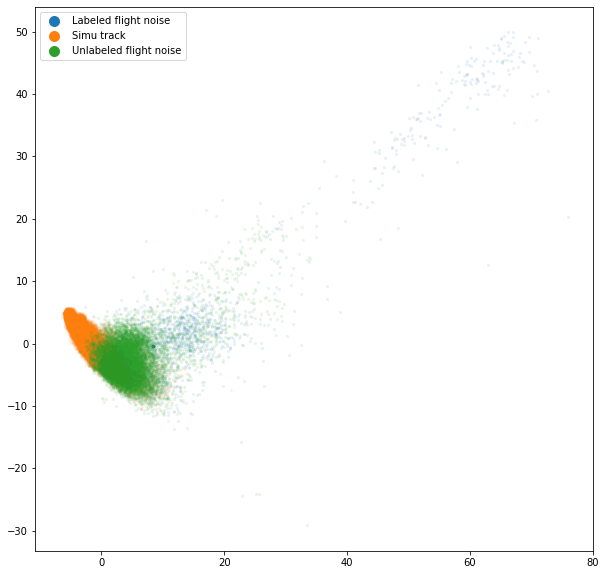

------------------------------------------------------------
130 features
Labeled flight noise
   44573
#1f77b4
--------------------------------------------------
Simu track
   14551
#ff7f0e
--------------------------------------------------
Unlabeled flight noise
   33622
#2ca02c
--------------------------------------------------
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__pca_130_rfecv__all_classes.png


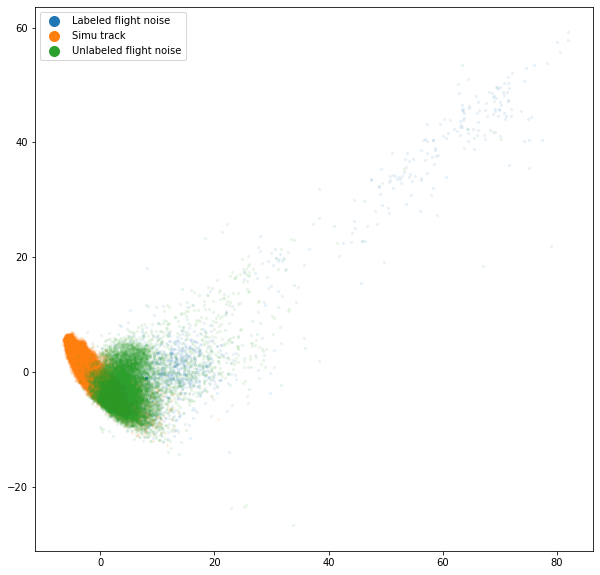

------------------------------------------------------------
150 features
Labeled flight noise
   44573
#1f77b4
--------------------------------------------------
Simu track
   14551
#ff7f0e
--------------------------------------------------
Unlabeled flight noise
   33622
#2ca02c
--------------------------------------------------
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__pca_150_rfecv__all_classes.png


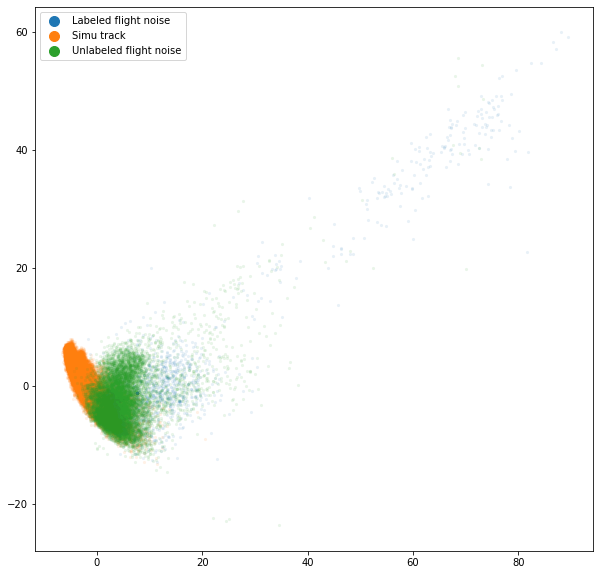

------------------------------------------------------------
170 features
Labeled flight noise
   44573
#1f77b4
--------------------------------------------------
Simu track
   14551
#ff7f0e
--------------------------------------------------
Unlabeled flight noise
   33622
#2ca02c
--------------------------------------------------
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__pca_170_rfecv__all_classes.png


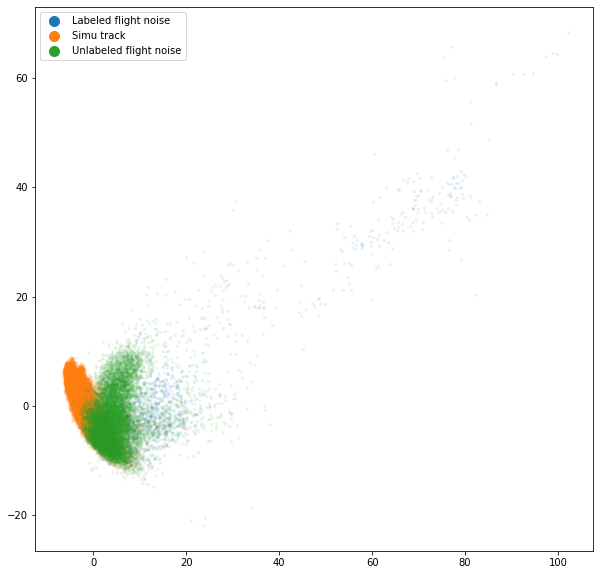

------------------------------------------------------------
190 features
Labeled flight noise
   44573
#1f77b4
--------------------------------------------------
Simu track
   14551
#ff7f0e
--------------------------------------------------
Unlabeled flight noise
   33622
#2ca02c
--------------------------------------------------
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__pca_190_rfecv__all_classes.png


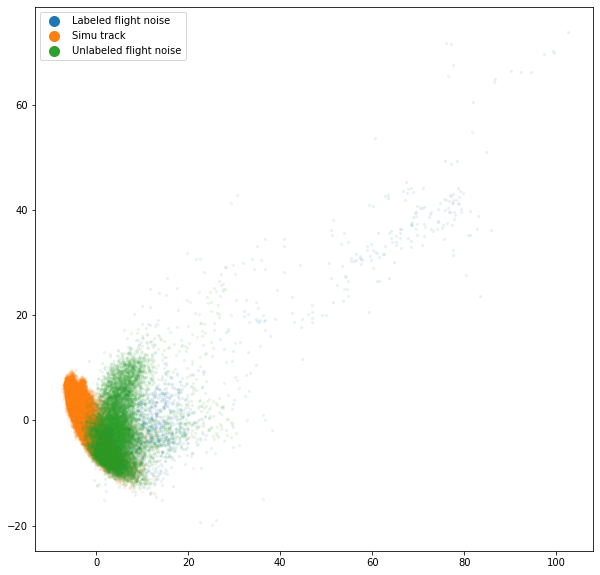

------------------------------------------------------------


In [134]:
for n_features in range(10,201,20):
    
    print(n_features, 'features')
    
    pca_on_learning_data_n_rfecv_columns = \
        sklearn.decomposition.PCA(n_components=2)

    learning_data__X__pca_learning_data_n_rfecv_columns = \
        pca_on_learning_data_n_rfecv_columns.fit_transform(
            standard_scaler_all_rfecv_feat_all_data.transform(
                rfecv_selector_on_extra_trees_cls.transform(    
                    var_th_selector_on_scaled_train.transform(learning_data__X)
                )
            ).T[rfecv_selector_on_extra_trees__column_indices__sorted[0:n_features]].T   # 232.T[232[0:N]].T
        )

#     vis_data_y_pred = rfecv_selector_on_extra_trees_cls.predict(var_th_selector_on_scaled_train.transform(learning_data__X))
    vis_data_y_pred = None
    visualize_reduced_dimensions(
        learning_data__X__pca_learning_data_n_rfecv_columns, vis_data_y_pred, 
        event_source_class_number_to_label_mapping,
        learning_data__source_class,
        event_class_alpha = 0.1,
        scatter_s=10,
        savefig_pathname=os.path.join(
            data_snippets_dir, 
            'learning_data__X__pca_{}_rfecv__all_classes.png'.format(n_features))
    )
    
    print('-'*60)

In [135]:
pca_on_learning_data_rfecv_columns = \
    sklearn.decomposition.PCA(n_components=2)

learning_data__X__pca_learning_data_rfecv_columns = \
    pca_on_learning_data_rfecv_columns.fit_transform(
        learning_data__scaled_rfecv_var_th_X
    )

Labeled flight noise
   44573
#1f77b4
--------------------------------------------------
Simu track
   14551
#ff7f0e
--------------------------------------------------
Unlabeled flight noise
   33622
#2ca02c
--------------------------------------------------
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__pca_all_rfecv__all_classes.png


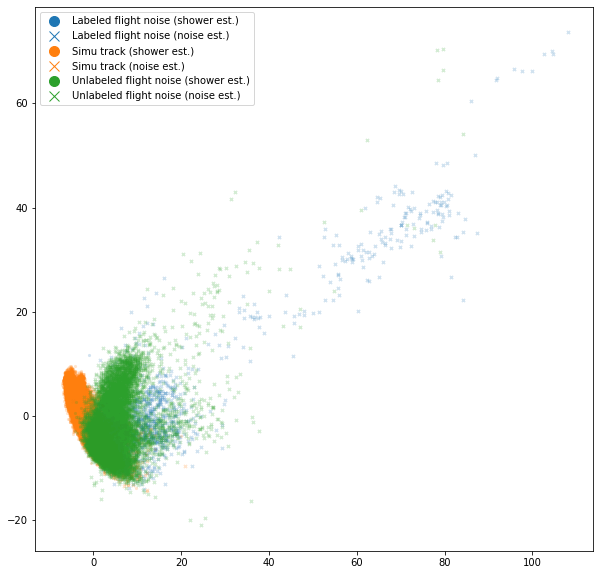

In [136]:
vis_data_y_pred = rfecv_selector_on_extra_trees_cls.predict(
    var_th_selector_on_scaled_train.transform(learning_data__X))
visualize_reduced_dimensions(
    learning_data__X__pca_learning_data_rfecv_columns, vis_data_y_pred, 
    event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = 0.2,
    scatter_s=10,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data__X__pca_all_rfecv__all_classes.png')
)

In [137]:
lda_on_learning_data_60_rfecv_columns_train = \
    sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=5)

# Intentionally train

learning_data__X__lda_learning_data_60_rfecv_columns_train = \
lda_on_learning_data_60_rfecv_columns_train.fit_transform(
#     tsne_on_learning_data_60_rfecv_columns_scaler_train.fit_transform(  # intentionally
        rfecv_selector_on_extra_trees_cls.transform(
            learning_data__var_th_X_train
        ).T[   # 232.T[
            rfecv_selector_on_extra_trees__column_indices__sorted[0:60]].T              #       232[0:60]].T
#     )
    ,
    learning_data__y_train
)


# learning_data__X__lda_learning_data_60_rfecv_columns_train = \
#     lda_on_learning_data_60_rfecv_columns_train.transform(
#         tsne_on_learning_data_60_rfecv_columns_scaler_train.fit_transform(  # intentionally
#             rfecv_selector_on_extra_trees_cls.transform(
#                 learning_data__var_th_X_train
#             ).T[   # 232.T[
#                 rfecv_selector_on_extra_trees__column_indices__sorted[0:60]].T              #       232[0:60]].T
#         ))

# test
learning_data__X__lda_learning_data_60_rfecv_columns_test = \
    lda_on_learning_data_60_rfecv_columns_train.transform(
#         tsne_on_learning_data_60_rfecv_columns_scaler_train.transform(  # intentionally
            rfecv_selector_on_extra_trees_cls.transform(
                learning_data__var_th_X_test
            ).T[   # 232.T[
                rfecv_selector_on_extra_trees__column_indices__sorted[0:60]].T              #       232[0:60]].T
#         )
    )

In [144]:
lda_on_learning_data_60_rfecv_columns_train_2components = \
    sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=2)

# Intentionally train

learning_data__X__lda_learning_data_60_rfecv_columns_train_2components = \
lda_on_learning_data_60_rfecv_columns_train_2components.fit_transform(
#     tsne_on_learning_data_60_rfecv_columns_scaler_train.fit_transform(  # intentionally
        rfecv_selector_on_extra_trees_cls.transform(
            learning_data__var_th_X_train
        ).T[   # 232.T[
            rfecv_selector_on_extra_trees__column_indices__sorted[0:60]].T              #       232[0:60]].T
#     )
    ,
    learning_data__y_train
)


# learning_data__X__lda_learning_data_60_rfecv_columns_train = \
#     lda_on_learning_data_60_rfecv_columns_train.transform(
#         tsne_on_learning_data_60_rfecv_columns_scaler_train.fit_transform(  # intentionally
#             rfecv_selector_on_extra_trees_cls.transform(
#                 learning_data__var_th_X_train
#             ).T[   # 232.T[
#                 rfecv_selector_on_extra_trees__column_indices__sorted[0:60]].T              #       232[0:60]].T
#         ))

# test
learning_data__X__lda_learning_data_60_rfecv_columns_test_2components = \
    lda_on_learning_data_60_rfecv_columns_train_2components.transform(
#         tsne_on_learning_data_60_rfecv_columns_scaler_train.transform(  # intentionally
            rfecv_selector_on_extra_trees_cls.transform(
                learning_data__var_th_X_test
            ).T[   # 232.T[
                rfecv_selector_on_extra_trees__column_indices__sorted[0:60]].T              #       232[0:60]].T
#         )
    )

In [140]:
learning_data__X__lda_learning_data_60_rfecv_columns_test.shape

(18550, 1)

In [138]:
lda_on_learning_data__columns_train = \
    sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=5)

# preventing collinear variables
feat_indices = \
    rfecv_selector_on_extra_trees__column_indices__sorted
#     [0:50] \
#     + rfecv_selector_on_extra_trees__column_indices__sorted[51:61] \
#     + rfecv_selector_on_extra_trees__column_indices__sorted[62:82] \
#     + rfecv_selector_on_extra_trees__column_indices__sorted[83:101] \
#     + rfecv_selector_on_extra_trees__column_indices__sorted[102:148] \
#     + rfecv_selector_on_extra_trees__column_indices__sorted[149:164] \
#     + rfecv_selector_on_extra_trees__column_indices__sorted[165:171] \
#     + rfecv_selector_on_extra_trees__column_indices__sorted[172:] \

# Intentionally train

learning_data__X__lda_learning_data_all_rfecv_columns_train = \
lda_on_learning_data__columns_train.fit_transform(
#     tsne_on_learning_data__columns_scaler_train.fit_transform(  # intentionally
        rfecv_selector_on_extra_trees_cls.transform(
            learning_data__var_th_X_train
        ).T[   # 232.T[
            feat_indices].T           # 232[0:60]].T
#     )
    ,
    learning_data__y_train
)


# learning_data__X__lda_learning_data__columns_train = \
#     lda_on_learning_data__columns_train.transform(
#         tsne_on_learning_data__columns_scaler_train.fit_transform(  # intentionally
#             rfecv_selector_on_extra_trees_cls.transform(
#                 learning_data__var_th_X_train
#             )
#         ))

# test

learning_data__X__lda_learning_data_all_rfecv_columns_test = \
    lda_on_learning_data__columns_train.transform(
#         tsne_on_learning_data__columns_scaler_train.transform(  # intentionally
            rfecv_selector_on_extra_trees_cls.transform(
                learning_data__var_th_X_test
            ).T[feat_indices].T
#         )
    )

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [139]:
lda_on_learning_data_60_rfecv_columns_train = \
    sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=5)

# Intentionally train

learning_data__X__lda_learning_data_60_rfecv_columns_train = \
lda_on_learning_data_60_rfecv_columns_train.fit_transform(
#     tsne_on_learning_data_60_rfecv_columns_scaler_train.fit_transform(  # intentionally
        rfecv_selector_on_extra_trees_cls.transform(
            learning_data__var_th_X_train
        ).T[   # 232.T[
            rfecv_selector_on_extra_trees__column_indices__sorted[0:60]].T              #       232[0:60]].T
#     )
    ,
    learning_data__y_train
)


# learning_data__X__lda_learning_data_60_rfecv_columns_train = \
#     lda_on_learning_data_60_rfecv_columns_train.transform(
#         tsne_on_learning_data_60_rfecv_columns_scaler_train.fit_transform(  # intentionally
#             rfecv_selector_on_extra_trees_cls.transform(
#                 learning_data__var_th_X_train
#             ).T[   # 232.T[
#                 rfecv_selector_on_extra_trees__column_indices__sorted[0:60]].T              #       232[0:60]].T
#         ))

# test
learning_data__X__lda_learning_data_60_rfecv_columns_test = \
    lda_on_learning_data_60_rfecv_columns_train.transform(
#         tsne_on_learning_data_60_rfecv_columns_scaler_train.transform(  # intentionally
            rfecv_selector_on_extra_trees_cls.transform(
                learning_data__var_th_X_test
            ).T[   # 232.T[
                rfecv_selector_on_extra_trees__column_indices__sorted[0:60]].T              #       232[0:60]].T
#         )
    )

In [149]:
def vis_reduced_dimensions_1d(vis_data_X, source_class_arr, 
                              xlabel='Reduced space feature value', show=True, 
                              class_alpha=0.5, yscale='linear', bins=30, figsize=None, 
                              xlim=None, ylim=None, data_snippets_dir=data_snippets_dir, 
                              savefig_name=None, hist_range=None,
                              cm = plt.cm.Set1 #plt.cm.gist_rainbow
                             ):

    # event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
    event_classes_for_cm = np.unique(source_class_arr)
    cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
    
#     vis_data_X_tsne = learning_data__X__tsne_learning_data_60_rfecv_columns
#     vis_data_y_pred = learning_data__var_th_y_rfecv_pred_train

    plt.close('all')
    
#     hist_labels = []
#     hist_pathcolls = []

    for class_number, class_name in sorted(event_source_class_number_to_label_mapping.items(),key=lambda x: x[1]):
    #         if class_name == 'unclassified' and not do_unclassified:
    #             continue

        class_number_mask = (source_class_arr == class_number)

    #         flight_df_nonan_subset = flight_df_nonan[flight_df_nonan['manual_classification_class_number']==class_number]

        if np.count_nonzero(class_number_mask) <= 0:
            continue

        subset_X = vis_data_X[class_number_mask]
    #             subset_y_pred = vis_data_y_pred[class_number_mask]

        class_color = cm(cm_norm(class_number))

    #         if class_name == 'unclassified':
    #             class_color = unclassified_class_color
    #             event_class_alpha = unclassified_class_alpha
    #         else:
    #             class_color = cm(cm_norm(class_number))
    #             event_class_alpha = 0.7

        _t_hist_range = (np.min(vis_data_X), np.max(vis_data_X))
        if hist_range is None:
            _t_hist_range = hist_range
    
        plt.hist(subset_X, bins=bins, color=class_color, range=hist_range, 
                 label=class_name, alpha=class_alpha)
        plt.xlabel(xlabel)
        plt.gca().set_yscale(yscale)
        
        if figsize is not None:
            plt.gcf().set_size_inches(*figsize)
        if xlim is not None:
            plt.gca().set_xlim(*xlim)
        if ylim is not None:
            plt.gca().set_ylim(*ylim)

#         hist_labels.append(class_name)
#         hist_pathcolls.append(pathcoll)

    #     if show_annotations:
    #         add_tsne_shower_xy_axes(f, ax, flight_df_nonan, annotation_side_frac, annotation_limit=annotation_limit)

#         ax.legend(r2dim_scatter_pathcolls, r2dim_scatter_labels)

        if savefig_name is not None:
            if not savefig_name.endswith('.png') and not savefig_name.endswith('.svg'):
                savefig_name += '.svg'
            savefig_pathname = os.path.join(data_snippets_dir, savefig_name)
            print('Saving figure: {}'.format(savefig_pathname))
            plt.savefig(savefig_pathname, dpi=150)
        
    plt.legend()
    
    if show:    
        plt.show()

Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_60_rfecv_columns_train.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_60_rfecv_columns_train.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_60_rfecv_columns_train.png


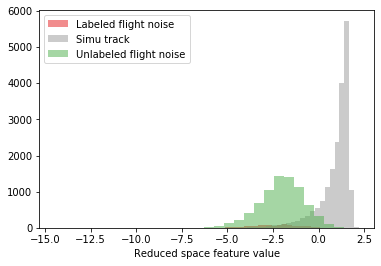

In [150]:
# plt.hist(learning_data__X__lda_learning_data_60_rfecv_columns_train, bins=30)
# plt.show()

# vis_data_X = learning_data__X__lda_learning_data_60_rfecv_columns_train
# source_class_arr = learning_data__source_class_train

vis_reduced_dimensions_1d(learning_data__X__lda_learning_data_60_rfecv_columns_train,
                          learning_data__source_class_train, 
                          savefig_name='learning_data__X__lda_learning_data_60_rfecv_columns_train.png')

Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_60_rfecv_columns_train.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_60_rfecv_columns_train.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_60_rfecv_columns_train.png


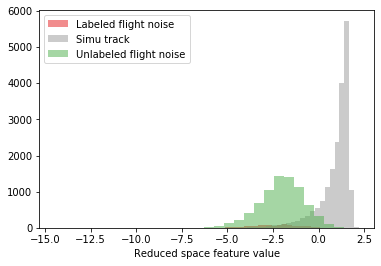

In [151]:
# plt.hist(learning_data__X__lda_learning_data_60_rfecv_columns_train, bins=30)
# plt.show()

# vis_data_X = learning_data__X__lda_learning_data_60_rfecv_columns_train
# source_class_arr = learning_data__source_class_train

vis_reduced_dimensions_1d(learning_data__X__lda_learning_data_60_rfecv_columns_train_2components,
                          learning_data__source_class_train, 
                          savefig_name='learning_data__X__lda_learning_data_60_rfecv_columns_train.png')

Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_60_rfecv_columns_test.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_60_rfecv_columns_test.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_60_rfecv_columns_test.png


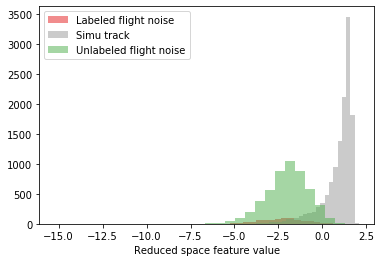

In [157]:
# plt.hist(learning_data__X__lda_learning_data_60_rfecv_columns_test, bins=30)
# plt.show()

vis_reduced_dimensions_1d(learning_data__X__lda_learning_data_60_rfecv_columns_test,
                          learning_data__source_class_test,
                          savefig_name='learning_data__X__lda_learning_data_60_rfecv_columns_test.png'
                         )

Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_60_rfecv_columns_test_logy.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_60_rfecv_columns_test_logy.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_60_rfecv_columns_test_logy.png


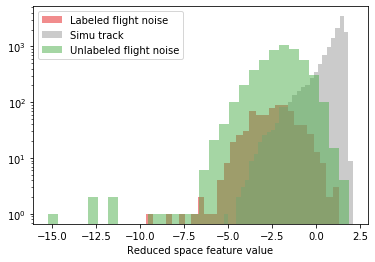

In [158]:
# plt.hist(learning_data__X__lda_learning_data_60_rfecv_columns_test, bins=30)
# plt.show()

vis_reduced_dimensions_1d(learning_data__X__lda_learning_data_60_rfecv_columns_test,
                          learning_data__source_class_test,
                          yscale='log',
                          savefig_name='learning_data__X__lda_learning_data_60_rfecv_columns_test_logy.png'
                         )

Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_all_rfecv_columns_train.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_all_rfecv_columns_train.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_all_rfecv_columns_train.png


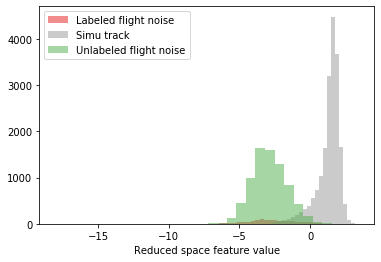

In [153]:
vis_reduced_dimensions_1d(learning_data__X__lda_learning_data_all_rfecv_columns_train,
                          learning_data__source_class_train,
                          savefig_name='learning_data__X__lda_learning_data_all_rfecv_columns_train.png'
                         )

Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_all_rfecv_columns_test.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_all_rfecv_columns_test.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_all_rfecv_columns_test.png


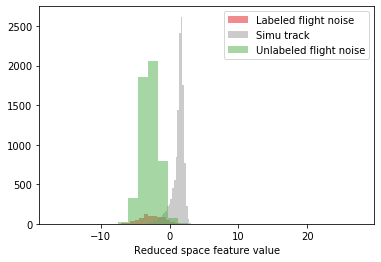

In [155]:
vis_reduced_dimensions_1d(learning_data__X__lda_learning_data_all_rfecv_columns_test,
                          learning_data__source_class_test,
                          savefig_name='learning_data__X__lda_learning_data_all_rfecv_columns_test.png'
                         )

Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_all_rfecv_columns_test_logy.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_all_rfecv_columns_test_logy.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_all_rfecv_columns_test_logy.png


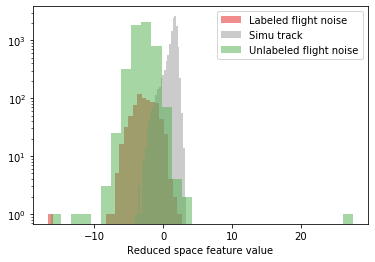

In [159]:
vis_reduced_dimensions_1d(learning_data__X__lda_learning_data_all_rfecv_columns_test,
                          learning_data__source_class_test,
                          yscale='log',
                          savefig_name='learning_data__X__lda_learning_data_all_rfecv_columns_test_logy.png'
                         )

Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_all_rfecv_columns_test_-12_10.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_all_rfecv_columns_test_-12_10.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_all_rfecv_columns_test_-12_10.png


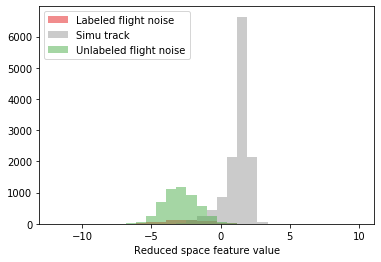

In [156]:
vis_reduced_dimensions_1d(learning_data__X__lda_learning_data_all_rfecv_columns_test,
                          learning_data__source_class_test,
                          hist_range=(-12, 10),
                          savefig_name='learning_data__X__lda_learning_data_all_rfecv_columns_test_-12_10.png'
                         )

Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_all_rfecv_columns_test_-12_10_logy.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_all_rfecv_columns_test_-12_10_logy.png
Saving figure: ver4_machine_learning_w_labeled_flight_201906122/learning_data__X__lda_learning_data_all_rfecv_columns_test_-12_10_logy.png


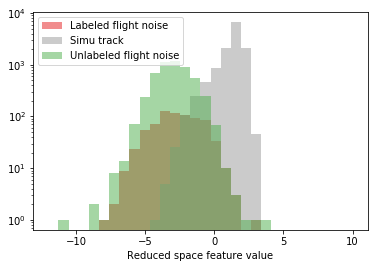

In [160]:
vis_reduced_dimensions_1d(learning_data__X__lda_learning_data_all_rfecv_columns_test,
                          learning_data__source_class_test,
                          hist_range=(-12, 10),
                          yscale='log',
                          savefig_name='learning_data__X__lda_learning_data_all_rfecv_columns_test_-12_10_logy.png'
                         )

### Performance of the ExtraTreesClassifier model with RFECV features

In [161]:
y_test = learning_data__y_test
y_test_pred = rfecv_selector_on_extra_trees_cls.predict(learning_data__var_th_X_test)

print(sklearn.metrics.confusion_matrix(
    y_test, 
    y_test_pred))

print_accuracy_cls_report(
    y_test, 
    y_test_pred)

labeled_data_cls_stats = \
    print_labeled_data_cls_stats(
        mask_arr_test=learning_data__lbl_noise_flight_mask_arr_test,
        y_test=y_test,
        y_test_pred=y_test_pred)

[[ 5765   116]
 [  752 11917]]
Accuracy score:
0.95

Classification report:
             precision    recall  f1-score   support

      noise       0.88      0.98      0.93      5881
 air shower       0.99      0.94      0.96     12669

avg / total       0.96      0.95      0.95     18550

Accuracy score (specificity)0.96
Num. negative               741
Num. true negative          709
Num. false positive         32
Specificity                 0.96
Fallout                     0.04


## Recognition efficiency (RFECV model)

### Test set sensitivity as function of the energy

In [162]:
extra_trees_cls_on_train_rfecv__test__numbers_by_energy = \
    score_by_column(
        rfecv_selector_on_extra_trees_cls, 
        learning_data__var_th_X_test[learning_data__simu_shower_track_mask_arr_test], 
        learning_data__y_test[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'etruth_trueenergy')

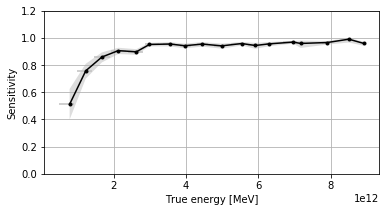

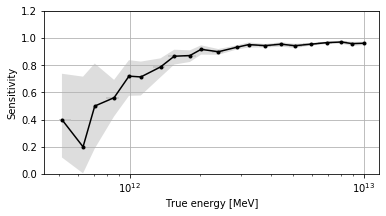

In [163]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax, errbr = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
            plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
            calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
            figsize=(6,3), ylim=(0,1.2), show=False)
    ax.grid()
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'Test set sensitivity as function of the energy - {}.svg'.format(xscale)), dpi=150)
    plt.show()

### Number of true positivie and positive samples as function of the energy

#### Number of positive samples as function of the energy

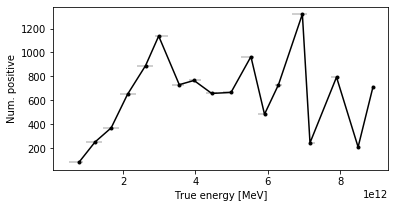

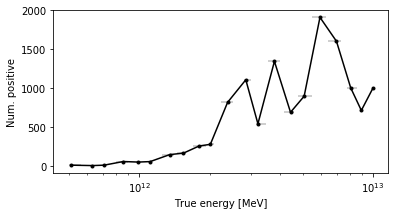

In [164]:
for xscale in ('linear', 'log'):
    fig, ax, errbr = \
        plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
                             plotted_stat='num_positive', num_steps = 20, xscale=xscale,
                             xlabel = 'True energy [MeV]', ylabel = 'Num. positive', 
                             figsize =(6,3))
    ax.grid()
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'Number of positive samples as function of the energy - {}.svg'.format(xscale)), dpi=150)
    

##### Number of true positive samples as function of the energy

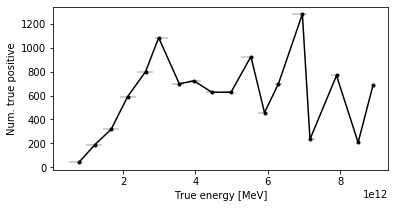

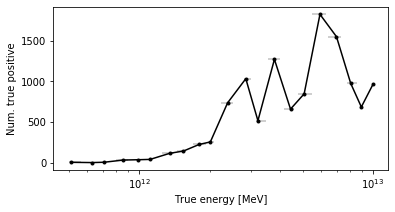

In [165]:
for xscale in ('linear', 'log'):
    fig, ax, errbr = \
        plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
                             plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
                             xlabel = 'True energy [MeV]', ylabel = 'Num. true positive', 
                             figsize = (6,3), show=False)
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'Number of true positive samples as function of the energy - {}.svg'.format(xscale)), dpi=150)
    plt.show()

##### Number of true positive or positive samples as function of the energy - comparison

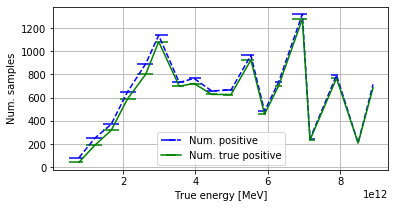

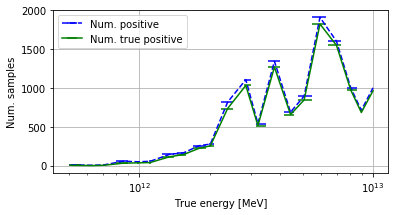

In [166]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
            figsize = (6,3), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(6,3), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    ax.grid()
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'Number of true positive or positive samples as function of the energy - comparison - {}.svg'.format(xscale)), dpi=150)
    plt.show()

#### Test set sensitivity as function of the theta (zenith angle)

In [167]:
extra_trees_cls_on_train_rfecv__test__numbers_by_theta = \
    score_by_column(
        rfecv_selector_on_extra_trees_cls, 
        learning_data__var_th_X_test[learning_data__simu_shower_track_mask_arr_test], 
        learning_data__y_test[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers,
        learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'etruth_truetheta')

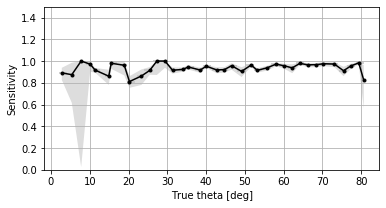

In [168]:
fig, ax, errbr = \
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_theta, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 90/2.5, 
                         xtranslate_func=np.rad2deg,
                         xlabel ='True theta [deg]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (6,3), ylim=(0,1.5), show=False)
ax.grid()
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'Test set sensitivity as function of the theta (zenith angle).svg'), dpi=150)
plt.show()

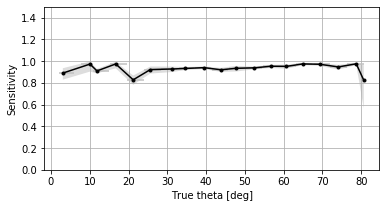

In [175]:
fig, ax, errbr = \
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_theta, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 90/5, 
                         xtranslate_func=np.rad2deg,
                         xlabel ='True theta [deg]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (6,3), ylim=(0,1.5), show=False)
ax.grid()
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_theta_5deg.svg'), dpi=150)
plt.show()

#### Test set sensitivity as function of the phi (azimuth angle)

In [169]:
extra_trees_cls_on_train_rfecv__test__numbers_by_phi = \
    score_by_column(
        rfecv_selector_on_extra_trees_cls, 
        learning_data__var_th_X_test[learning_data__simu_shower_track_mask_arr_test], 
        learning_data__y_test[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers,
        learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'etruth_truephi')

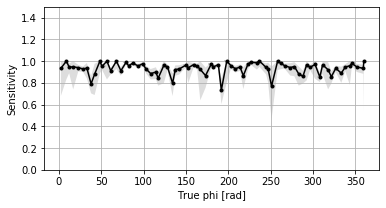

In [170]:
fig, ax, errbr = \
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_phi, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 360/5, 
                         xtranslate_func=np.rad2deg,
                         xlabel = 'True phi [rad]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (6,3), ylim=(0,1.5), show=False)
ax.grid()
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'Test set sensitivity as function of the phi (azimuth angle).svg'), dpi=150)
plt.show()

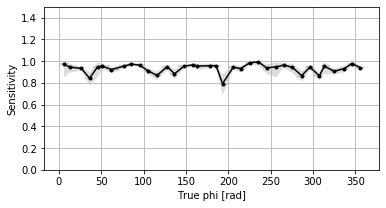

In [174]:
fig, ax, errbr = \
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_phi, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 360/10, 
                         xtranslate_func=np.rad2deg,
                         xlabel = 'True phi [rad]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (6,3), ylim=(0,1.5), show=False)
ax.grid()
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_phi_10deg.svg'), dpi=150)
plt.show()

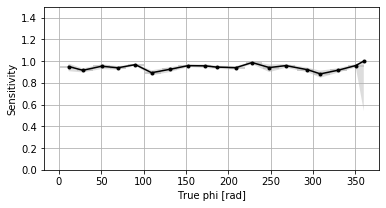

In [176]:
fig, ax, errbr = \
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_phi, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 360/20, 
                         xtranslate_func=np.rad2deg,
                         xlabel = 'True phi [rad]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (6,3), ylim=(0,1.5), show=False)
ax.grid()
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_phi_20deg.svg'), dpi=150)
plt.show()

In [171]:
extra_trees_cls_on_train_rfecv__test__numbers_by_rmax = \
    score_by_column(
        rfecv_selector_on_extra_trees_cls, 
        learning_data__var_th_X_test[learning_data__simu_shower_track_mask_arr_test], 
        learning_data__y_test[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers,
        learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'calc_etruth_trueshower_rmax')

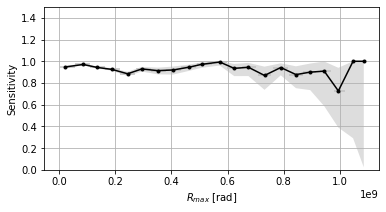

In [173]:
fig, ax, errbr = \
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_rmax, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 20, 
                         xtranslate_func=np.rad2deg,
                         xlabel = '$R_{max}$ [rad]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (6,3), ylim=(0,1.5), show=False)
ax.grid()
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'test_set_sensitivity_function_of_rmax.svg'), dpi=150)
plt.show()

### Cross-validated recognition performance

In [174]:
# TODO

# extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results = \
#     cross_val_score_meta_scored(
    
#         extra_trees_cls_on_train_rfecv_for_crossvalidation, 
#         learning_data__rfecv_var_th_X, learning_data__y, 
#         meta_score_func=None,
#         score_func=calc_cls_numbers,
#         cv=3, random_state=32, 
#         train_sample_weight_func=cross_val_calc_weights
    
    
    
    
    
#         extra_trees_cls_on_train_rfecv_for_crossvalidation,
#         learning_data__rfecv_var_th_X, learning_data__y,
#         get_func_score_by_column_using_indices(None, learning_data__event_id, combined_simu_df, 'etruth_trueenergy'),
#         score_func=calc_cls_numbers,
#         cv=sklearn.model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=123), verbose=1
#     )

0
len(X_train): 39257
len(X_test): 9815


NotFittedError: This ExtraTreesClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

#### Considering all samples from cross-validations (not very correct)
All results from the cross-validations are joined into a single set (list) and then this set is used to calculate error - this multiplies size of the dataset by number of cross-validation folds.

Functions are not using any results reduce function - parameter `dict_stats_yerr_reduce` is not set.

In [ ]:
# plt.close('all')
# for xscale in ['linear', 'log']:
#     fig, ax, errbr = \
#         plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
#                              plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 20, xscale=xscale,
#                              calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
#                              xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
#                              figsize = (10,6), ylim=(0,1.2), show=False)
#     fig.savefig(os.path.join(data_snippets_dir, 'figures', 
#                              'Cross-validated - Considering all samples from cross-validations (not very correct) - sensitivity - {}.svg'.format(xscale)), dpi=150)
# for xscale in ['linear', 'log']: 
#     fig, ax = plt.subplots()
#     fig, ax, errbr_num_positive = \
#         plot_efficiency_stat(
#             extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
#             plotted_stat='num_positive', num_steps = 20, xscale=xscale,
#             xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
#             figsize = (10,6), errorbar_attrs=dict(linestyle='-', color='blue'),
#             ax=ax, show=False)
#     fig, ax, errbr_num_true_positive = \
#         plot_efficiency_stat(
#             extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
#             plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
#             xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
#             figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
#             ax=ax, show=False)
#     ax.set_ylabel('Num. samples')
#     ax.legend()
#     fig.savefig(os.path.join(data_snippets_dir, 'figures', 
#                              'Cross-validated - Considering all samples from cross-validations (not very correct) - num samples - {}.svg'.format(xscale)), dpi=150)
#     plt.show()

#### Averaging sensitivities, error is standard deviation
Parameter `dict_stats_yerr_reduce` is set to compute standard deviation of different cross-validation results.

In [ ]:
# plt.close('all')
# for xscale in ['linear', 'log']:
#     fig, ax, errbr = \
#         plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
#                              concat_dicts=False, dict_stats_yerr_reduce='std_y',
#                              plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', 
#                              calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
#                              num_steps = 20, xscale=xscale,
#                              xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
#                              figsize = (10,6), ylim=(0,1.2), show=False)
#     fig.savefig(os.path.join(data_snippets_dir, 'figures', 
#                              'Cross-validated - Averaging sensitivities, error is standard deviation - sensitivity - {}.svg'.format(xscale)), dpi=150)
#     plt.show()

#### Averaging sensitivities, error is min-max range

In [ ]:
# for confidence in [68, 95, 100]:
#     print('Confidence:', confidence)
#     for xscale in ['linear', 'log']:
#         fig, ax, errbr = \
#             plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
#                                  concat_dicts=False, dict_stats_yerr_reduce='minmax_y',
#                                  plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_'+str(confidence), 
#                                  num_steps = 20, xscale=xscale,
#                                  calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
#                                  xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
#                                  figsize = (10,6), ylim=(0,1.2), show=False)
#         fig.savefig(os.path.join(data_snippets_dir, 'figures', 
#                                  'Cross-validated - Averaging sensitivities, error is min-max range - sensitivity - {}.svg'.format(xscale)), dpi=150)
#         plt.show()

#### Averaging sensitivities, error is avg_yerr_weighted

Error should be an average of errors for cross-validated sets

In [ ]:
# for confidence in [68, 95, 100]:
#     print('Confidence:', confidence)
#     for xscale in ['linear', 'log']:
#         fig, ax, errbr = \
#             plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
#                                  concat_dicts=False, dict_stats_yerr_reduce='avg_yerr_weighted',
#                                  plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_'+str(confidence), 
#                                  calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
#                                  num_steps = 20, xscale=xscale,
#                                  xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
#                                  figsize = (10,6), ylim=(0,1.2))
#         fig.savefig(os.path.join(data_snippets_dir, 'figures', 
#                                  'Cross-validated - Averaging sensitivities, error is avg_yerr_weighted - sensitivity - {}.svg'.format(xscale)), dpi=150)
#         plt.show()

## TODO
- investigate sensitivity(background), use bg_mean column
- investigate sensitivity(shower_max_pos)

# Flight data classification

In [175]:
pipeline_from_trained_models__extr_rfecv_vth__y_pred = \
    pipeline_from_trained_models__extr_rfecv_vth.predict(
        unl_flight_df[analyzed_common_df_columns].dropna().values)

In [176]:
num_non_shower = np.count_nonzero(pipeline_from_trained_models__extr_rfecv_vth__y_pred == 0)
num_shower = np.count_nonzero(pipeline_from_trained_models__extr_rfecv_vth__y_pred == 1)
tot_entries = len(unl_flight_df[analyzed_common_df_columns].dropna().values)

print("Num. non-shower", num_non_shower)
print("Num. shower", num_shower)
print("All entries", tot_entries)
print("-"*30)
print("Fraction non-shower: {:.3f}".format(num_non_shower/tot_entries))
print("Fraction shower: {:.3f}".format(num_shower/tot_entries))

Num. non-shower 9765
Num. shower 235
All entries 10000
------------------------------
Fraction non-shower: 0.977
Fraction shower: 0.024


In [ ]:
# tsne_on_learning_data_60_rfecv_column_names_hexdigest = hashlib.md5((','.join(rfecv_selector_on_extra_trees__column_names__sorted[0:60])).encode()).hexdigest()

# tsne_on_learning_data_60_rfecv_columns_alldata_pathname = \
#     os.path.join(data_snippets_dir, 'tsne_on_learning_data_60_rfecv_columns_alldata_{}.pkl'.format(
#         tsne_on_learning_data_60_rfecv_column_names_hexdigest))
# tsne_on_learning_data_60_rfecv_columns_scaler_alldata_pathname = \
#     os.path.join(data_snippets_dir, 'tsne_on_learning_data_60_rfecv_columns_{}_scale_alldatar.pkl'.format(
#         tsne_on_learning_data_60_rfecv_column_names_hexdigest))

# if refit_tsne_model or not os.path.exists(tsne_on_learning_data_60_rfecv_columns_alldata_pathname):
#     tsne_on_learning_data_60_rfecv_columns_alldata = sklearn.manifold.TSNE(learning_rate=100, verbose=10, n_iter=5000)
#     tsne_on_learning_data_60_rfecv_columns_scaler_alldata = sklearn.preprocessing.StandardScaler()
    
#     learning_data__X__tsne_learning_data_60_rfecv_columns_alldata = \
#         tsne_on_learning_data_60_rfecv_columns_alldata.fit_transform(
#             tsne_on_learning_data_60_rfecv_columns_scaler_alldata.fit_transform(
#                 rfecv_selector_on_extra_trees_cls.transform(learning_data__var_th_X_train).T[   # 232.T[
#                     rfecv_selector_on_extra_trees__column_indices__sorted[0:60]].T              #       232[0:60]].T
#             )
#         )
    
#     if dump_tsne_model: 
#         print(tsne_on_learning_data_60_rfecv_columns_alldata_pathname)
#         joblib.dump(tsne_on_learning_data_60_rfecv_columns_alldata, 
#                     tsne_on_learning_data_60_rfecv_columns_alldata_pathname, compress=1)
        
#         print(tsne_on_learning_data_60_rfecv_columns_scaler_alldata_pathname)
#         joblib.dump(tsne_on_learning_data_60_rfecv_columns_scaler_alldata, 
#                     tsne_on_learning_data_60_rfecv_columns_scaler_alldata_pathname, compress=1)
# else:
#     tsne_on_learning_data_60_rfecv_columns = joblib.load(tsne_on_learning_data_60_rfecv_columns_alldata_pathname)

#     learning_data__X__tsne_learning_data_60_rfecv_columns_alldata = \
#         tsne_on_learning_data_60_rfecv_columns.embedding_

In [ ]:
# joblib.dump(learning_data__X__tsne_learning_data_60_rfecv_columns_alldata, 
#                     tsne_on_learning_data_60_rfecv_columns_alldata_pathname, compress=1)

In [ ]:
# tsne_on_learning_data_60_rfecv_columns_alldata